## Pre-processing:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

#date_parser = lambda dates: pd.datetime.strptime(dates, "%Y-%m-%d") 

data_daily  = pd.read_csv("Daily1.csv",parse_dates = ["Date"], 
                         index_col = 'Date')#date_parser = date_parser

data_monthly = pd.read_csv("Monthly1.csv",parse_dates = ["Date"], 
                         index_col = 'Date') #date_parser = date_parser


close_daily = data_daily["Close"]
close_monthly = data_monthly["Close"]


close_daily.fillna(method='ffill', inplace=True)
#close_monthly.fillna(method='ffill', inplace=True)
close_monthly.dropna(inplace=True)

In [2]:
data_monthly.head() 

Open         High          Low        Close    Adj Close  \
Date                                                                          
2000-02-29          NaN          NaN          NaN          NaN          NaN   
2000-03-31  3133.800049  3201.399902  2902.100098  3115.800049  3115.800049   
2000-04-30  3115.800049  3131.899902  2985.699951  3081.000000  3081.000000   
2000-05-31  3079.500000  3313.800049  3067.100098  3311.199951  3311.199951   
2000-06-30  3304.000000  3337.399902  3227.300049  3251.100098  3251.100098   

            Volume  
Date                
2000-02-29     NaN  
2000-03-31     0.0  
2000-04-30     0.0  
2000-05-31     0.0  
2000-06-30     0.0

## Exploratory Time Series: 

In [3]:
from matplotlib.pyplot import rcParams
rcParams['figure.figsize'] = 16, 6

/Users/apple/anaconda3/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


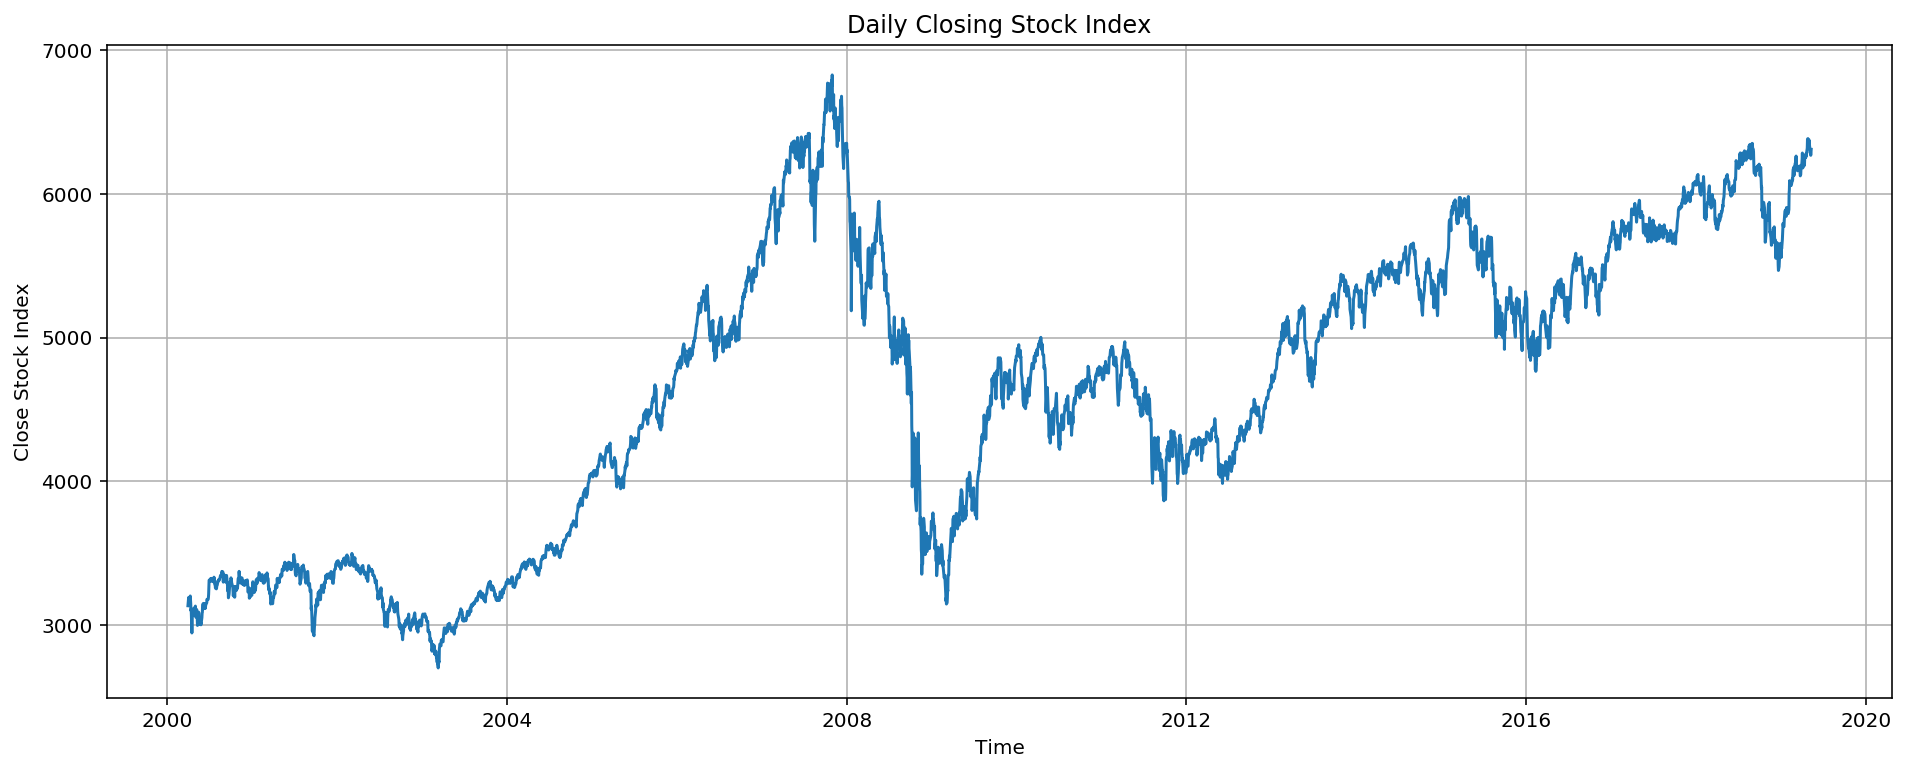

In [4]:
plt.figure()
plt.plot(close_daily)
plt.grid()
plt.title("Daily Closing Stock Index")
plt.xlabel("Time")
plt.ylabel("Close Stock Index");

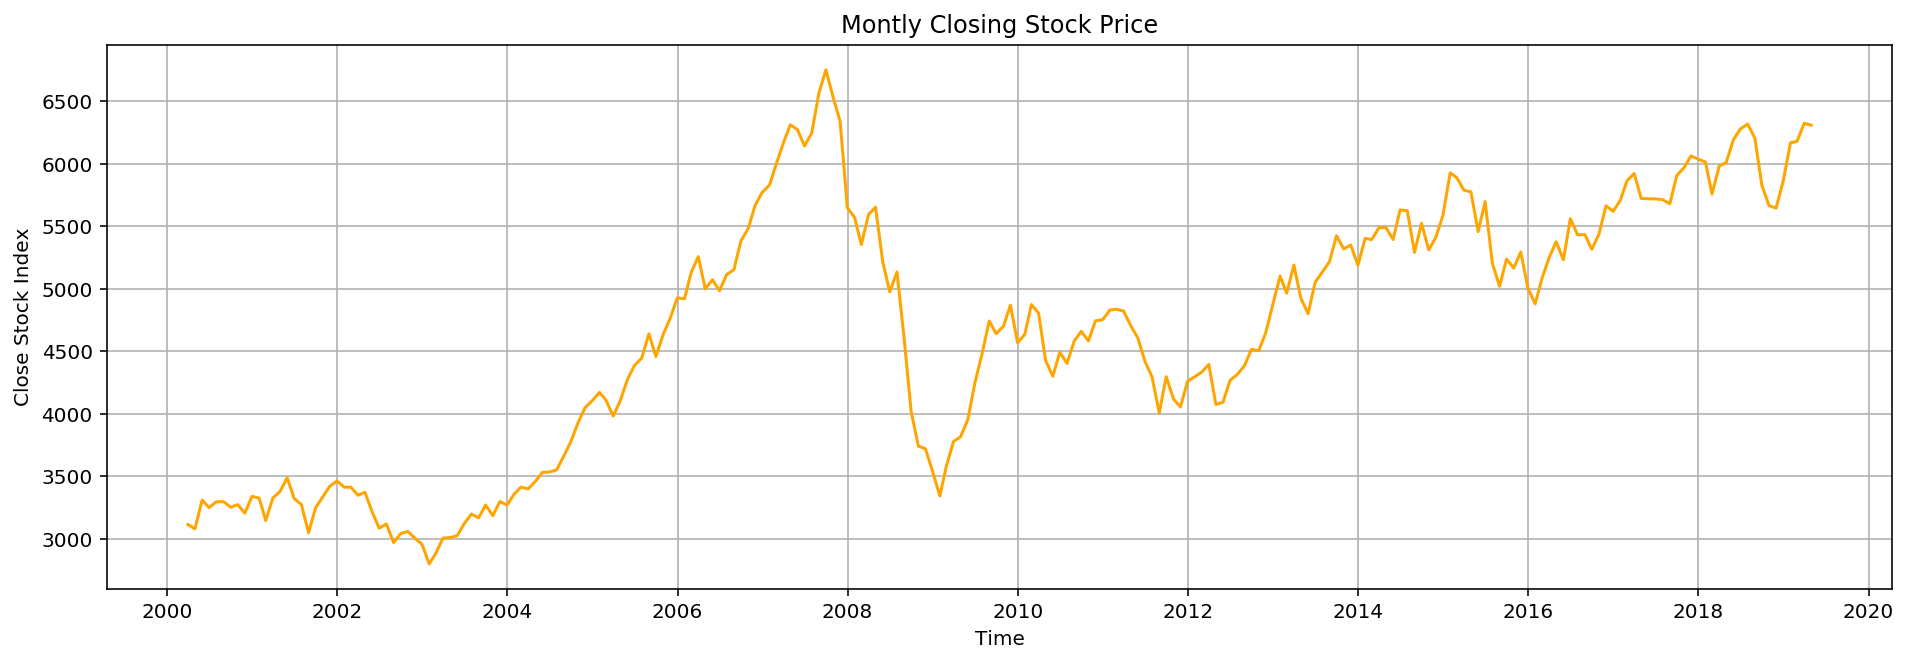

In [5]:
plt.figure(figsize = (16,5))
plt.plot(close_monthly, color = 'orange')
plt.grid()
plt.title("Montly Closing Stock Price")
plt.xlabel("Time")
plt.ylabel("Close Stock Index");

In [6]:
close_daily.describe()

count    4868.000000
mean     4644.147658
std      1019.094953
min      2700.399902
25%      3579.099976
50%      4753.600098
75%      5469.275146
max      6828.700195
Name: Close, dtype: float64

In [7]:
close_monthly.describe()

count     230.000000
mean     4673.738706
std      1022.487177
min      2800.899902
25%      3727.350037
50%      4783.000000
75%      5491.650024
max      6754.100098
Name: Close, dtype: float64

In [8]:
# First order differencing
diff_close_daily = pd.Series.diff(close_daily)
diff_close_monthly = pd.Series.diff(close_monthly)
diff_close_daily.dropna(inplace = True)
diff_close_monthly.dropna(inplace = True)

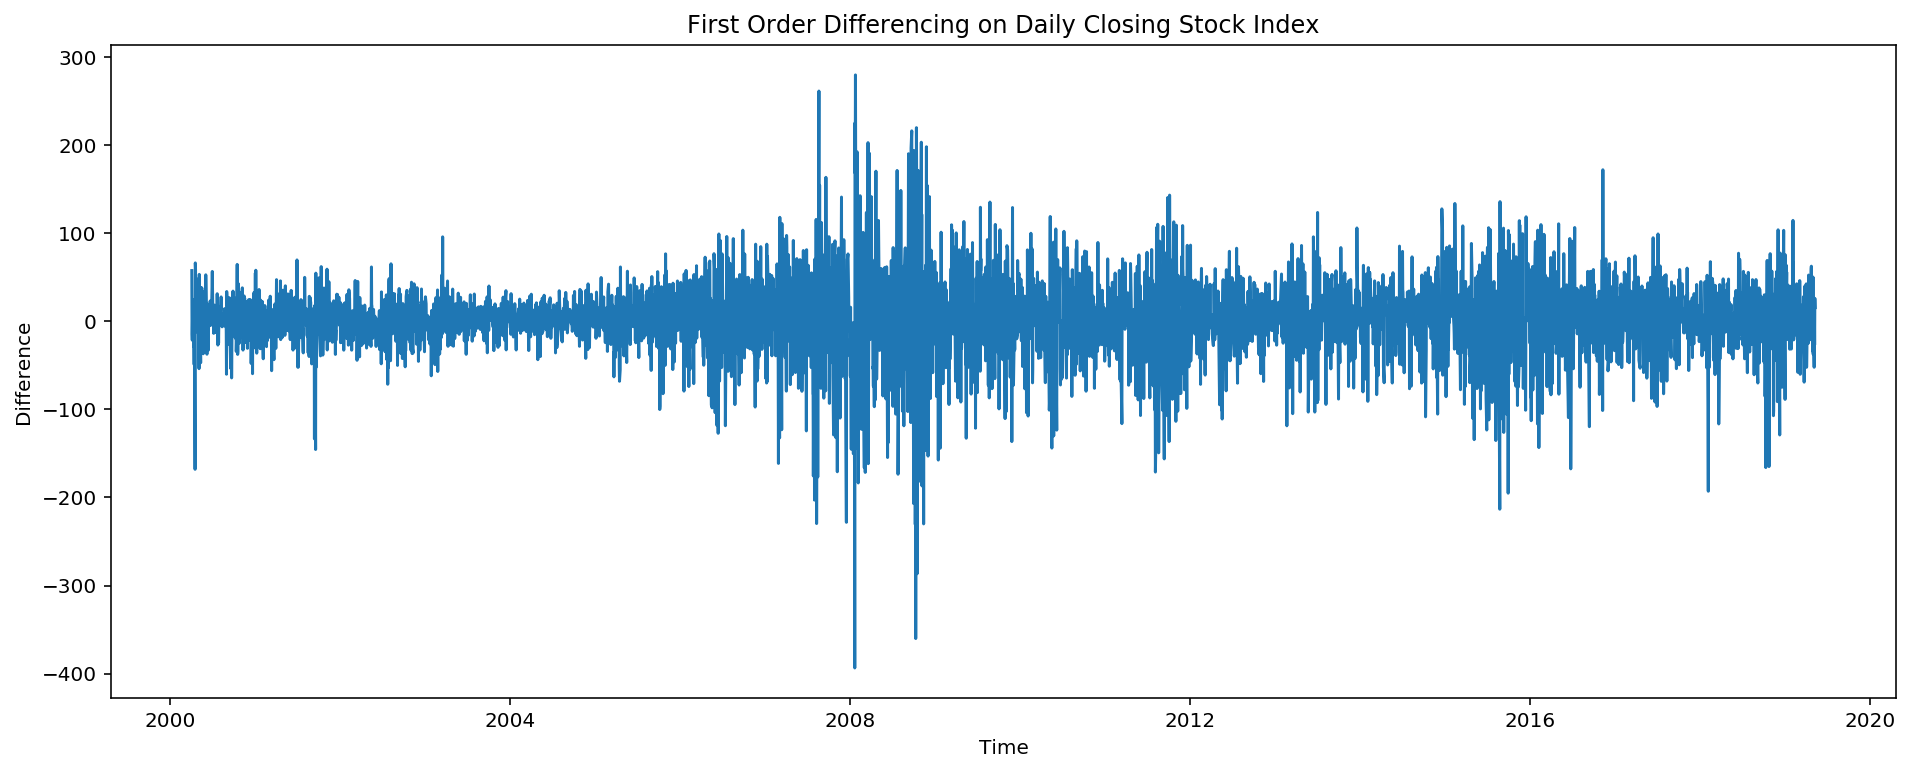

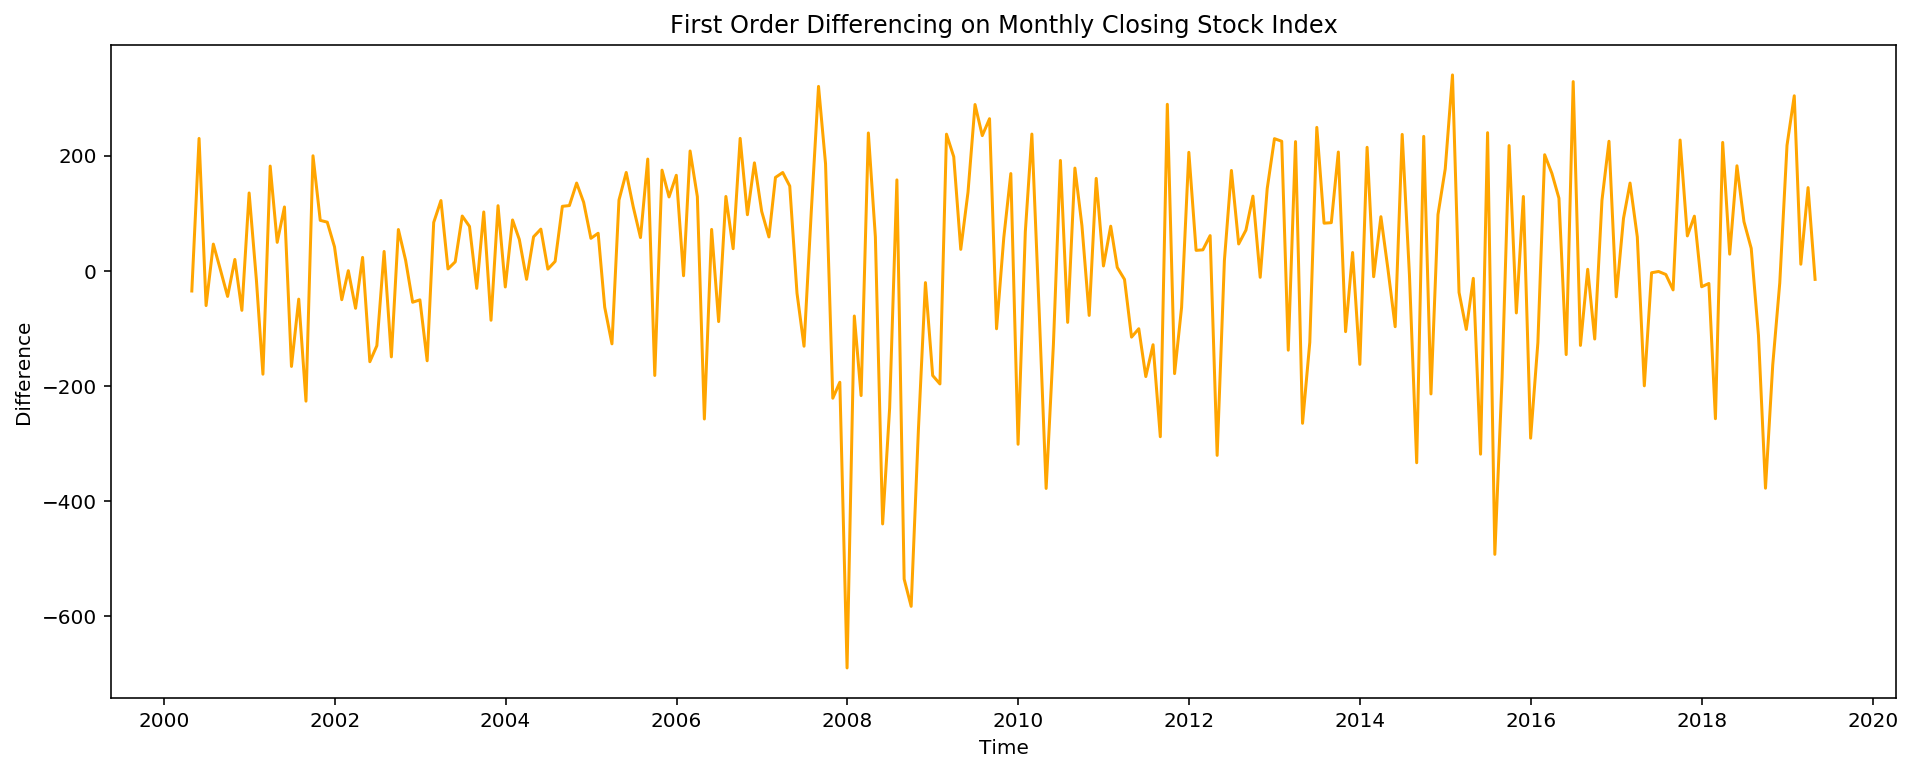

In [9]:
plt.figure()
plt.plot(diff_close_daily)
plt.title("First Order Differencing on Daily Closing Stock Index")
plt.xlabel("Time")
plt.ylabel("Difference");


plt.figure()
plt.plot(diff_close_monthly, color = 'orange')
plt.title("First Order Differencing on Monthly Closing Stock Index")
plt.xlabel("Time")
plt.ylabel("Difference");

### ACF & PACF

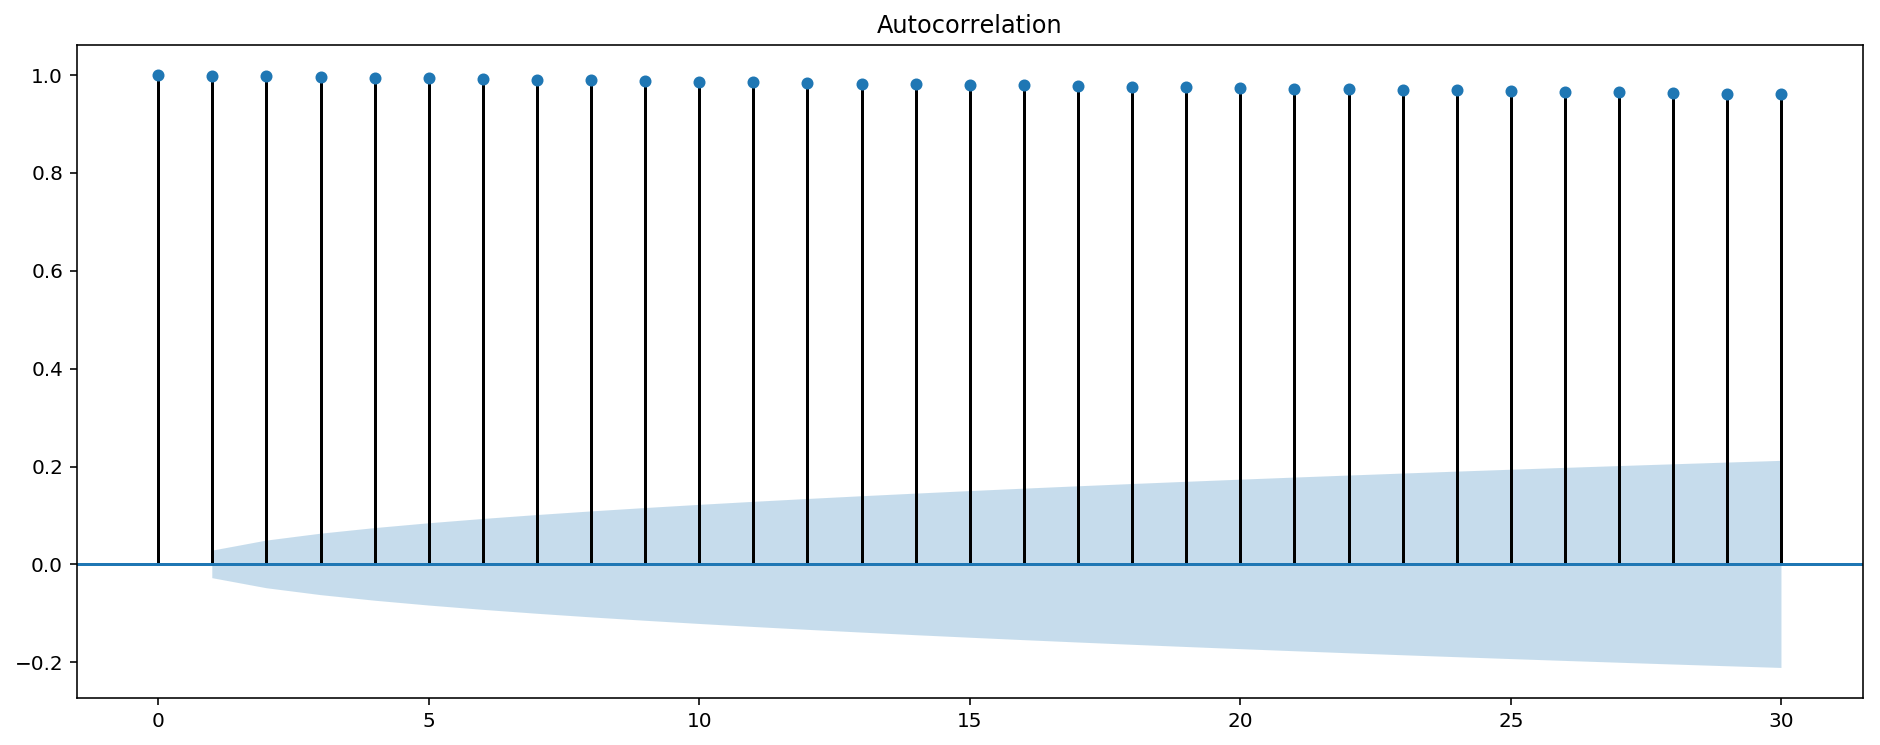

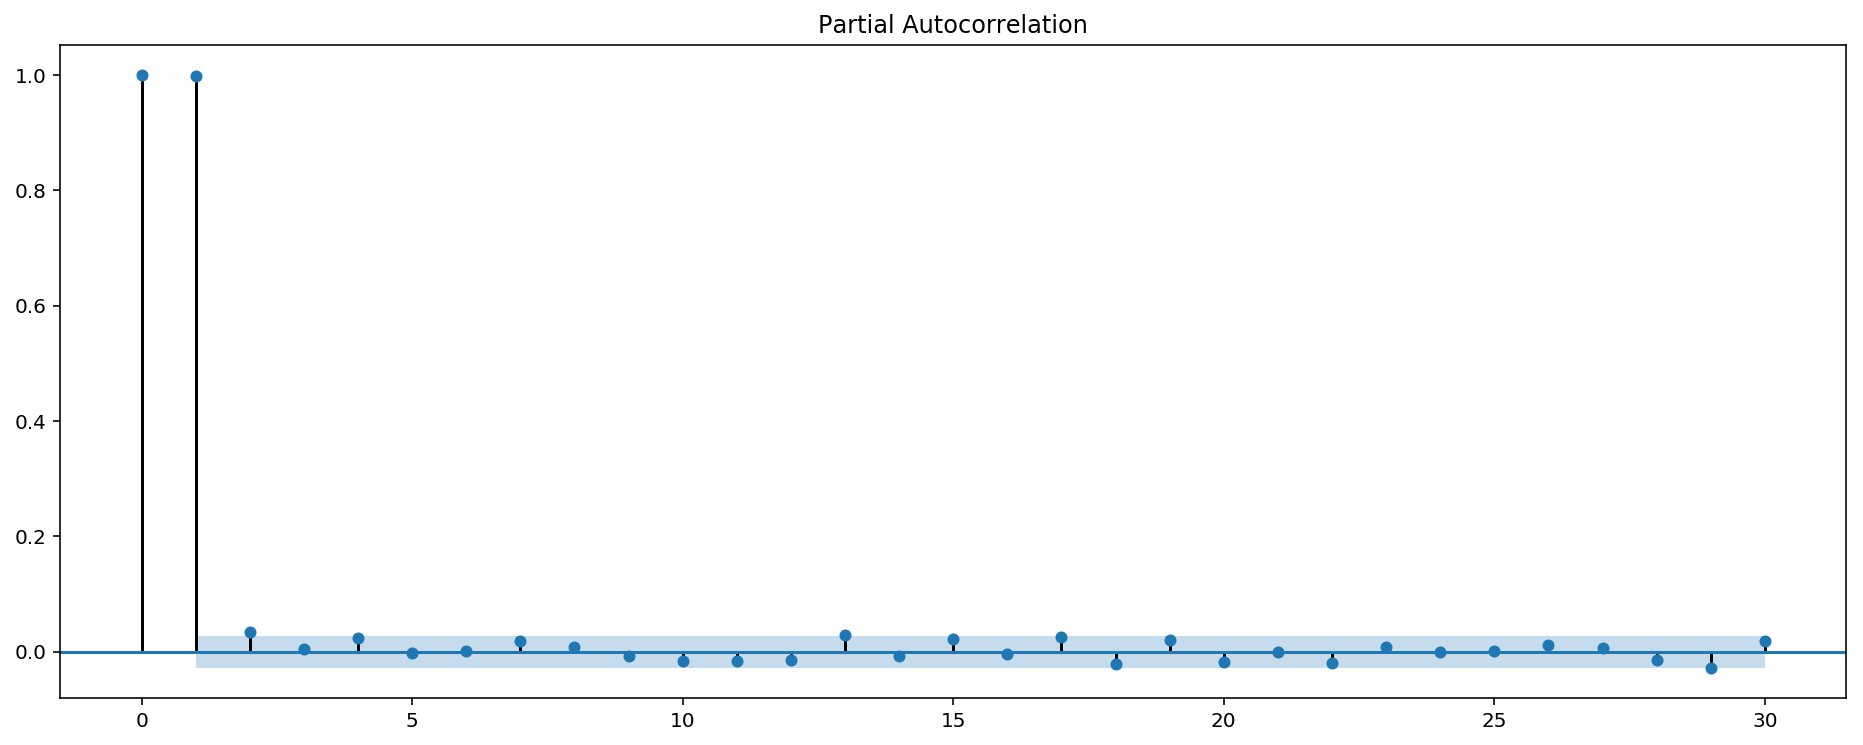

In [10]:
import statsmodels as sm 
import statsmodels.api as smt

smt.graphics.tsa.plot_acf(close_daily, lags = 30, alpha = 0.05)
smt.graphics.tsa.plot_pacf(close_daily, lags=30, alpha=0.05)
plt.show()

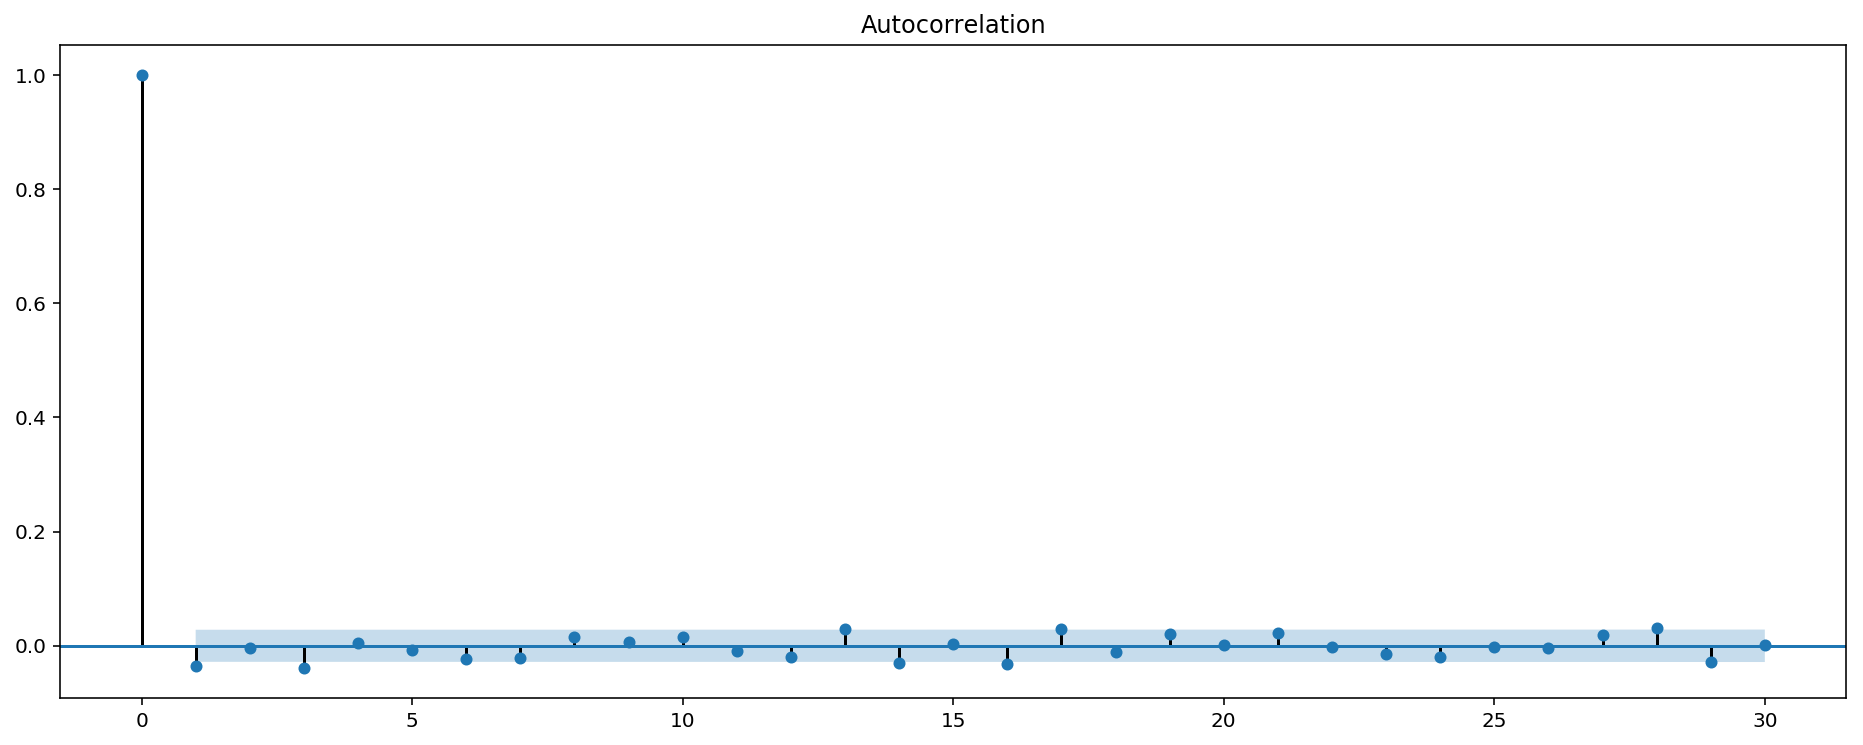

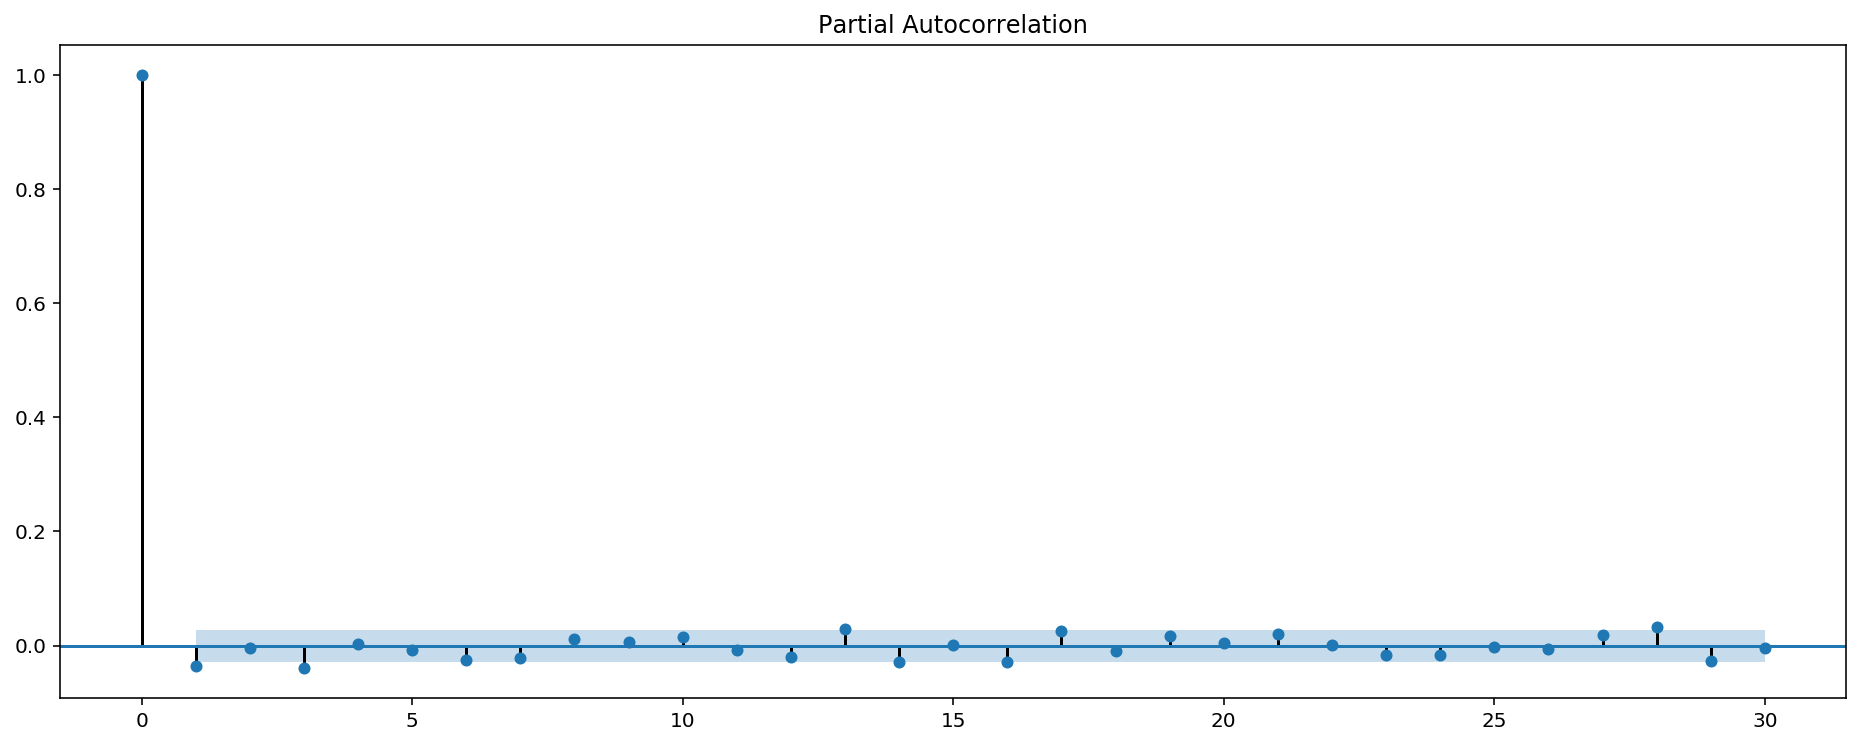

In [11]:
# 1-step difference - daily
smt.graphics.tsa.plot_acf(diff_close_daily, lags = 30, alpha = 0.05)
smt.graphics.tsa.plot_pacf(diff_close_daily, lags=30, alpha=0.05)
plt.show()

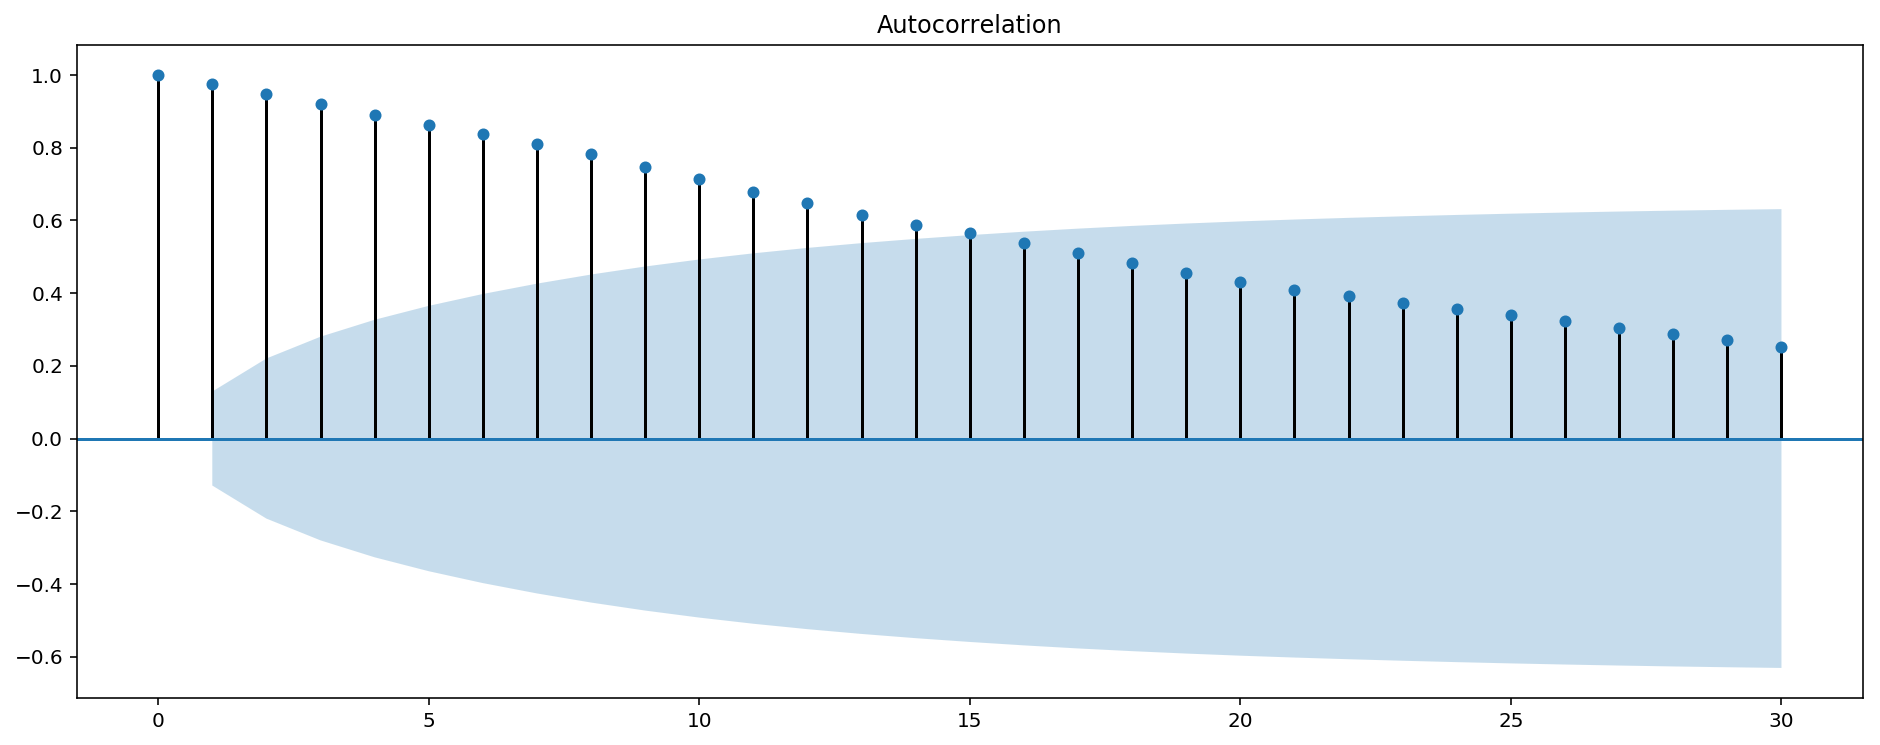

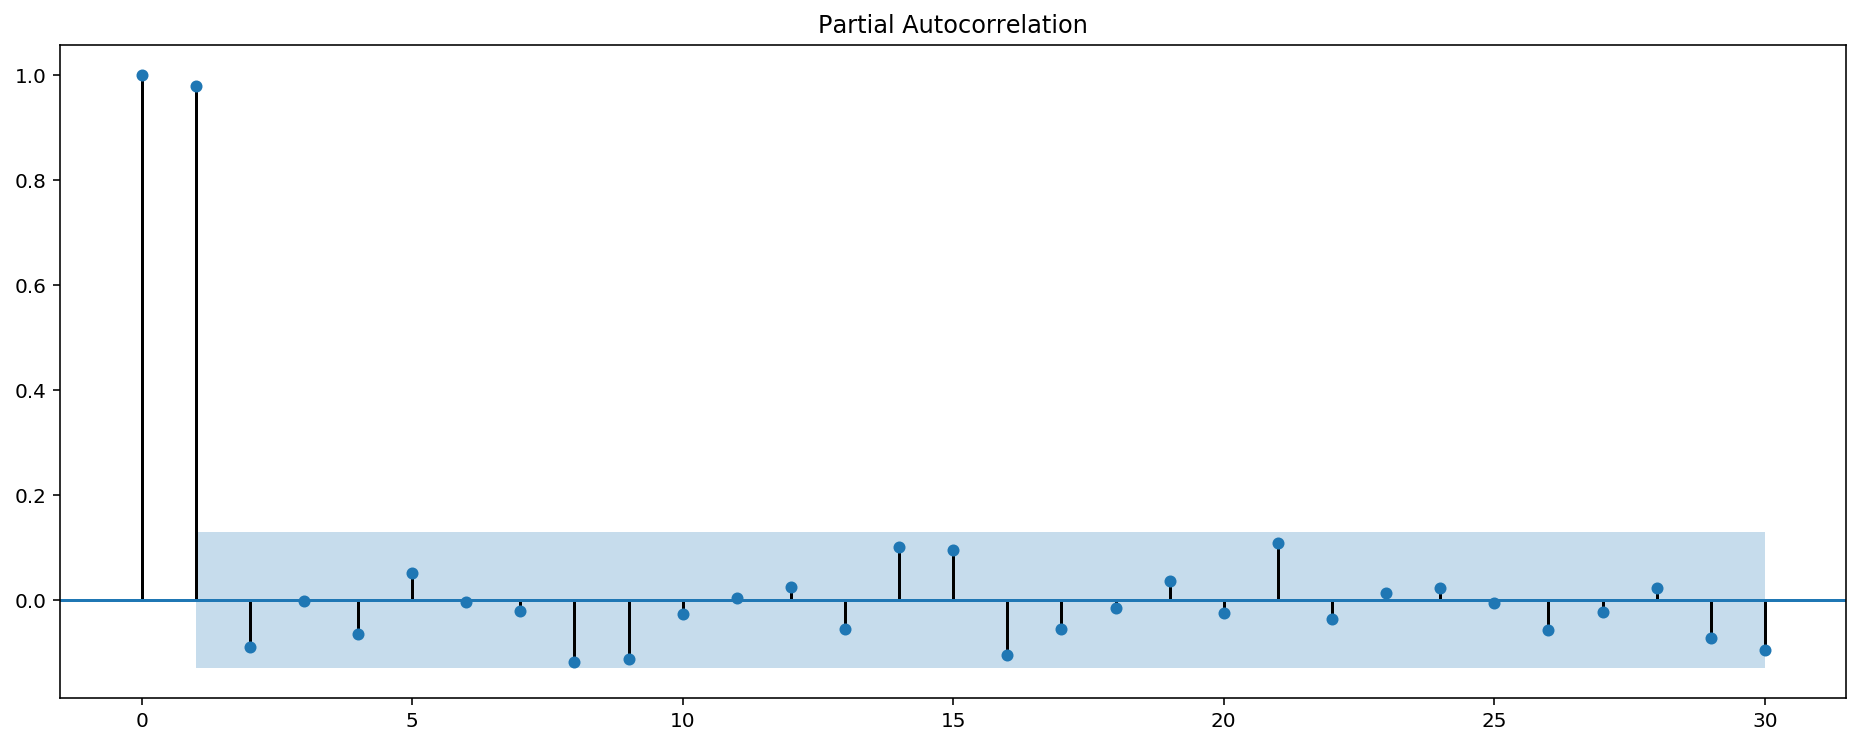

In [12]:
smt.graphics.tsa.plot_acf(close_monthly, lags = 30, alpha = 0.05)
smt.graphics.tsa.plot_pacf(close_monthly, lags=30, alpha=0.05)
plt.show()

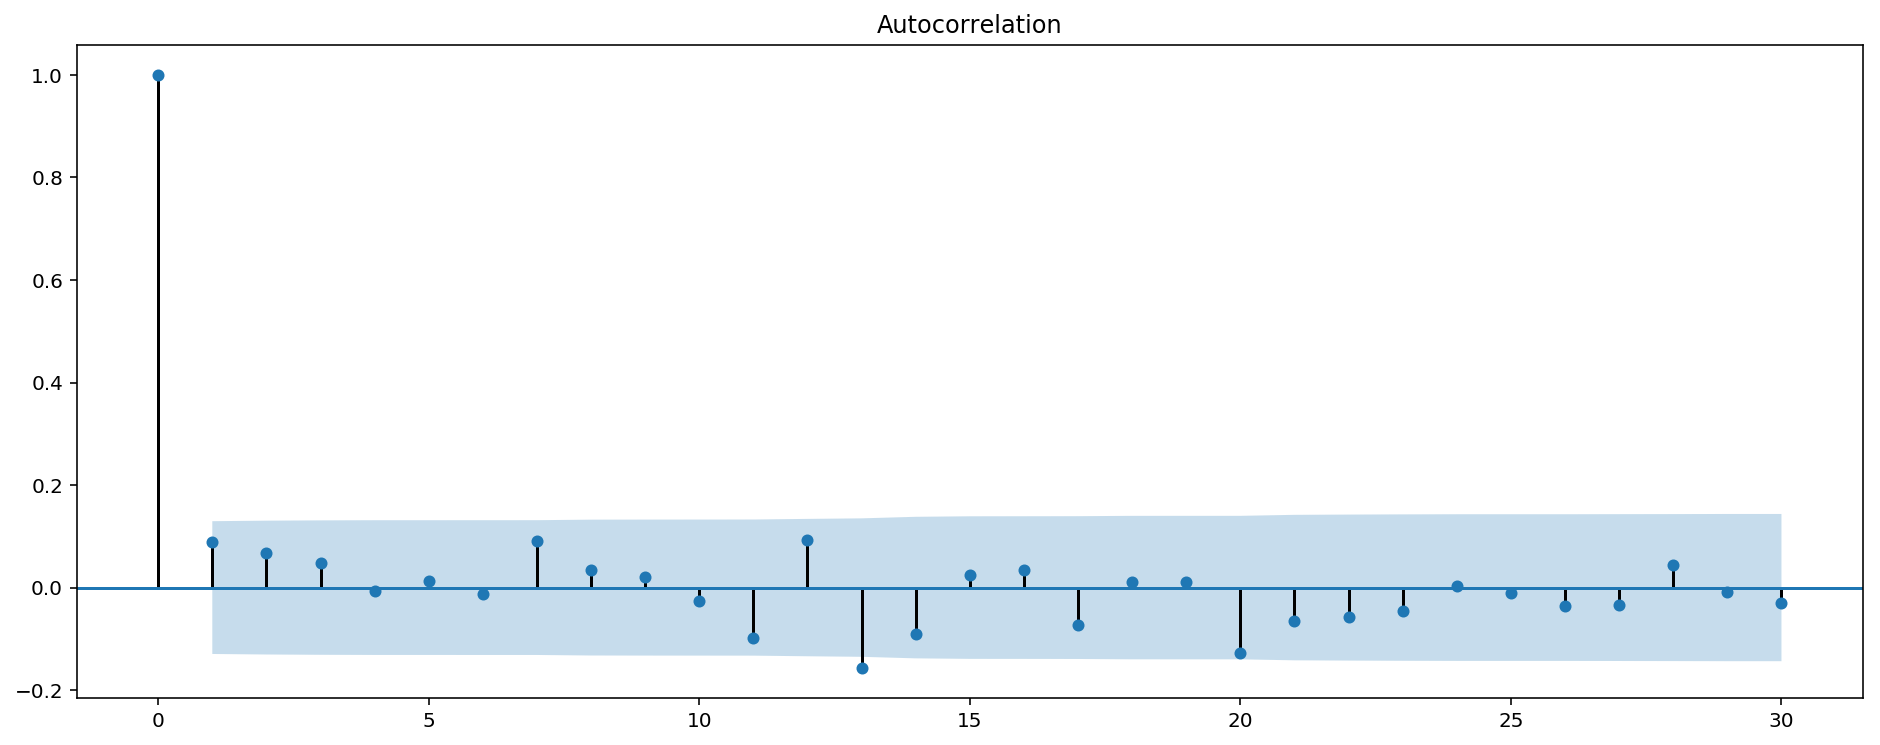

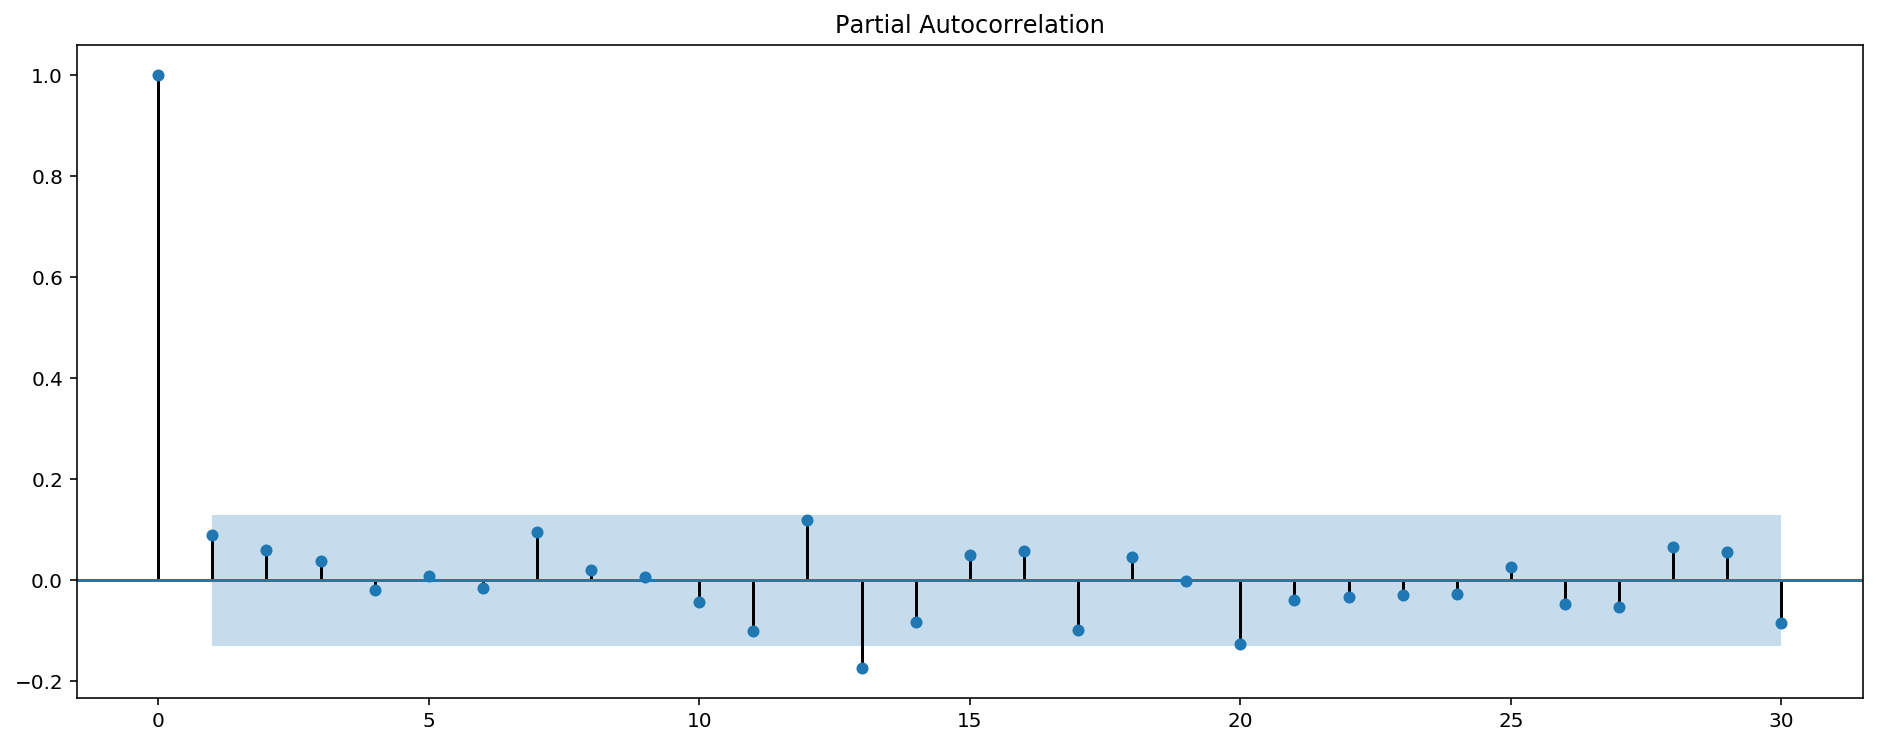

In [13]:
# monthly 1 step diff
smt.graphics.tsa.plot_acf(diff_close_monthly, lags = 30, alpha = 0.05)
smt.graphics.tsa.plot_pacf(diff_close_monthly, lags=30, alpha=0.05)
plt.show()

### Normalize

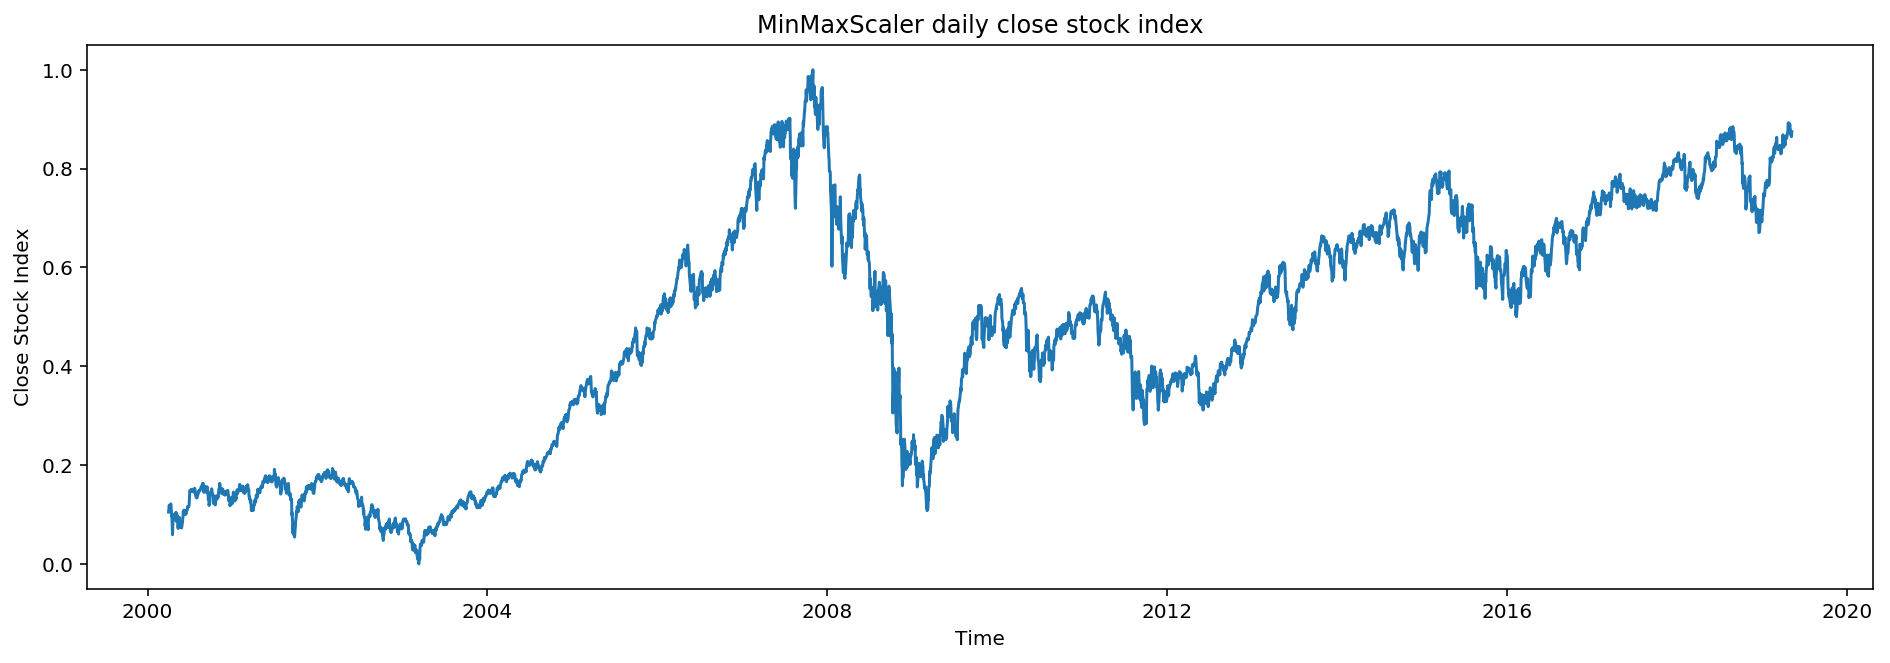

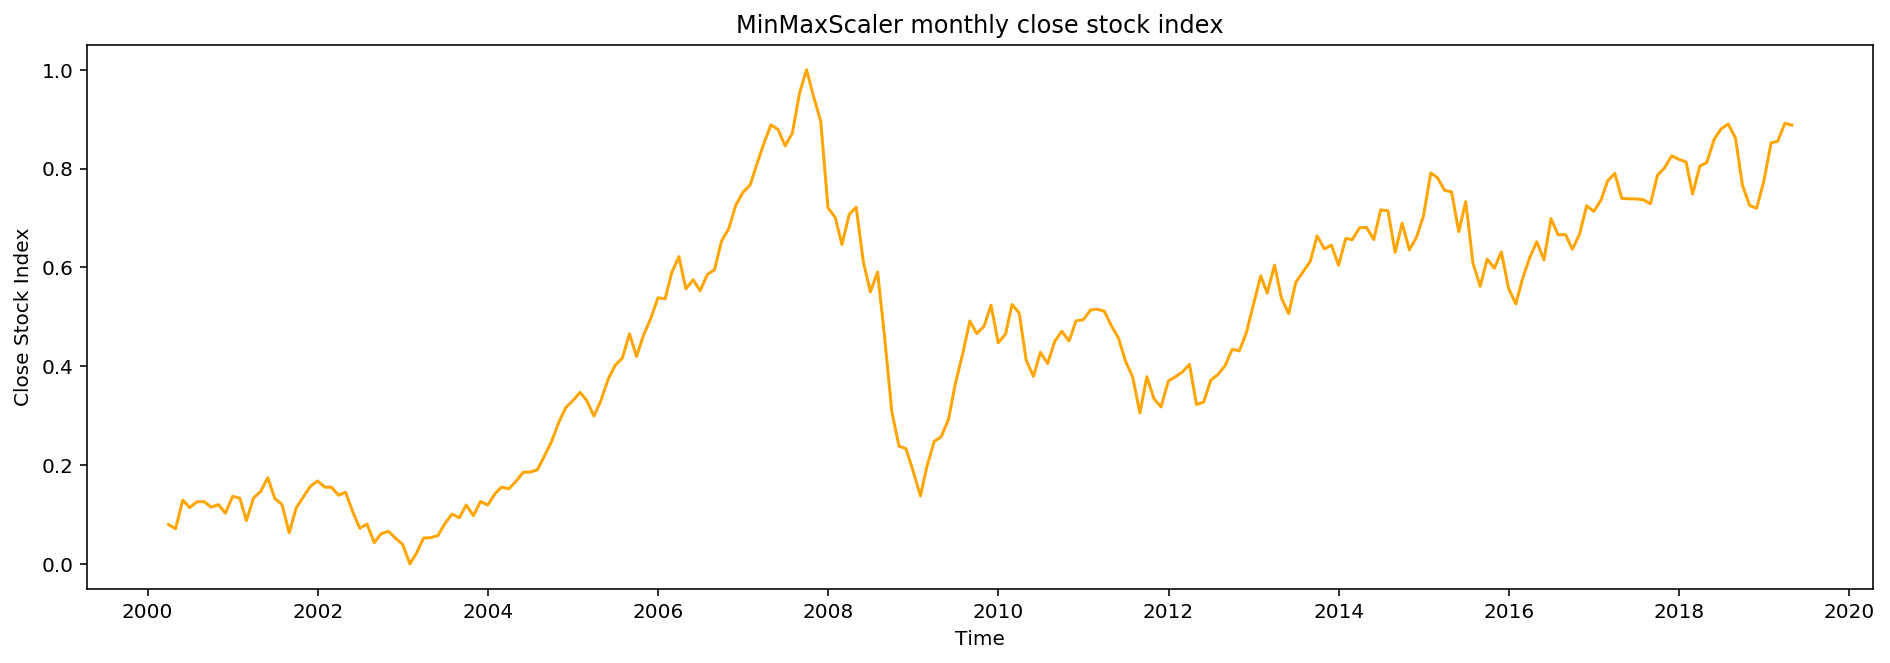

In [14]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
close_daily_normalize = scaler.fit_transform(close_daily.values.reshape(-1,1))
close_monthly_normalize = scaler.fit_transform(close_monthly.values.reshape(-1,1))




close_daily_normalize_2 = close_daily_normalize.copy()
close_daily_normalize_2 = pd.Series(close_daily_normalize_2.flatten(), index =close_daily.index )
close_monthly_normalize_2 = close_monthly_normalize.copy()
close_monthly_normalize_2 = pd.Series(close_monthly_normalize_2.flatten(), index =close_monthly.index )

plt.figure(figsize = (16,5))
plt.plot(close_daily_normalize_2)
plt.title("MinMaxScaler daily close stock index")
plt.xlabel("Time")
plt.ylabel("Close Stock Index");


plt.figure(figsize = (16,5))
plt.plot(close_monthly_normalize_2, color = 'orange')
plt.title("MinMaxScaler monthly close stock index")
plt.xlabel("Time")
plt.ylabel("Close Stock Index");

## Benchmark Model- holt's linear

### Daily 

In [15]:
import math
validation_size = 5
train_size = len(close_daily) - validation_size


In [16]:
train_close_daily = close_daily[:-validation_size]
validation_close_daily  =  close_daily[-validation_size:]


In [17]:
len(train_close_daily)

4863

In [18]:
validation_close_daily

Date
2019-05-06    6283.700195
2019-05-07    6295.700195
2019-05-08    6269.100098
2019-05-09    6295.299805
2019-05-10    6310.899902
Name: Close, dtype: float64

In [19]:
import time
# validate_time = time.strptime("2019-02-24","%Y-%m-%d")
validate_time = validation_close_daily.index[0]

### Holt's linear model

In [20]:
from sklearn.metrics import mean_squared_error
def mse(y, y_pred):
    return (mean_squared_error(y, y_pred))
def rmse(y, y_pred):
    return np.sqrt( mse(y, y_pred))
import warnings
warnings.simplefilter('ignore')

In [21]:
from statsmodels.tsa.holtwinters import Holt
fit1 = Holt(train_close_daily).fit(optimized = True)
smooth_Holt = fit1.fittedvalues


results = pd.DataFrame(index=[r"$\alpha$", 
                              r"$\beta$", 
                              r"$\phi$",  # damped value
                              r"$\gamma$", 
                              r"$l_0$", 
                              "$b_0$", 
                              "SSE"])
params = ['smoothing_level', 
          'smoothing_slope', 
          'damping_slope', 
          'smoothing_seasonal', 
          'initial_level', 
          'initial_slope']

results["Additive"] = [fit1.params[p] for p in params] + [fit1.sse]
results


Additive
$\alpha$  9.646437e-01
$\beta$   0.000000e+00
$\phi$             NaN
$\gamma$           NaN
$l_0$     3.134624e+03
$b_0$     6.582839e-01
SSE       1.005562e+07

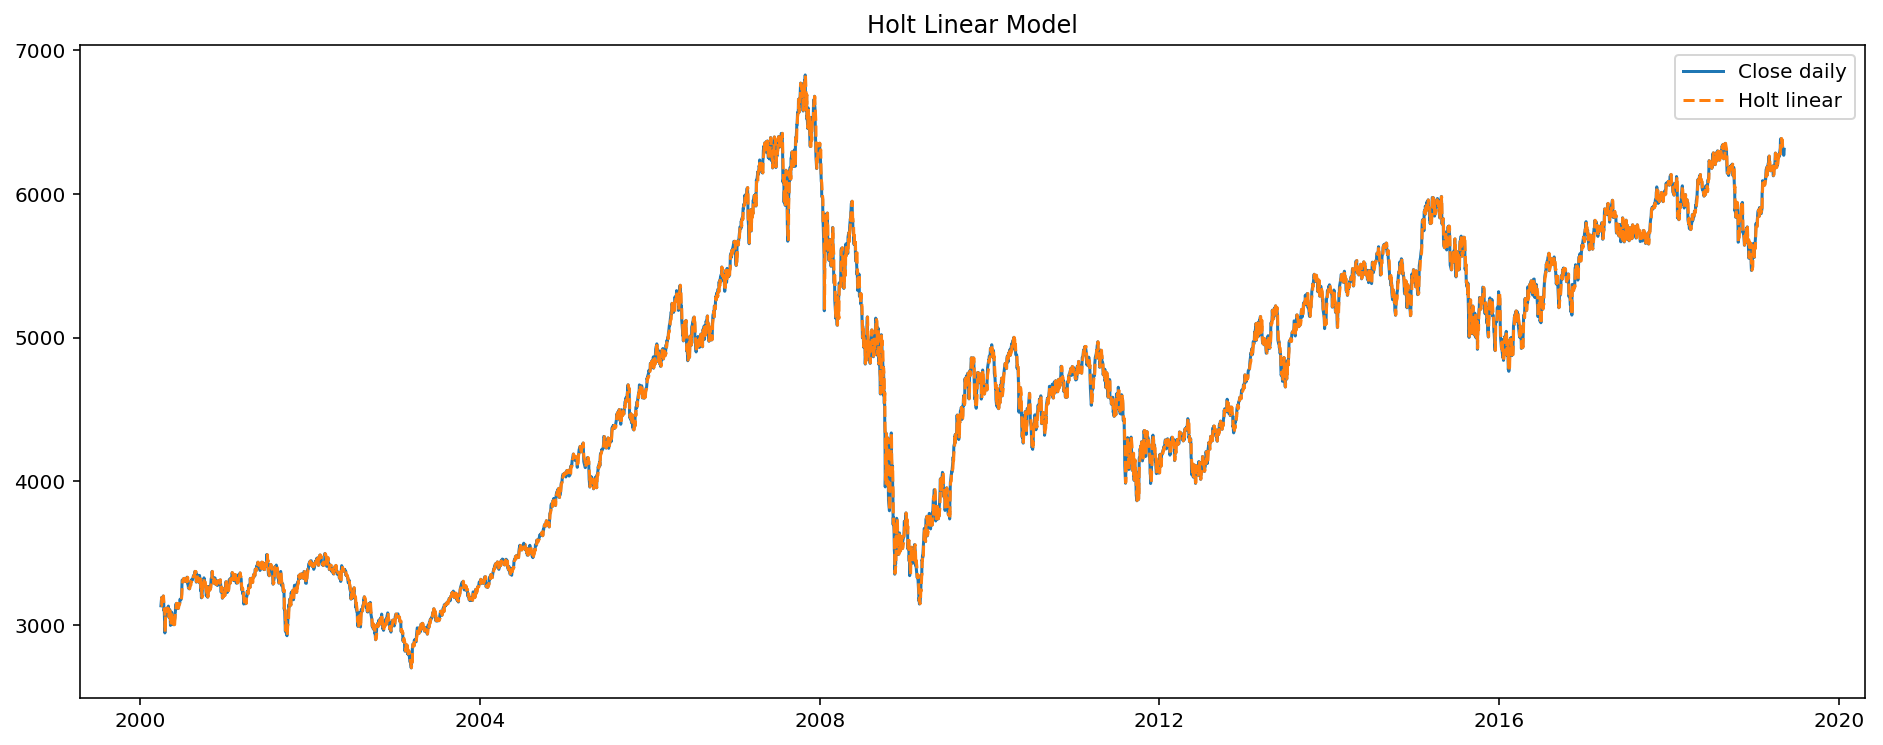

In [22]:
forecast_set = pd.Series(fit1.forecast(validation_size))

forecast_set.index = validation_close_daily.index


plt.figure()
plt.title('Holt Linear Model')
plt.plot(close_daily,label='Close daily')
plt.plot(smooth_Holt,linestyle='--',label='Holt linear')
plt.legend();

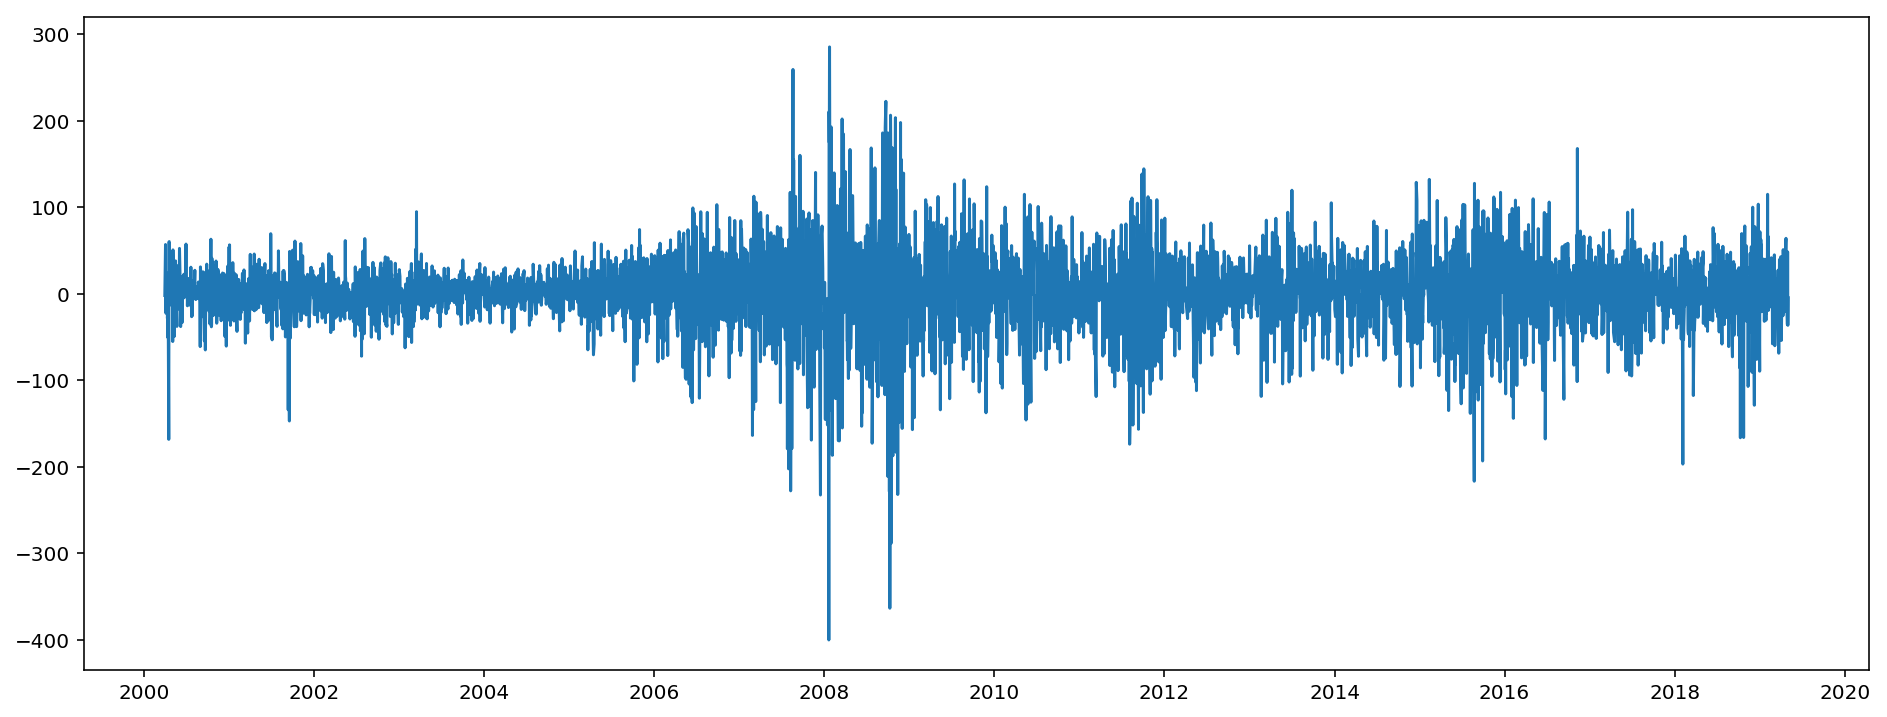

In [23]:
plt.figure()
plt.plot(fit1.resid)
plt.show()

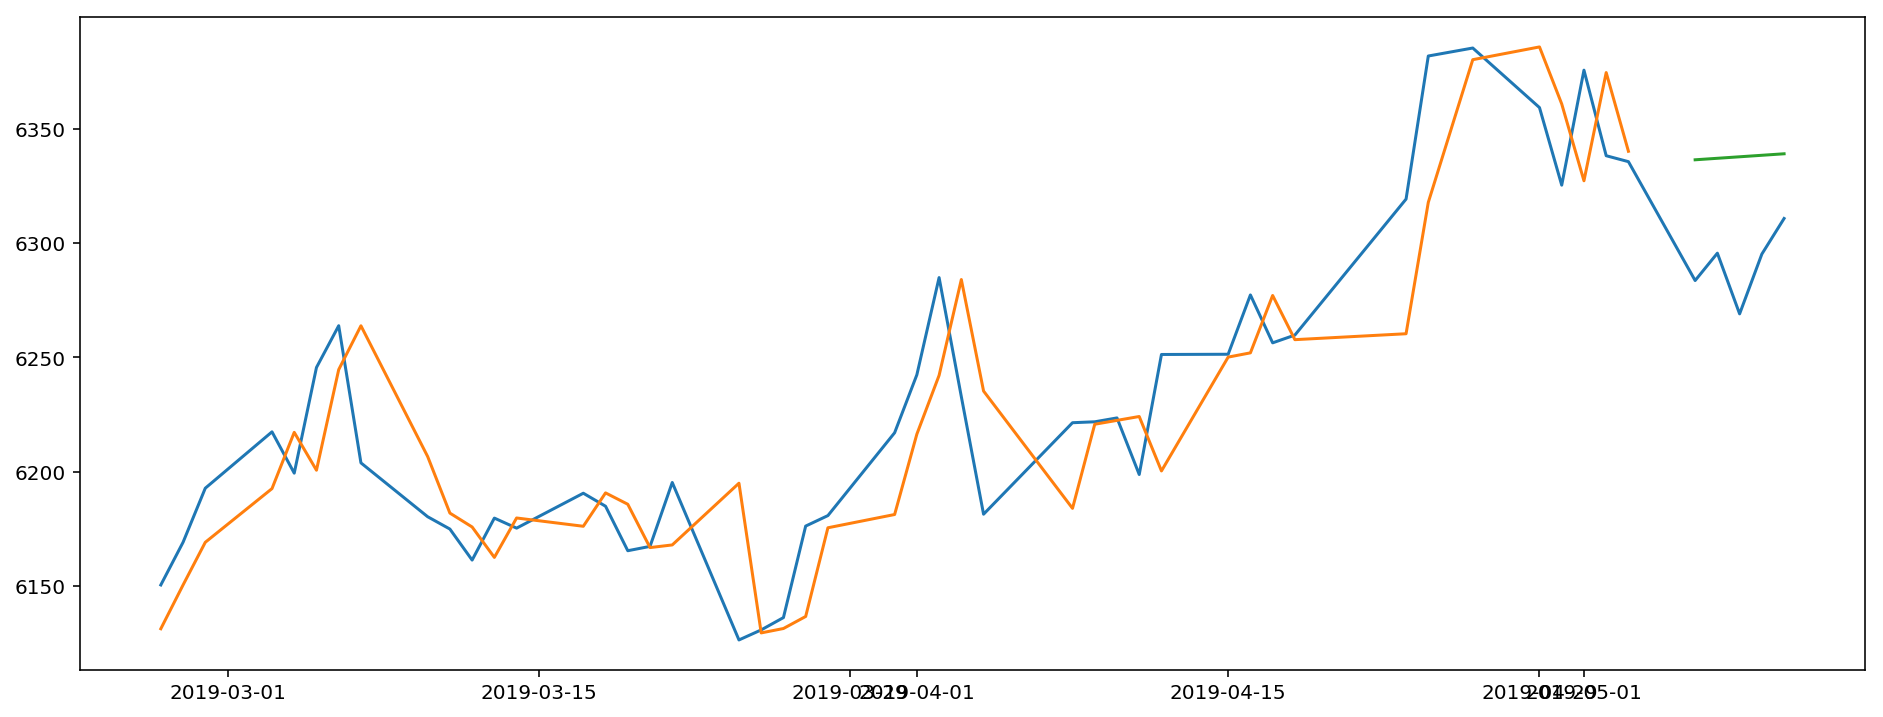

In [24]:
plt.figure()
plt.plot(close_daily[-50:])
plt.plot(smooth_Holt[-(50-validation_size):])
plt.plot(forecast_set)
plt.show()

In [25]:
forecast_set

Date
2019-05-06    6336.618851
2019-05-07    6337.277135
2019-05-08    6337.935418
2019-05-09    6338.593702
2019-05-10    6339.251986
dtype: float64

In [26]:
print('MSE of Linear Regression with intercept: {0:.2f}'.format(mse(smooth_Holt,train_close_daily)))

MSE of Linear Regression with intercept: 2067.78


In [27]:
print("RMSE of train set for HOLT\n{:.2f}".format(rmse(smooth_Holt,train_close_daily)))

RMSE of train set for HOLT
45.47


In [28]:
validation_set = close_daily[-validation_size:].values
print("MSE for Holt’s linear method on validation set\n{:.2f}".format(mse(forecast_set,validation_set)))

MSE for Holt’s linear method on validation set
2389.11


In [29]:
print("RMSE for Holt’s linear method on validation set\n{:.2f}".format(rmse(forecast_set,validation_set)))

RMSE for Holt’s linear method on validation set
48.88


## Build Advanced Models:  ARIMA

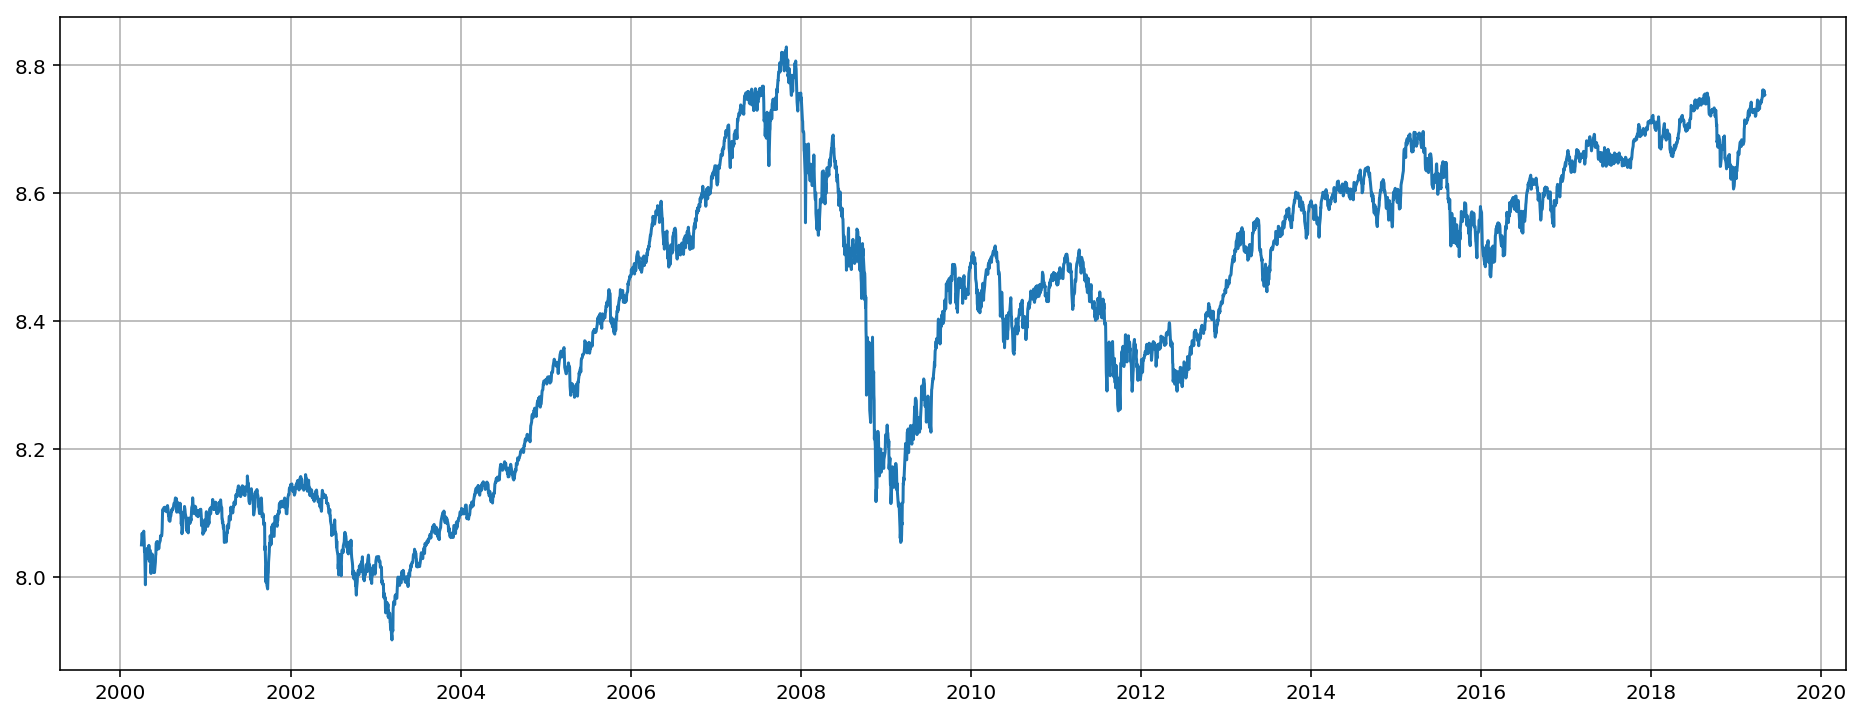

In [30]:
#ARIMA

close_daily_log = np.log(close_daily)
train_close_daily_log = np.log(train_close_daily)
validation_close_daily_log = np.log(validation_close_daily)



plt.figure()
plt.grid()
plt.plot(train_close_daily_log);

In [31]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
#Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used']) 
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value 
    print(dfoutput)

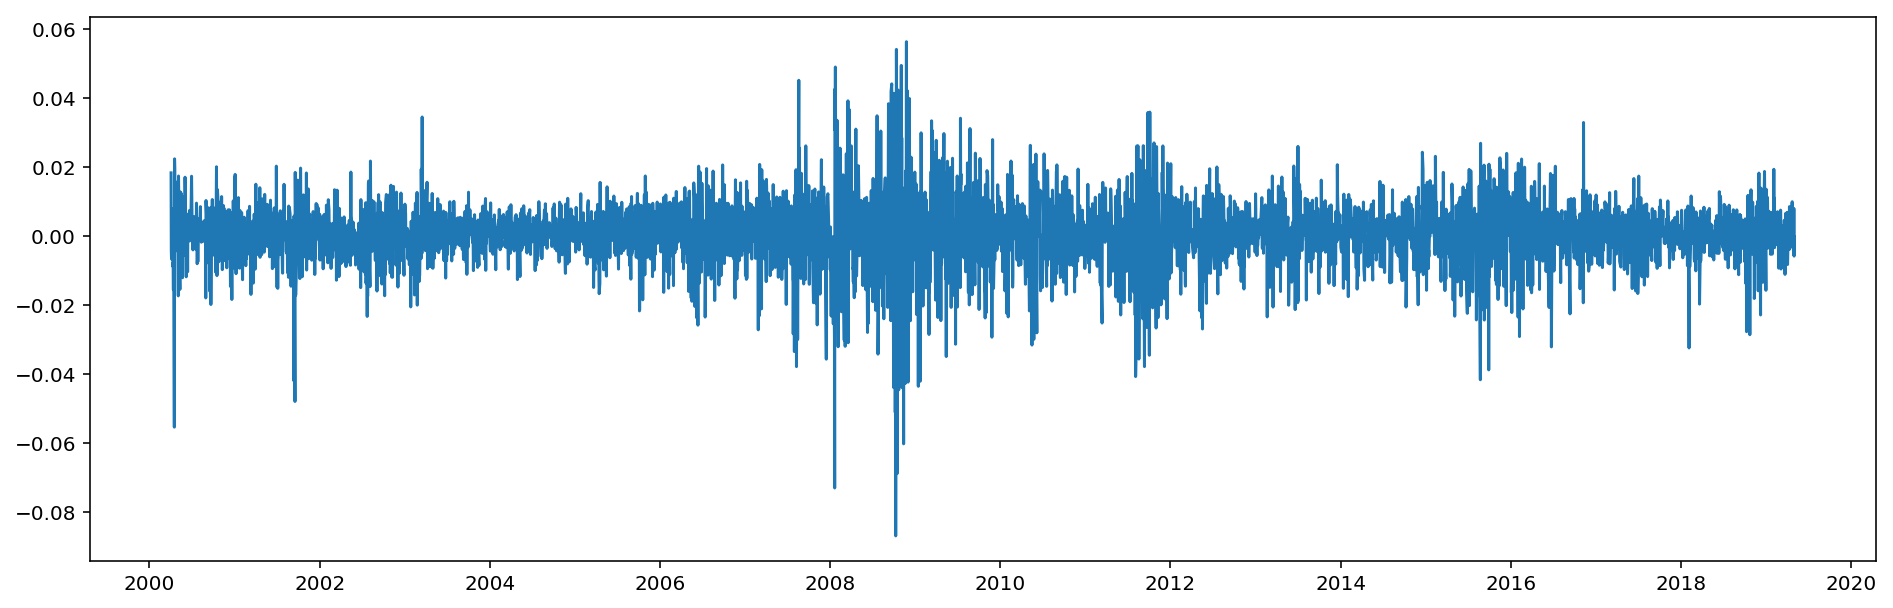

In [32]:
train_close_daily_log_diff = train_close_daily_log.diff()
train_close_daily_log_diff.dropna(inplace = True)
plt.figure(figsize = (16,5))
plt.plot(train_close_daily_log_diff);

In [33]:
test_stationarity(train_close_daily_log_diff)

Results of Dickey-Fuller Test:
Test Statistic                  -42.349425
p-value                           0.000000
#Lags Used                        2.000000
Number of Observations Used    4859.000000
Critical Value (1%)              -3.431697
Critical Value (5%)              -2.862135
Critical Value (10%)             -2.567087
dtype: float64


In [34]:
from pylab import rcParams
rcParams['figure.figsize'] = 16,6
import statsmodels.tsa.stattools as st
order = st.arma_order_select_ic(train_close_daily_log_diff, max_ar = 5, max_ma = 5, ic=['aic'])
print(order.aic_min_order)

(3, 4)


In [35]:
from statsmodels.tsa.arima_model import ARIMA

p,q = order.aic_min_order[0], order.aic_min_order[1]
model_AIC = ARIMA(train_close_daily_log, order = (p, 1, q))  
results_AIC_ARIMA = model_AIC.fit(disp = -1)

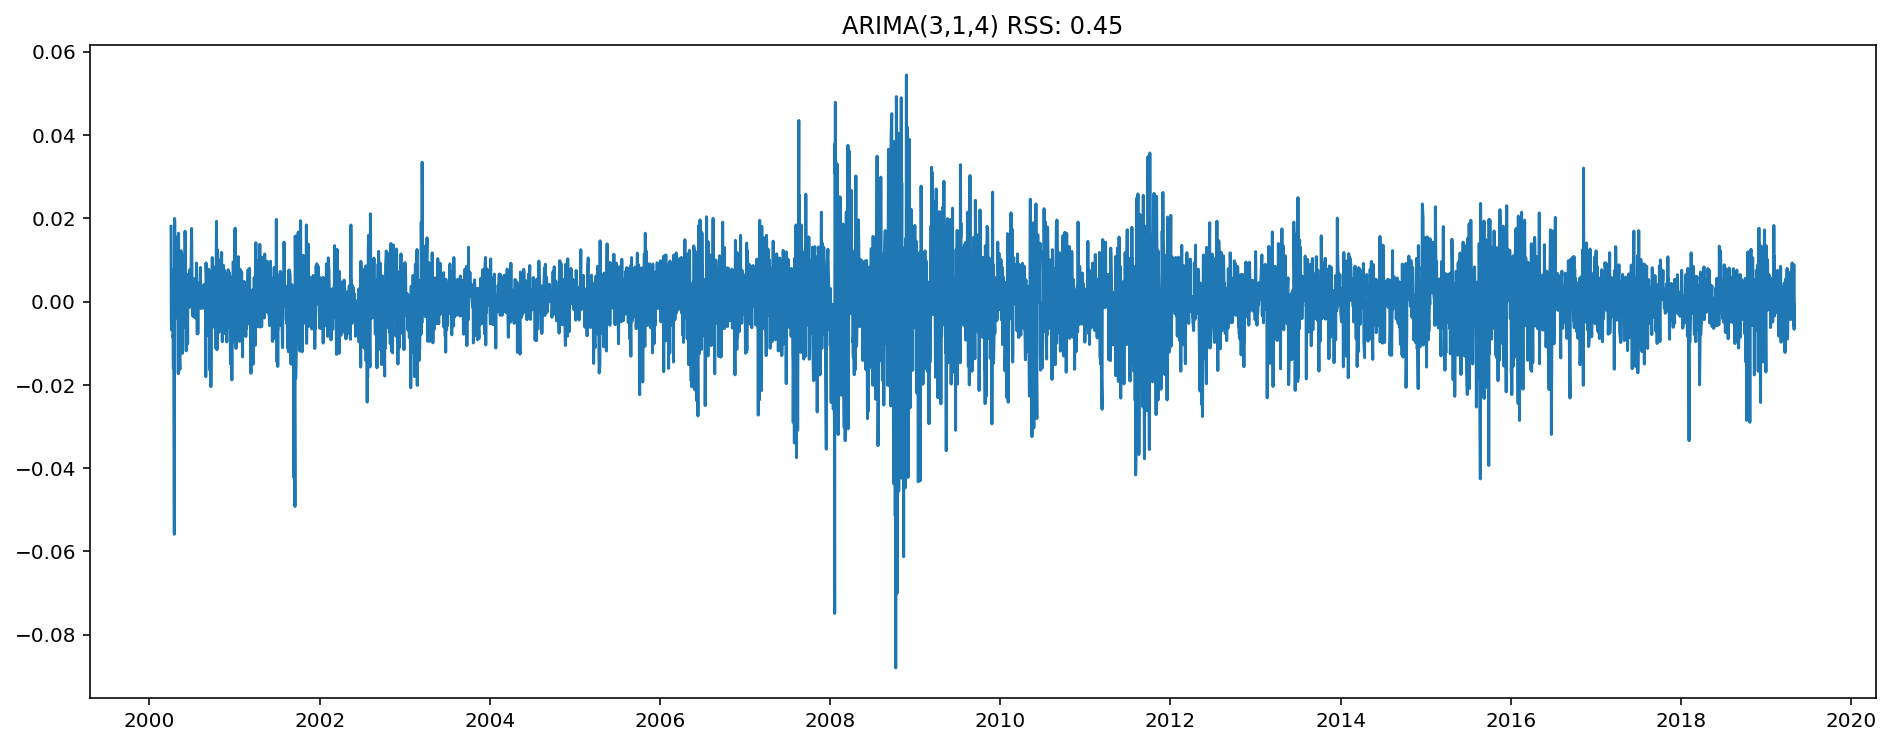

In [36]:
residuals = pd.DataFrame(results_AIC_ARIMA.resid) 

# check the residual
plt.figure() 
plt.plot(residuals)
plt.title('ARIMA(3,1,4) RSS: %.2f'% sum((results_AIC_ARIMA.resid.values)**2)); # residual sum of square

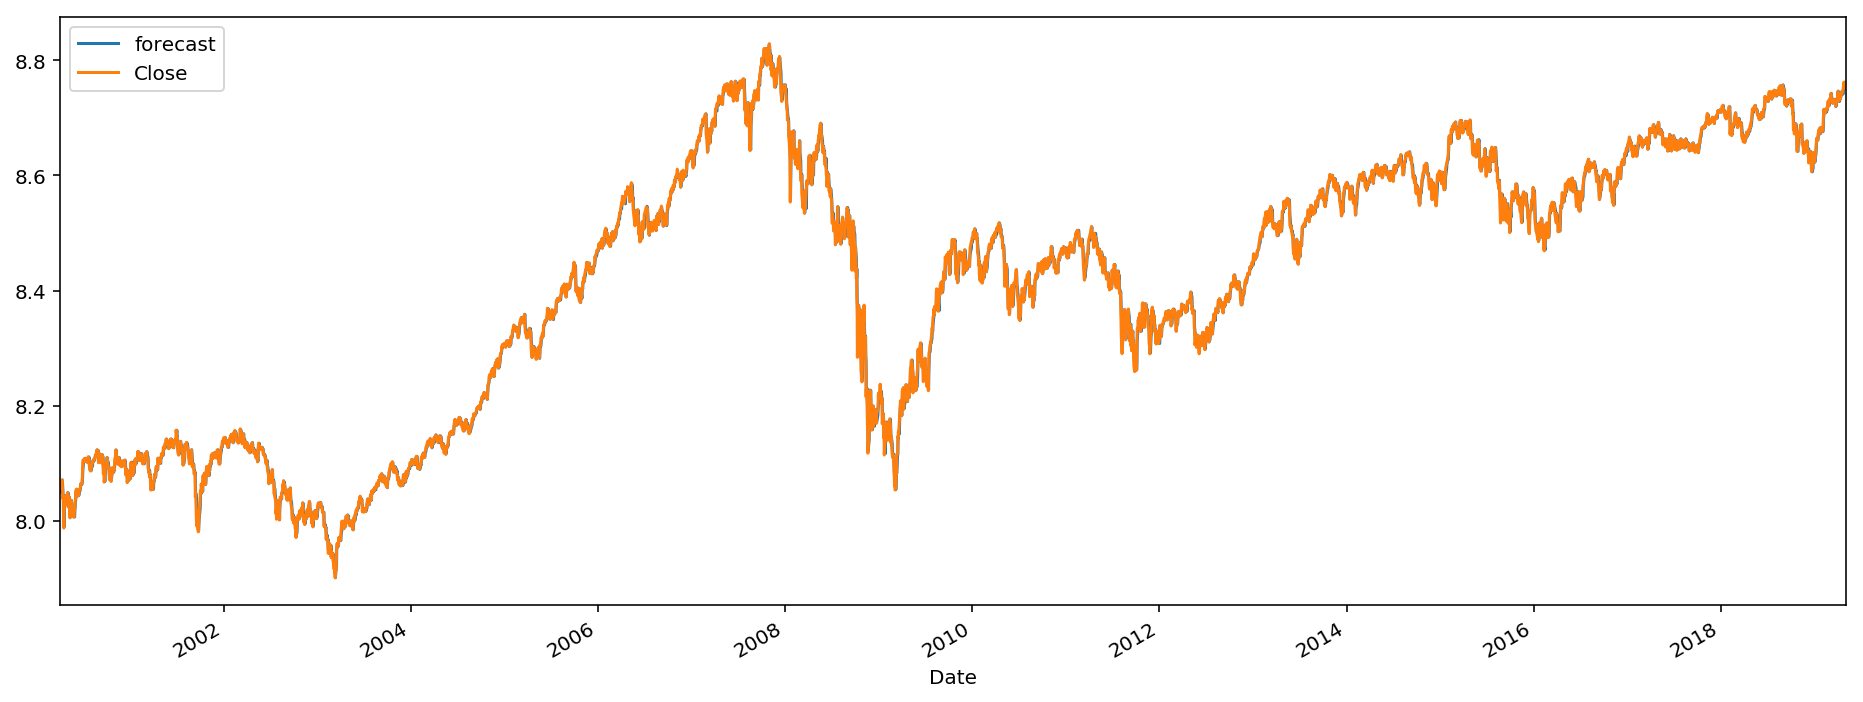

In [37]:
fitted_log = results_AIC_ARIMA.predict(typ = 'levels', dynamic = False)

# Actual vs Fitted 
results_AIC_ARIMA.plot_predict(dynamic = False) 
plt.show()

In [38]:
fitted = np.exp(fitted_log)

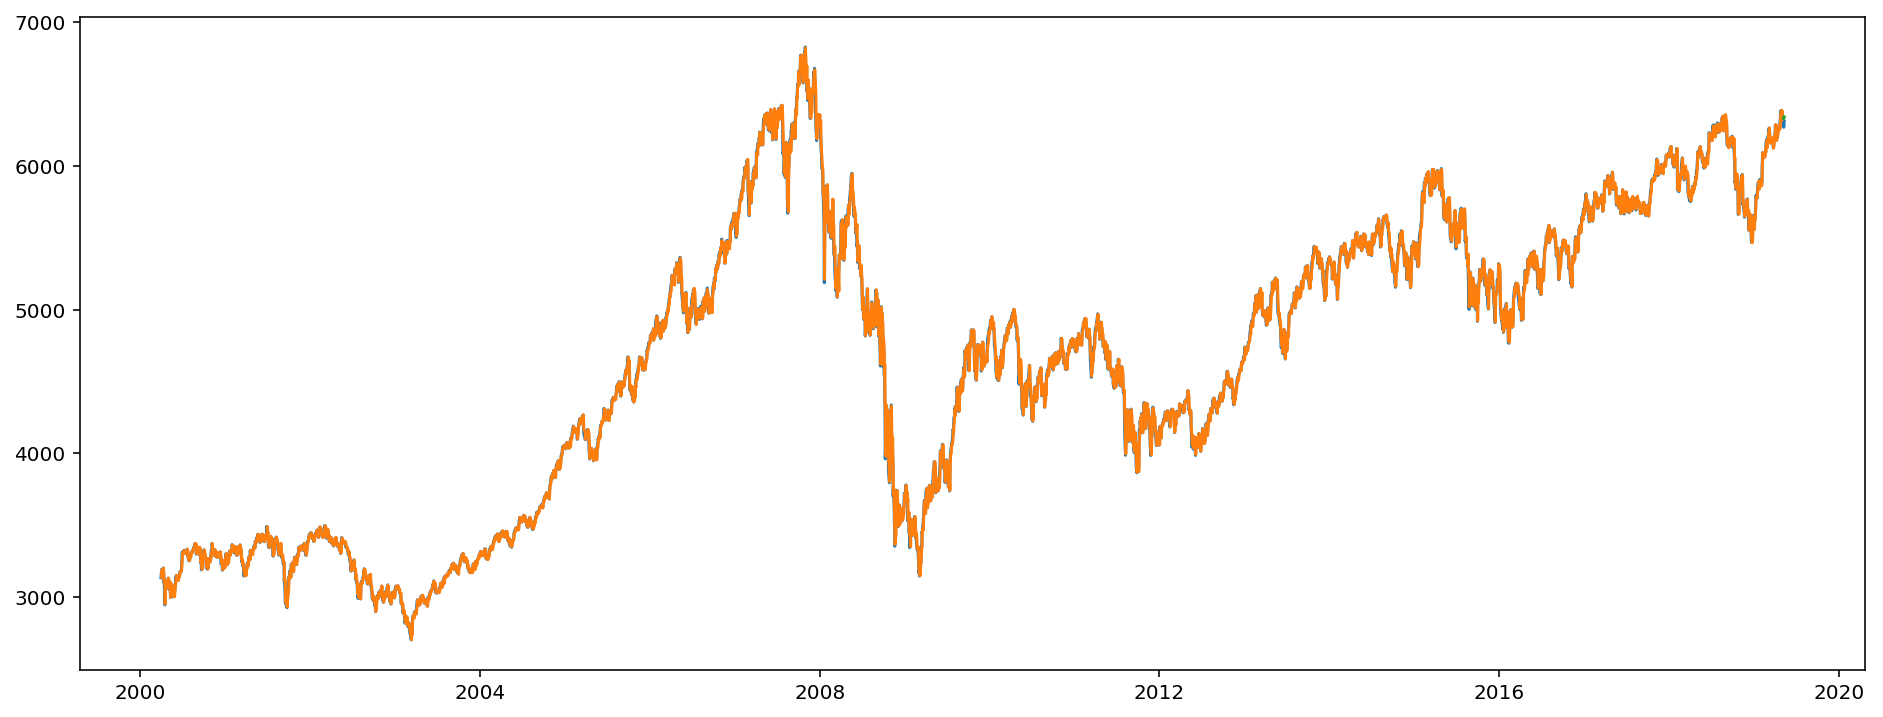

In [39]:
forecast, stderr, conf_int = results_AIC_ARIMA.forecast(steps = validation_size)
forecast_set = pd.Series(np.exp(forecast), index = validation_close_daily.index)
plt.figure()
plt.plot(close_daily)
plt.plot(fitted)
plt.plot(forecast_set)
plt.show()

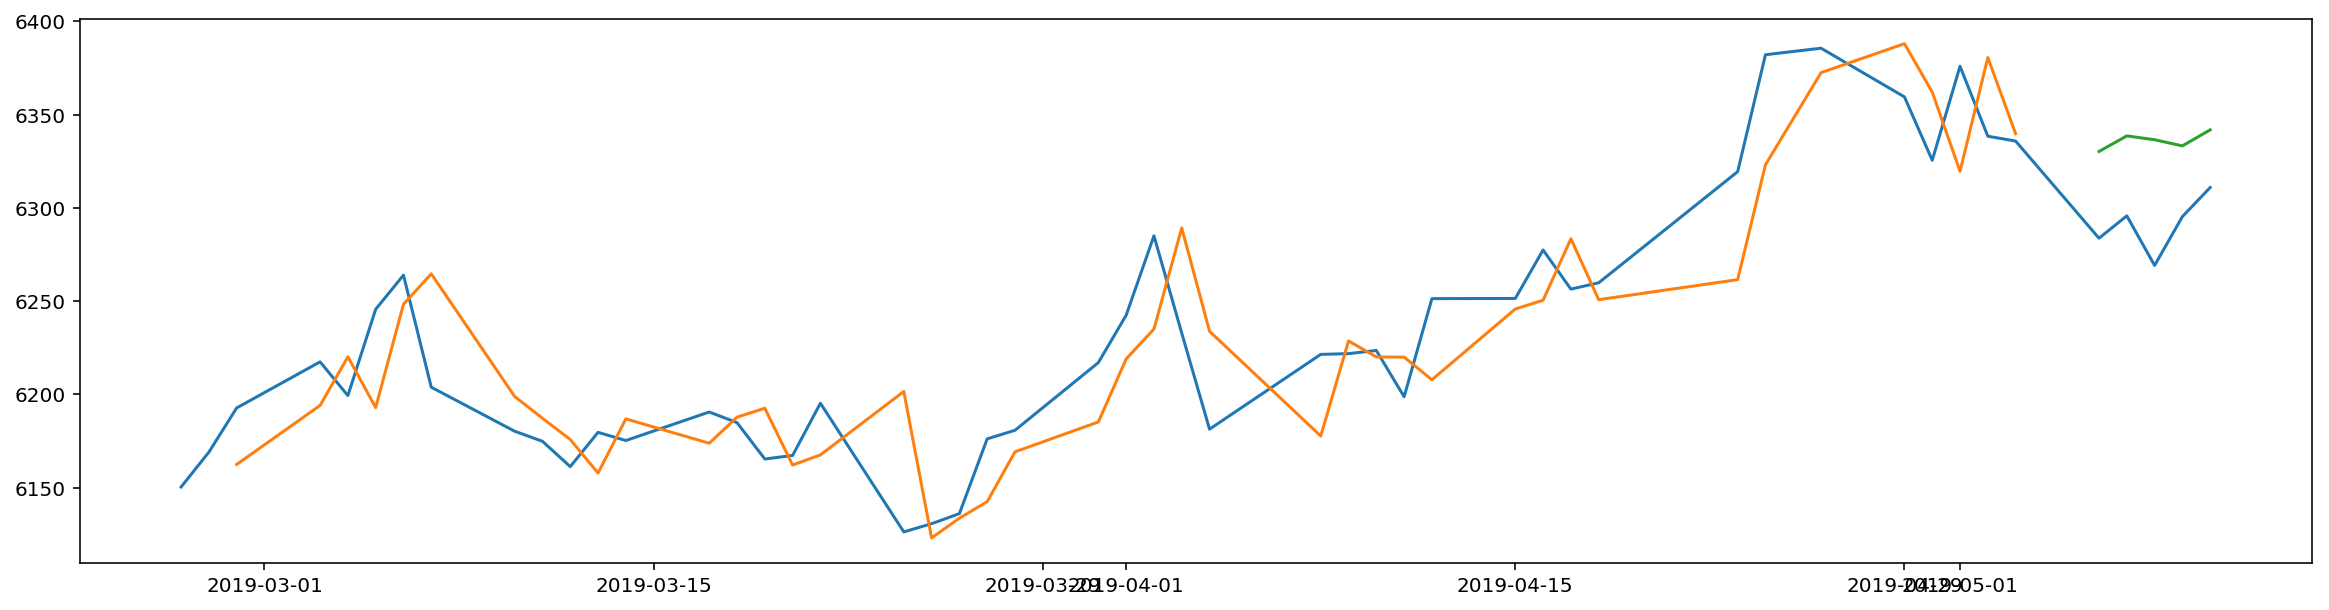

In [40]:
plt.figure(figsize = (20,5))
plt.plot(close_daily[-50:])
plt.plot(fitted[-43:])
plt.plot(forecast_set);

MSE of train set for ARIMA
2061.94


In [42]:
print("MSE of test set for ARIMA\n{:.2f}".format(mse(forecast_set,validation_set)))

MSE of test set for ARIMA
2188.27


### Deep Neural Networks

In [43]:
# Deep Neural Networks and Recurrent Neural Networks
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.layers.core import Dense
from keras.models import Sequential
#from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
np.random.seed(0)

Using TensorFlow backend.


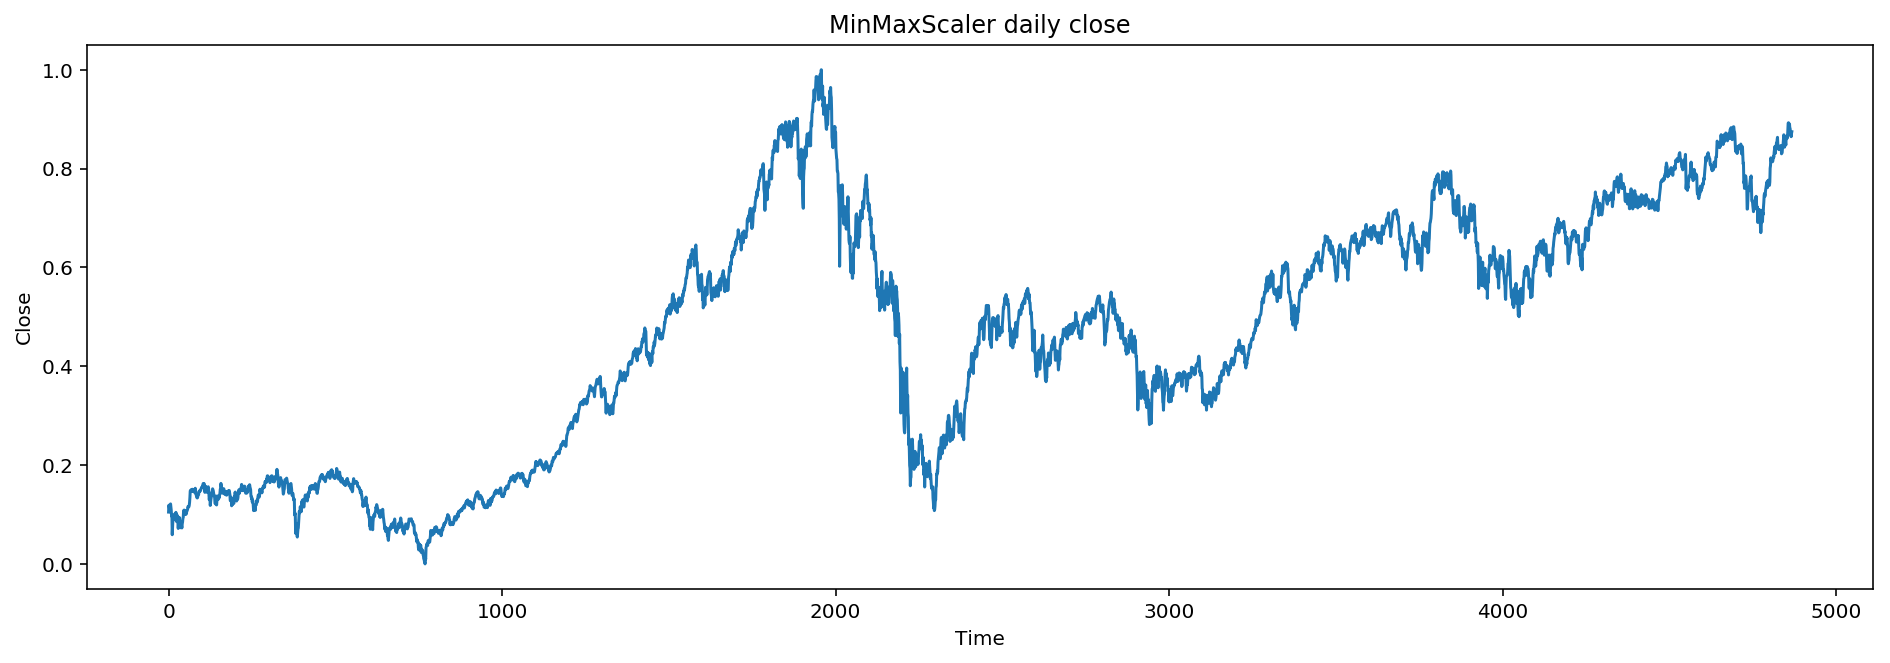

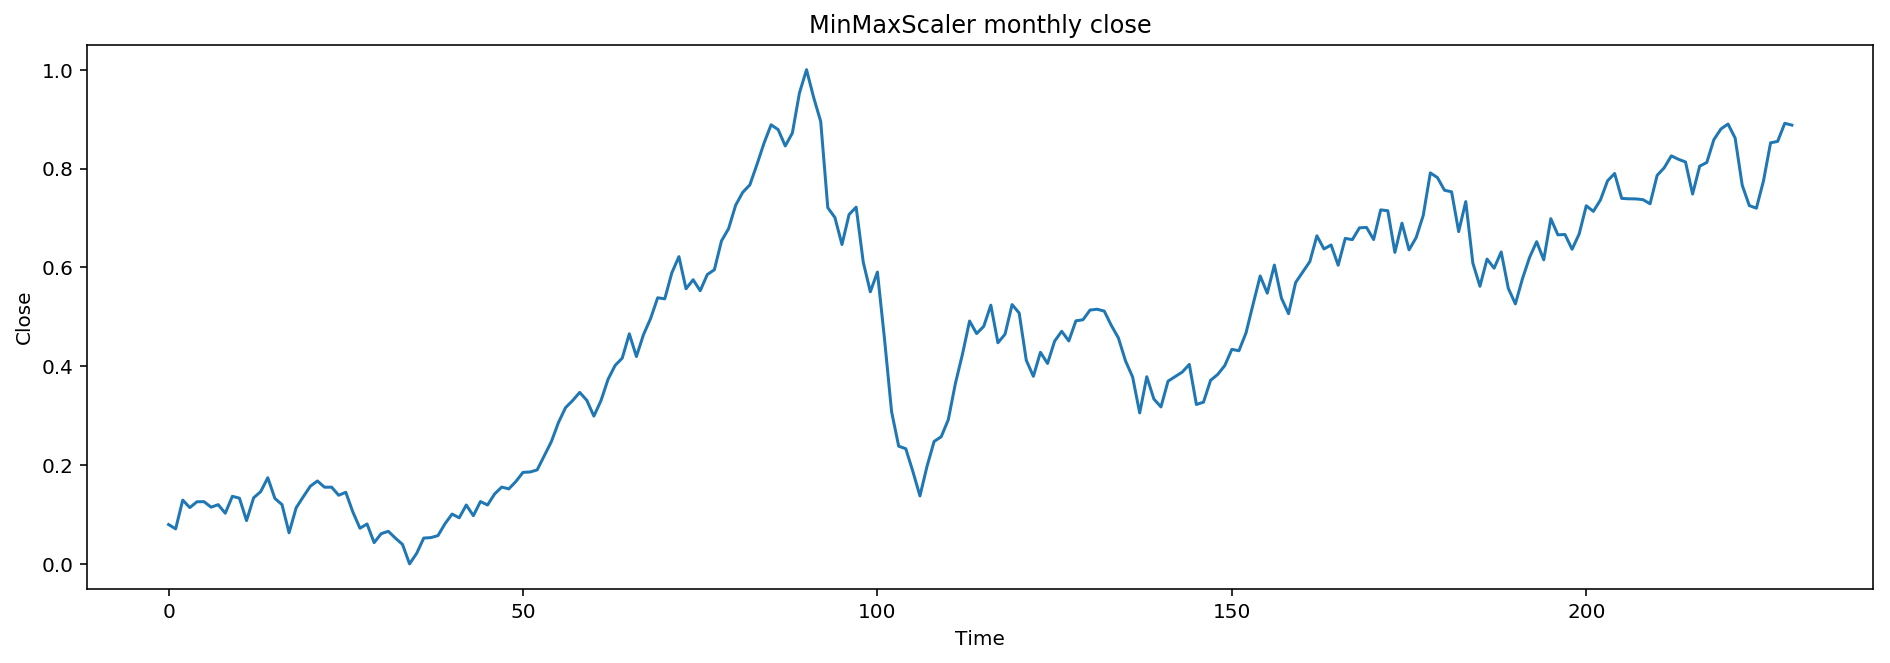

In [91]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
close_daily_normalize = scaler.fit_transform(close_daily.values.reshape(-1,1))
close_monthly_normalize = scaler.fit_transform(close_monthly.values.reshape(-1,1))

plt.figure(figsize = (16,5))
plt.plot(close_daily_normalize)
plt.title("MinMaxScaler daily close")
plt.xlabel("Time")
plt.ylabel("Close");


plt.figure(figsize = (16,5))
plt.plot(close_monthly_normalize)
plt.title("MinMaxScaler monthly close")
plt.xlabel("Time")
plt.ylabel("Close");

In [95]:
data = close_daily_normalize
time_window = 2
Xall, Yall = [], []
for i in range(time_window, len(data)):
    Xall.append(data[i-time_window:i, 0])
    Yall.append(data[i, 0])
    
Xall = np.array(Xall) # Convert them from list to array
Yall = np.array(Yall)
test_size = 5
train_size =  len(Xall) - test_size

Xtrain = Xall[:train_size, :]
Ytrain = Yall[:train_size]
Xtest = Xall[-test_size:, :]
Ytest = Yall[-test_size:]

In [89]:
Xall.shape

(228, 2)

In [96]:
# model = Sequential()
# model.add(Dense(20, input_dim=time_window,activation='relu'))
# model.add(Dense(1))

def create_model():
# create model
    model = Sequential()
    model.add(Dense(20, input_dim=time_window,activation='relu'))
    model.add(Dense(1))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam',metrics=["accuracy"])
    return model

In [98]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasRegressor

model = KerasRegressor(build_fn=create_model, verbose=2)

#batch_size = [1,2,5, 10, 20, 40, 60, 80, 100]
batch_size = [50, 100,200,256]
epochs = [10, 50, 100,500]
param_grid = dict(batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1,cv = 5)

grid_result = grid.fit(Xtrain, Ytrain)

Epoch 1/500
 - 0s - loss: 0.0855 - acc: 4.1144e-04
Epoch 2/500
 - 0s - loss: 0.0069 - acc: 4.1144e-04
Epoch 3/500
 - 0s - loss: 5.0591e-04 - acc: 4.1144e-04
Epoch 4/500
 - 0s - loss: 2.1951e-04 - acc: 4.1144e-04
Epoch 5/500
 - 0s - loss: 1.7799e-04 - acc: 4.1144e-04
Epoch 6/500
 - 0s - loss: 1.6611e-04 - acc: 4.1144e-04
Epoch 7/500
 - 0s - loss: 1.5780e-04 - acc: 4.1144e-04
Epoch 8/500
 - 0s - loss: 1.5295e-04 - acc: 4.1144e-04
Epoch 9/500
 - 0s - loss: 1.5222e-04 - acc: 4.1144e-04
Epoch 10/500
 - 0s - loss: 1.4662e-04 - acc: 4.1144e-04
Epoch 11/500
 - 0s - loss: 1.5259e-04 - acc: 4.1144e-04
Epoch 12/500
 - 0s - loss: 1.4690e-04 - acc: 4.1144e-04
Epoch 13/500
 - 0s - loss: 1.4337e-04 - acc: 4.1144e-04
Epoch 14/500
 - 0s - loss: 1.4142e-04 - acc: 4.1144e-04
Epoch 15/500
 - 0s - loss: 1.4078e-04 - acc: 4.1144e-04
Epoch 16/500
 - 0s - loss: 1.3876e-04 - acc: 4.1144e-04
Epoch 17/500
 - 0s - loss: 1.3870e-04 - acc: 4.1144e-04
Epoch 18/500
 - 0s - loss: 1.3847e-04 - acc: 4.1144e-04
Epoch 19/

In [99]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.000125 using {'batch_size': 50, 'epochs': 500}
-0.000999 (0.001536) with: {'batch_size': 50, 'epochs': 10}
-0.000201 (0.000189) with: {'batch_size': 50, 'epochs': 50}
-0.000161 (0.000084) with: {'batch_size': 50, 'epochs': 100}
-0.000125 (0.000077) with: {'batch_size': 50, 'epochs': 500}
-0.003739 (0.006719) with: {'batch_size': 100, 'epochs': 10}
-0.000164 (0.000075) with: {'batch_size': 100, 'epochs': 50}
-0.000141 (0.000093) with: {'batch_size': 100, 'epochs': 100}
-0.000126 (0.000077) with: {'batch_size': 100, 'epochs': 500}
-0.013164 (0.014935) with: {'batch_size': 200, 'epochs': 10}
-0.000204 (0.000103) with: {'batch_size': 200, 'epochs': 50}
-0.000342 (0.000367) with: {'batch_size': 200, 'epochs': 100}
-0.000145 (0.000062) with: {'batch_size': 200, 'epochs': 500}
-0.002927 (0.001876) with: {'batch_size': 256, 'epochs': 10}
-0.000155 (0.000110) with: {'batch_size': 256, 'epochs': 50}
-0.000149 (0.000093) with: {'batch_size': 256, 'epochs': 100}
-0.000133 (0.000089) with:

In [100]:
model = Sequential()
model.add(Dense(20, input_dim=time_window,activation='relu'))
model.add(Dense(1))



In [129]:
batch_size_daily = grid_result.best_params_['batch_size']
epochs_daily = grid_result.best_params_["epochs"]

In [102]:
model.compile(loss='mean_squared_error',optimizer='adam')
model.fit(Xtrain, Ytrain, epochs=epochs_daily, batch_size=batch_size_daily,verbose=2, validation_split=0.05)

Train on 4617 samples, validate on 244 samples
Epoch 1/500
 - 0s - loss: 0.2024 - val_loss: 0.1262
Epoch 2/500
 - 0s - loss: 0.0178 - val_loss: 0.0187
Epoch 3/500
 - 0s - loss: 0.0045 - val_loss: 0.0057
Epoch 4/500
 - 0s - loss: 9.1381e-04 - val_loss: 0.0014
Epoch 5/500
 - 0s - loss: 2.9415e-04 - val_loss: 4.2733e-04
Epoch 6/500
 - 0s - loss: 2.1669e-04 - val_loss: 2.5955e-04
Epoch 7/500
 - 0s - loss: 1.9765e-04 - val_loss: 3.0373e-04
Epoch 8/500
 - 0s - loss: 1.9268e-04 - val_loss: 2.2724e-04
Epoch 9/500
 - 0s - loss: 1.8566e-04 - val_loss: 2.0182e-04
Epoch 10/500
 - 0s - loss: 1.8265e-04 - val_loss: 1.8767e-04
Epoch 11/500
 - 0s - loss: 1.8006e-04 - val_loss: 2.1706e-04
Epoch 12/500
 - 0s - loss: 1.7741e-04 - val_loss: 1.9462e-04
Epoch 13/500
 - 0s - loss: 1.7527e-04 - val_loss: 1.7197e-04
Epoch 14/500
 - 0s - loss: 1.7312e-04 - val_loss: 1.9027e-04
Epoch 15/500
 - 0s - loss: 1.7171e-04 - val_loss: 1.9051e-04
Epoch 16/500
 - 0s - loss: 1.6832e-04 - val_loss: 1.4563e-04
Epoch 17/500
 

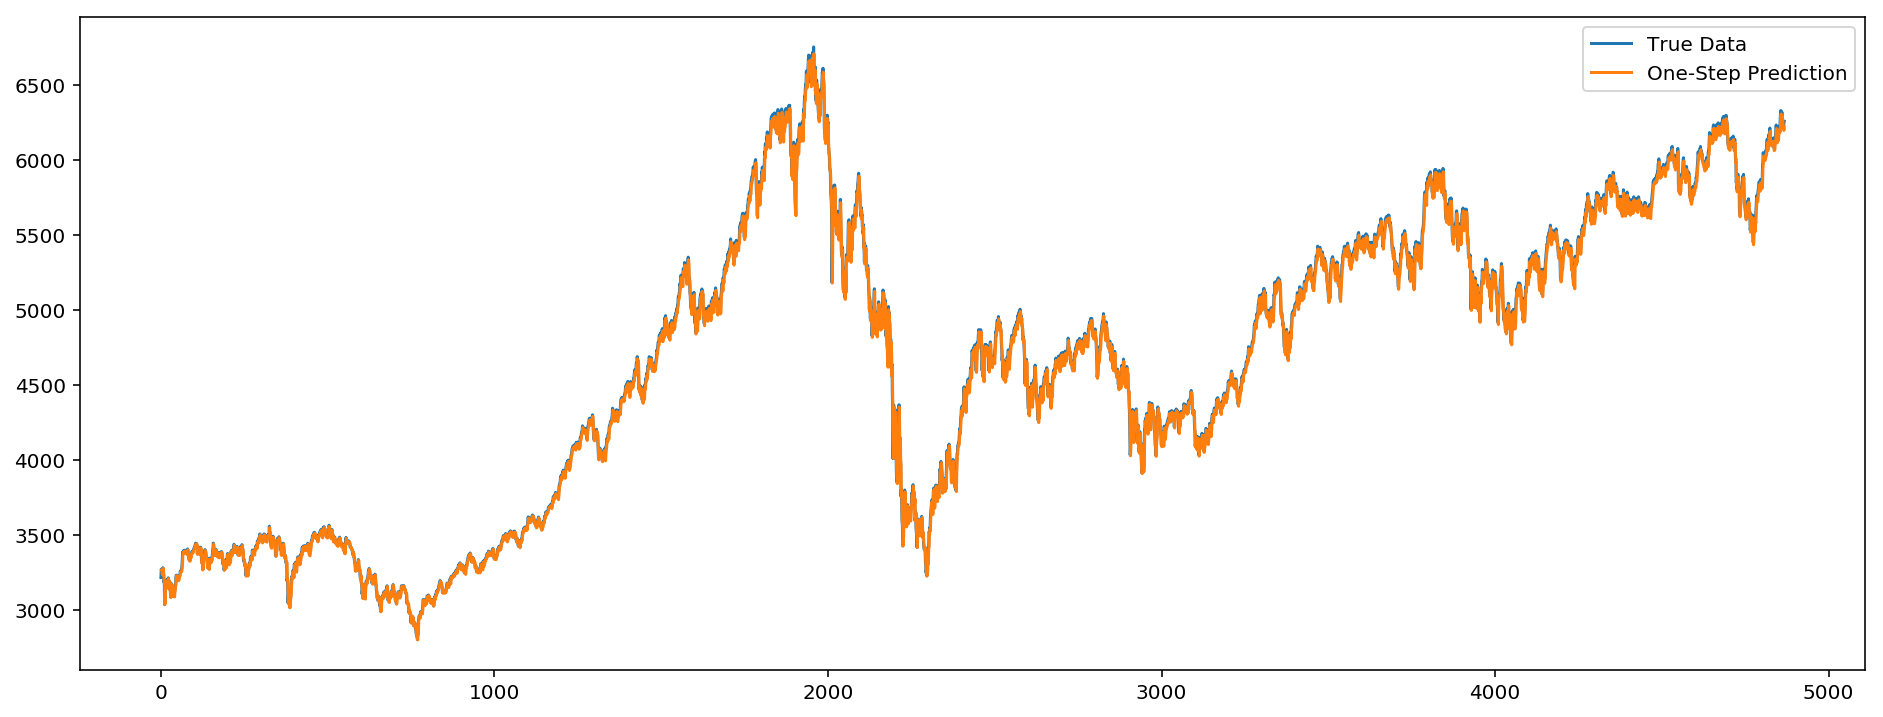

In [103]:
allPredict = model.predict(Xall)
allPredictPlot = scaler.inverse_transform(allPredict)
plt.figure()
plt.plot(scaler.inverse_transform(data), label='True Data')
plt.plot(np.arange(time_window, len(data)),allPredictPlot, label='One-Step Prediction')
plt.legend();

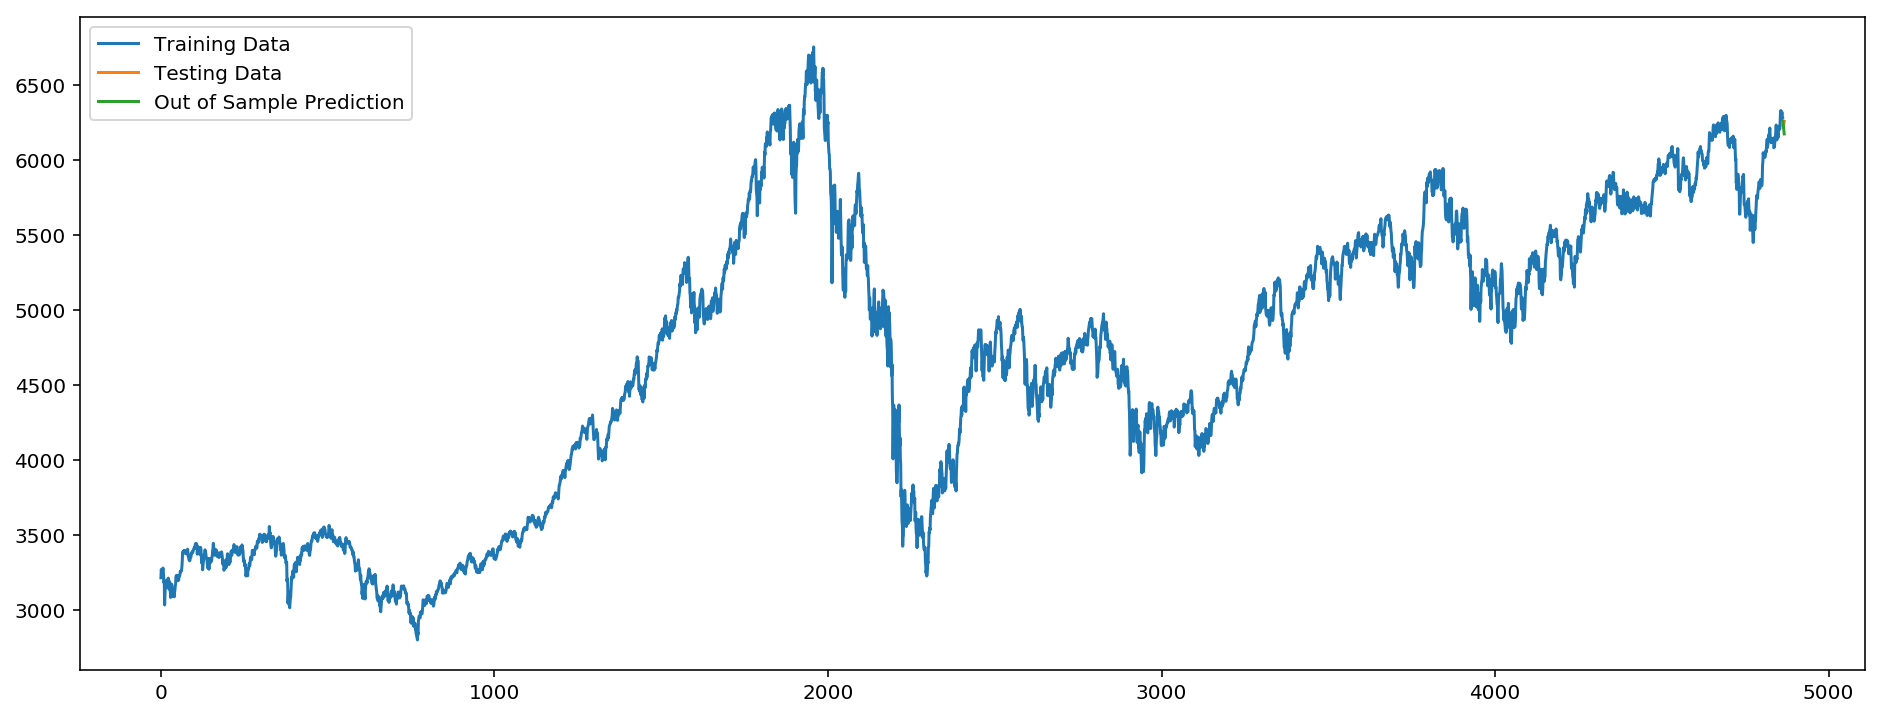

In [104]:
dynamic_prediction = np.copy(data[:len(data) - test_size])
for i in range(len(data) - test_size, len(data)):
    last_feature = np.reshape(dynamic_prediction[i-time_window:i], (1,time_window))
    next_pred = model.predict(last_feature)
    dynamic_prediction = np.append(dynamic_prediction, next_pred)
    
dynamic_prediction = dynamic_prediction.reshape(-1,1)
dynamic_prediction = scaler.inverse_transform(dynamic_prediction)

plt.figure()
plt.plot(scaler.inverse_transform(data[:len(data) - test_size]), label='Training Data')
plt.plot(np.arange(len(data) - test_size, len(data), 1),scaler.inverse_transform(data[-test_size:]), label='Testing Data')
plt.plot(np.arange(len(data) - test_size, len(data), 1), dynamic_prediction[-test_size:], label='Out of Sample Prediction')
plt.legend(loc = "upper left")
plt.show()

<function matplotlib.pyplot.show(*args, **kw)>

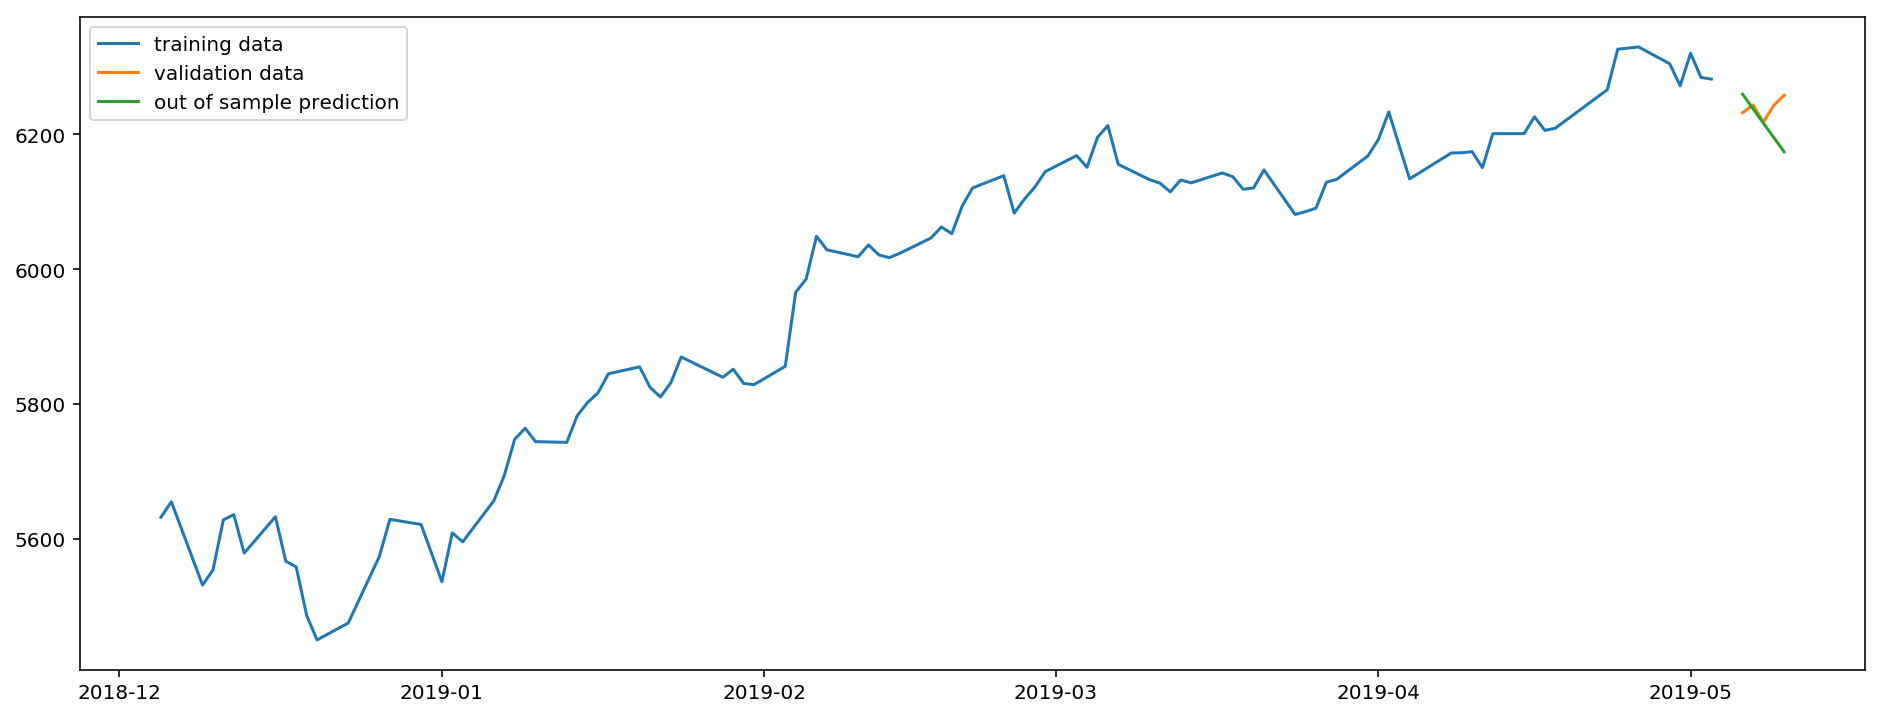

In [105]:
a = pd.DataFrame(scaler.inverse_transform(data[:len(data) - test_size]))
a.index = train_close_daily.index

b = pd.DataFrame(scaler.inverse_transform(data[-test_size:]))
b.index = validation_close_daily.index

c = pd.DataFrame(dynamic_prediction[-test_size:])
c.index = validation_close_daily.index


plt.figure()
plt.plot(a.iloc[-100:,:], label='training data')
plt.plot(b, label='validation data')
plt.plot(c, label='out of sample prediction')
plt.legend()
plt.show

In [106]:
Ytest
dynamic_prediction[-test_size:]

array([[6259.73164533],
       [6238.18925547],
       [6216.74677234],
       [6195.428937  ],
       [6174.23386442]])

In [107]:
Ytrain_ = scaler.inverse_transform(Ytrain.reshape(-1, 1))
allPredict_ = scaler.inverse_transform(allPredict[:train_size,0].reshape(-1, 1))
print("MSE of train set for NN\n{:.2f}".format(mse(Ytrain_,allPredict_)))

MSE of train set for NN
2099.73


In [108]:
testScore = mse(scaler.inverse_transform(Ytest.reshape(-1, 1)),dynamic_prediction[-test_size:])
print('Dynamic Forecast MSE: {0:.2f}'.format(testScore))

Dynamic Forecast MSE: 2028.88


### Monthly

In [55]:
validation_size = 5
train_size = len(close_monthly) - validation_size

In [56]:
train_close_monthly = close_monthly[:-validation_size]
validation_close_monthly  =  close_monthly[-validation_size:]
validate_time = validation_close_monthly.index[0]

In [57]:
len(train_close_monthly)

225

In [58]:
validation_close_monthly

Date
2018-12-31    5864.700195
2019-01-31    6169.000000
2019-02-28    6180.700195
2019-03-31    6325.500000
2019-04-30    6310.899902
Name: Close, dtype: float64

In [59]:
# Holt linear
from statsmodels.tsa.holtwinters import Holt
fit2 = Holt(train_close_monthly).fit()
smooth_Holt = fit2.fittedvalues


results = pd.DataFrame(index=[r"$\alpha$", 
                              r"$\beta$", 
                              r"$\phi$",  # damped value
                              r"$\gamma$", 
                              r"$l_0$", 
                              "$b_0$", 
                              "SSE"])
params = ['smoothing_level', 
          'smoothing_slope', 
          'damping_slope', 
          'smoothing_seasonal', 
          'initial_level', 
          'initial_slope']

results["Additive"] = [fit2.params[p] for p in params] + [fit2.sse]
results
smooth_Holt




Date
2000-03-31    3115.808716
2000-04-30    3127.097404
2000-05-31    3092.297355
2000-06-30    3322.497306
2000-07-31    3262.397453
2000-08-31    3309.097404
2000-09-30    3310.097404
2000-10-31    3265.897453
2000-11-30    3285.897453
2000-12-31    3217.497306
2001-01-31    3352.997306
2001-02-28    3337.797355
2001-03-31    3158.497306
2001-04-30    3340.697257
2001-05-31    3390.397453
2001-06-30    3501.597404
2001-07-31    3335.797355
2001-08-31    3286.897453
2001-09-30    3060.797355
2001-10-31    3260.897453
2001-11-30    3348.797355
2001-12-31    3433.597404
2002-01-31    3475.497306
2002-02-28    3425.597404
2002-03-31    3426.097404
2002-04-30    3361.297355
2002-05-31    3384.897453
2002-06-30    3227.297355
2002-07-31    3097.497306
2002-08-31    3131.397453
                 ...     
2016-06-30    5244.697257
2016-07-31    5573.597160
2016-08-31    5444.297355
2016-09-30    5447.197257
2016-10-31    5328.997550
2016-11-30    5451.797355
2016-12-31    5677.097160
2017-01

In [60]:
forecast_set = pd.Series(fit2.forecast(validation_size))

forecast_set.index = validation_close_monthly.index
forecast_set

Date
2018-12-31    5657.697257
2019-01-31    5668.994612
2019-02-28    5680.291967
2019-03-31    5691.589322
2019-04-30    5702.886677
dtype: float64

Date
2000-03-31    3115.800049
2000-04-30    3081.000000
2000-05-31    3311.199951
2000-06-30    3251.100098
2000-07-31    3297.800049
2000-08-31    3298.800049
2000-09-30    3254.600098
2000-10-31    3274.600098
2000-11-30    3206.199951
2000-12-31    3341.699951
2001-01-31    3326.500000
2001-02-28    3147.199951
2001-03-31    3329.399902
2001-04-30    3379.100098
2001-05-31    3490.300049
2001-06-30    3324.500000
2001-07-31    3275.600098
2001-08-31    3049.500000
2001-09-30    3249.600098
2001-10-31    3337.500000
2001-11-30    3422.300049
2001-12-31    3464.199951
2002-01-31    3414.300049
2002-02-28    3414.800049
2002-03-31    3350.000000
2002-04-30    3373.600098
2002-05-31    3216.000000
2002-06-30    3086.199951
2002-07-31    3120.100098
2002-08-31    2970.899902
                 ...     
2016-11-30    5665.799805
2016-12-31    5620.899902
2017-01-31    5712.200195
2017-02-28    5864.899902
2017-03-31    5924.100098
2017-04-30    5724.600098
2017-05-31    5721.500000
2017-06

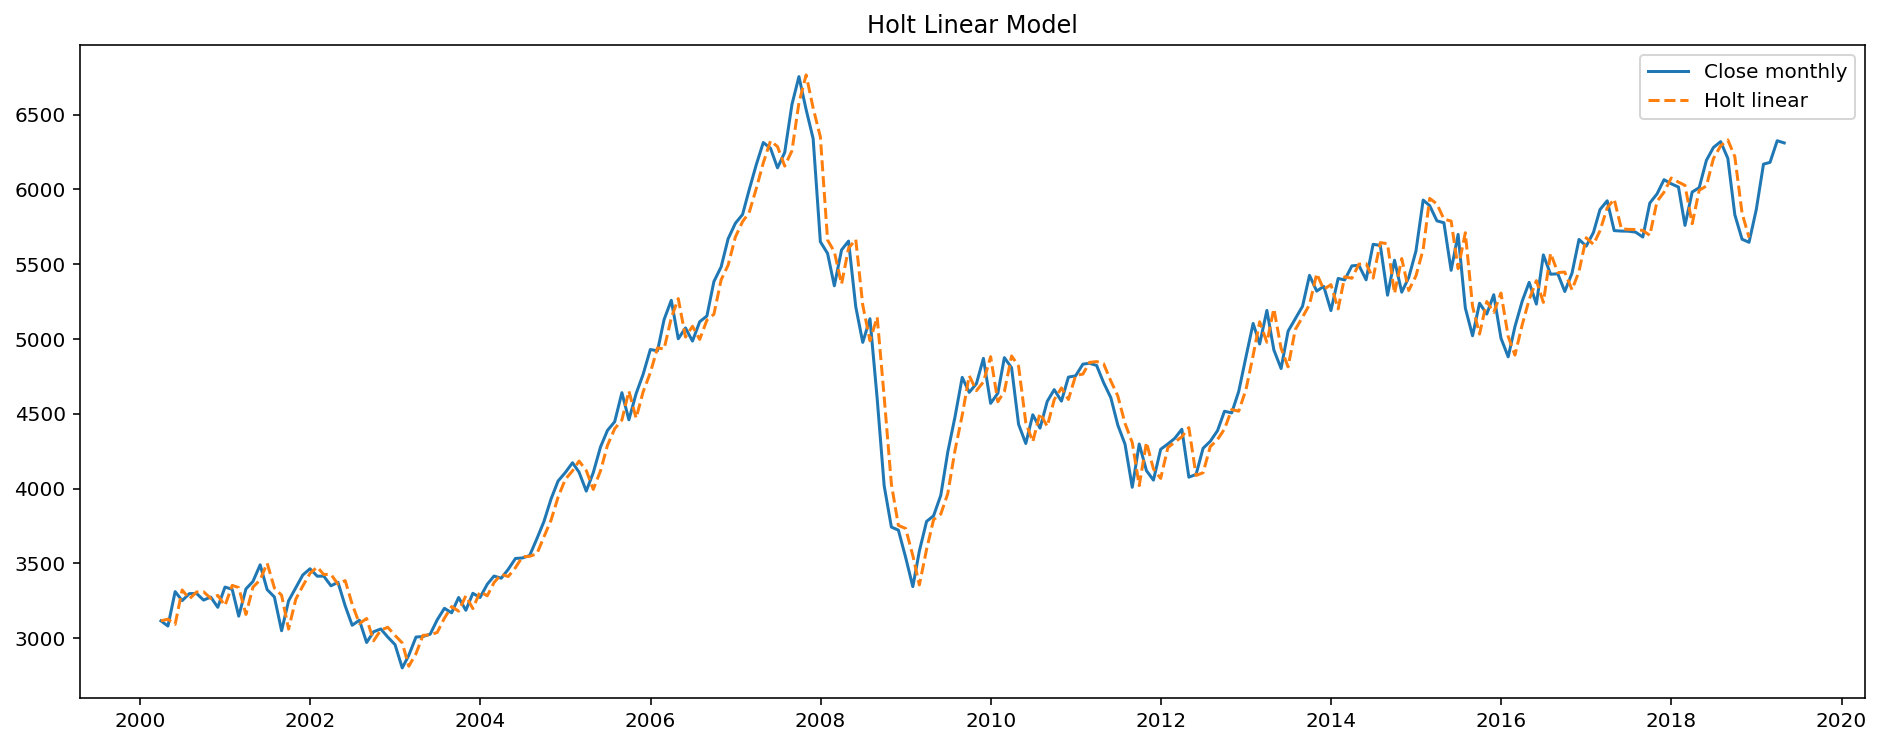

In [61]:
plt.figure()
plt.title('Holt Linear Model')
plt.plot(close_monthly,label='Close monthly')
plt.plot(smooth_Holt,linestyle='--',label='Holt linear')
plt.legend();

close_monthly

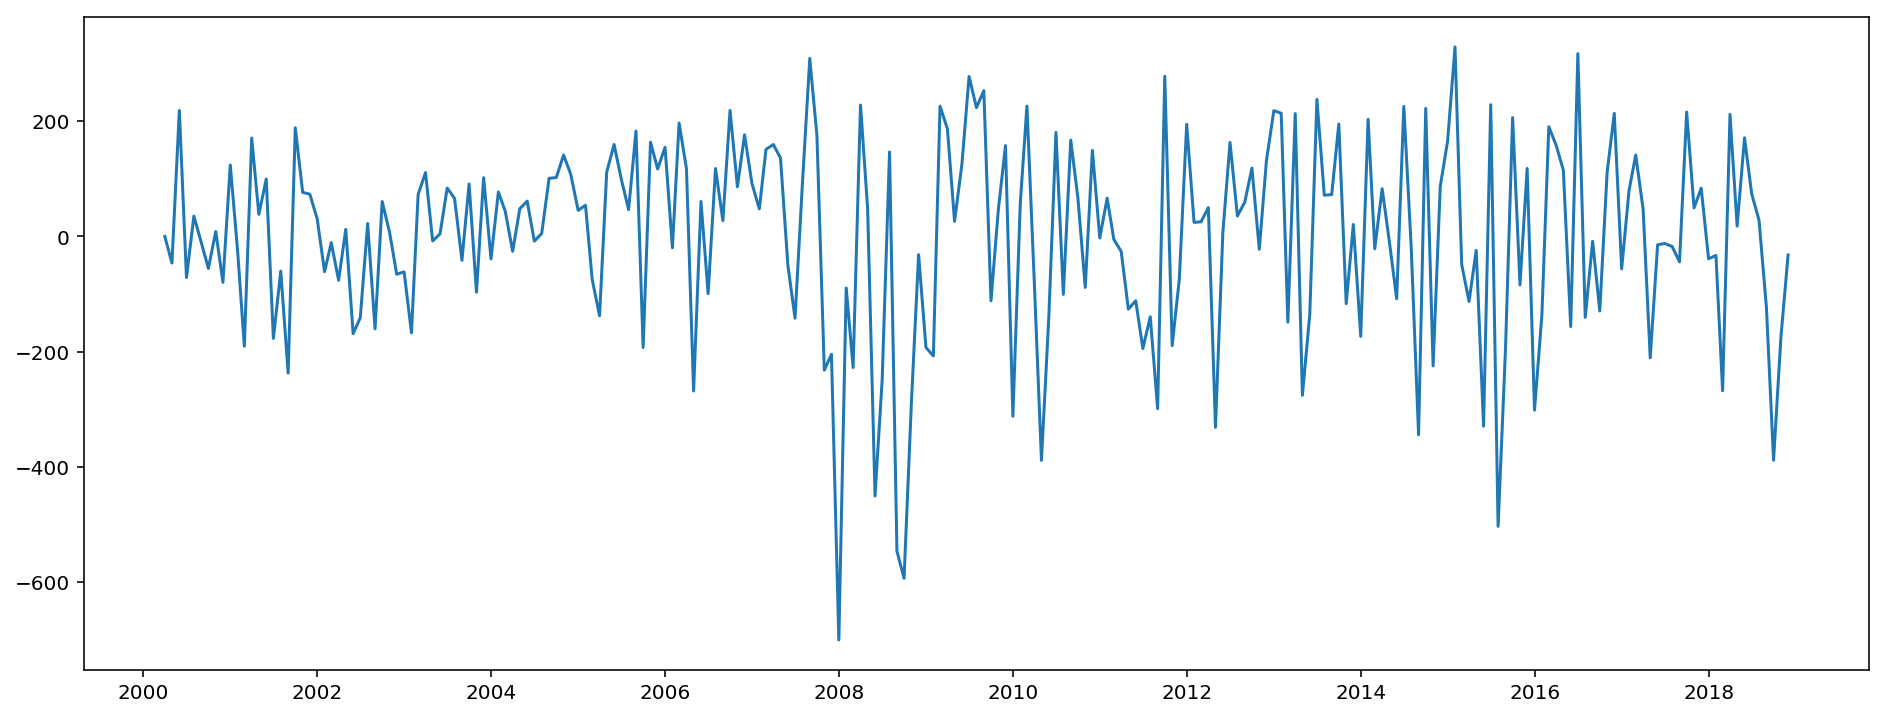

In [62]:
plt.figure()
plt.plot(fit2.resid)
plt.show()

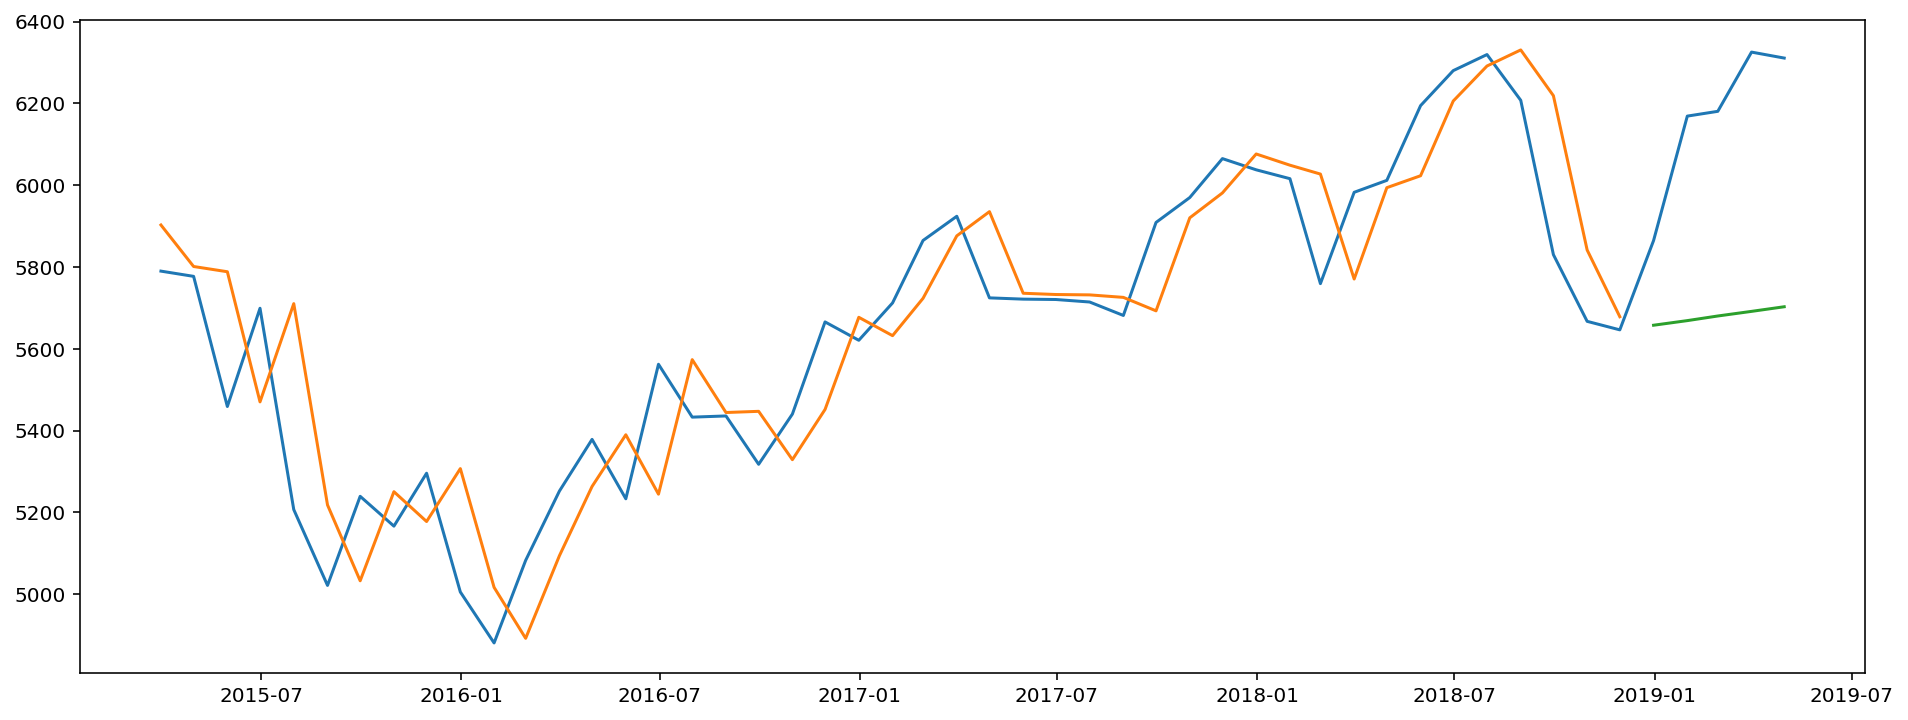

In [63]:
plt.figure()
plt.plot(close_monthly[-50:])
plt.plot(smooth_Holt[-45:])
plt.plot(forecast_set)
plt.show()

In [64]:
print("MSE of train set for HOLT\n{:.2f}".format(mse(smooth_Holt,train_close_monthly)))
validation_set =close_monthly[-validation_size:].values
print("MSE for Holt’s linear method on validation set\n{:.2f}".format(mse(forecast_set,validation_set)))

MSE of train set for HOLT
29465.25
MSE for Holt’s linear method on validation set
262957.37


# ARIMA

In [65]:
#ARIMA
import statsmodels.api as smt
import statsmodels as sm 

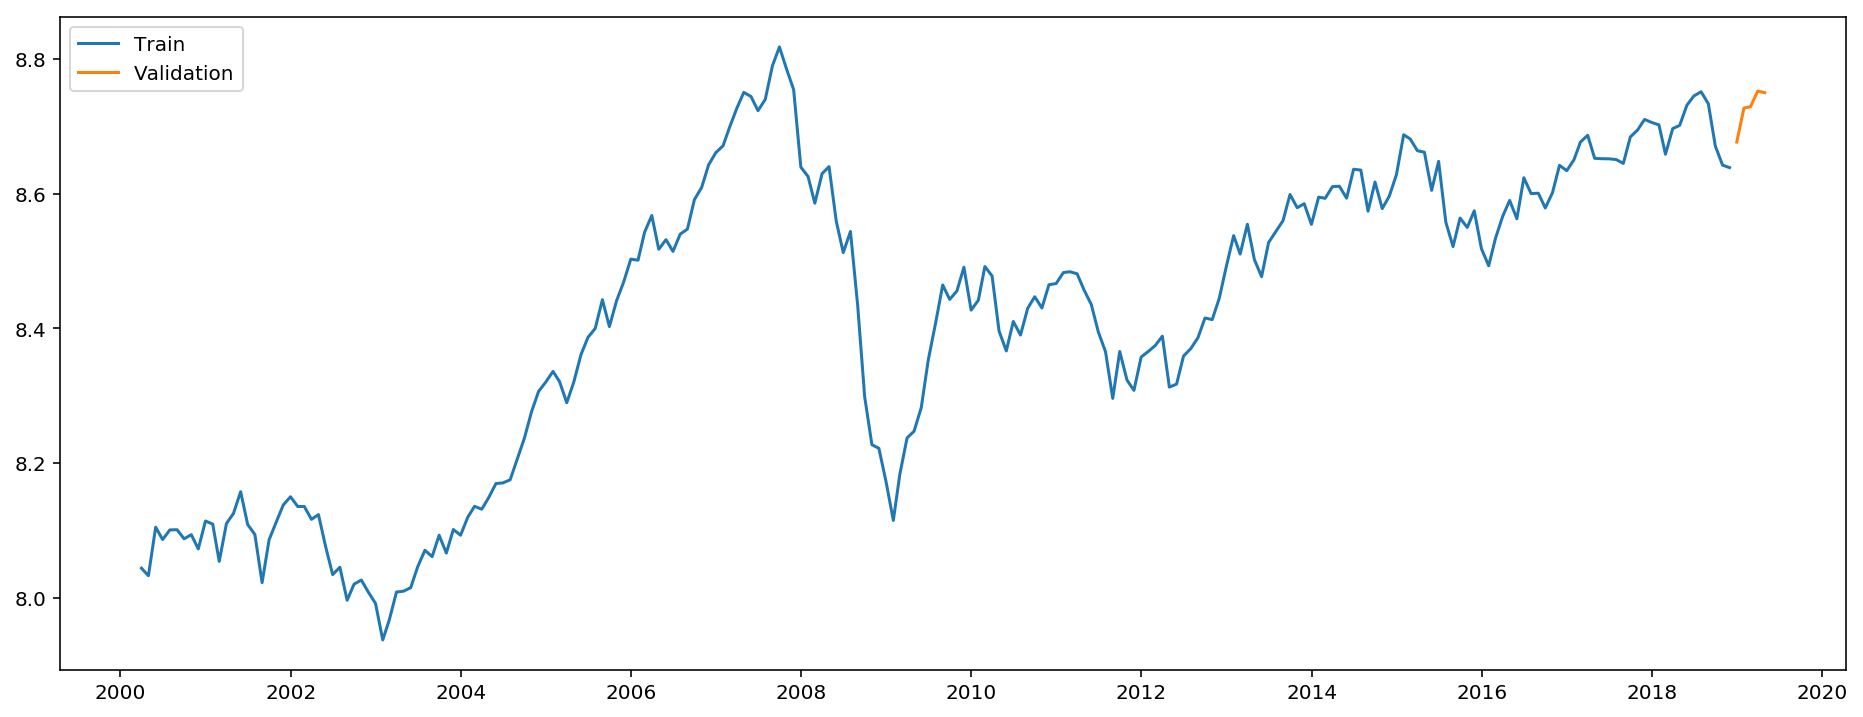

In [66]:
close_monthly_log = np.log(close_monthly)
train_close_monthly_log = np.log(train_close_monthly)
validation_close_monthly_log = np.log(validation_close_monthly)

plt.figure()
plt.plot(train_close_monthly_log,label = "Train")
plt.plot(validation_close_monthly_log,label="Validation")

#plt.axvline(validate_time,0,1)
plt.legend()
plt.show()

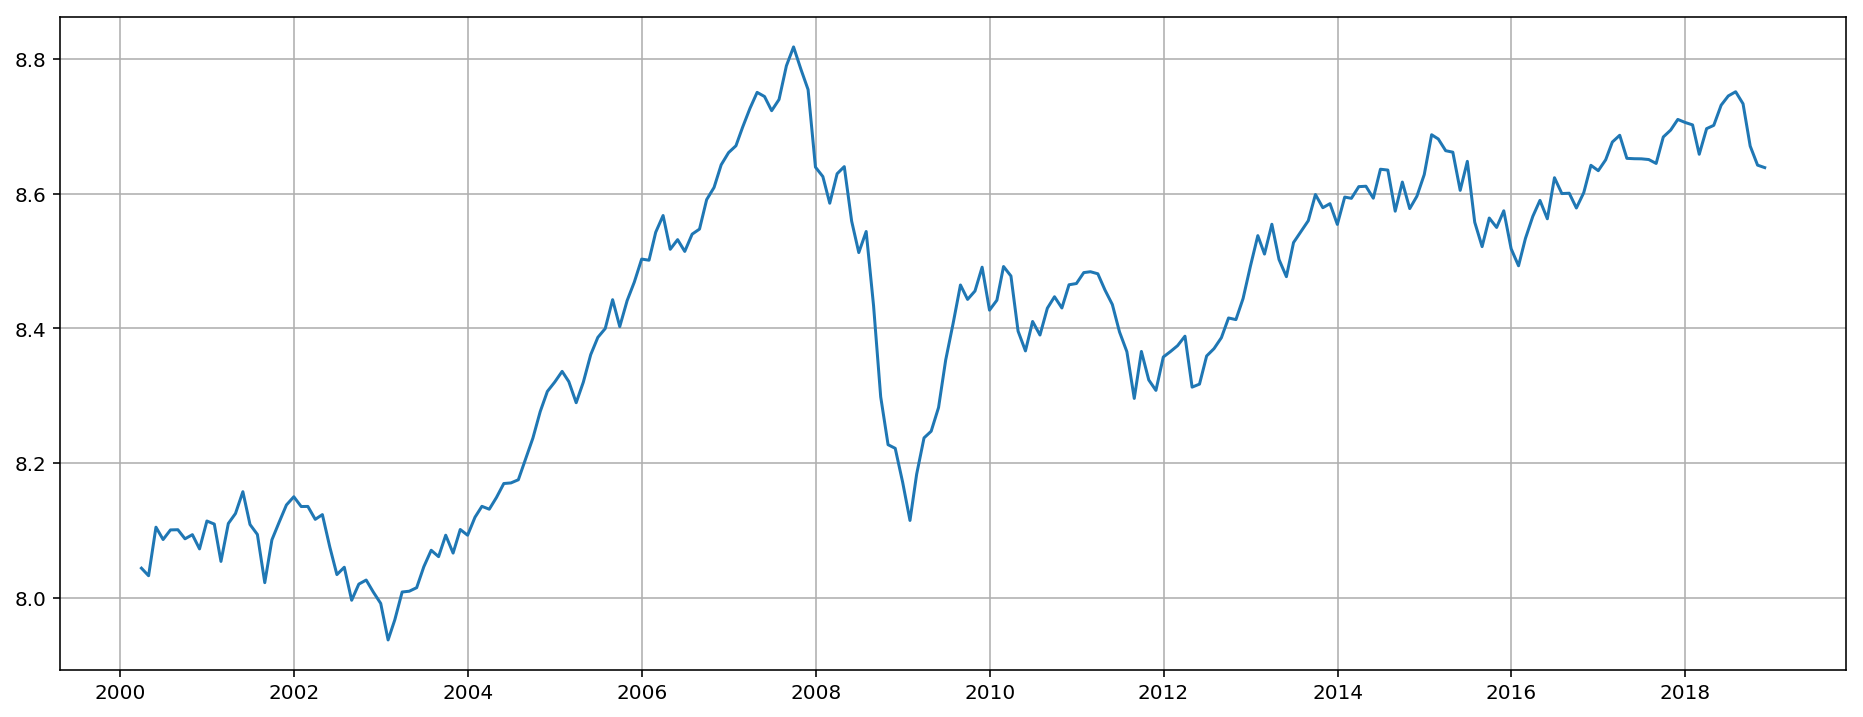

In [67]:
plt.figure()
plt.grid()
plt.plot(train_close_monthly_log);

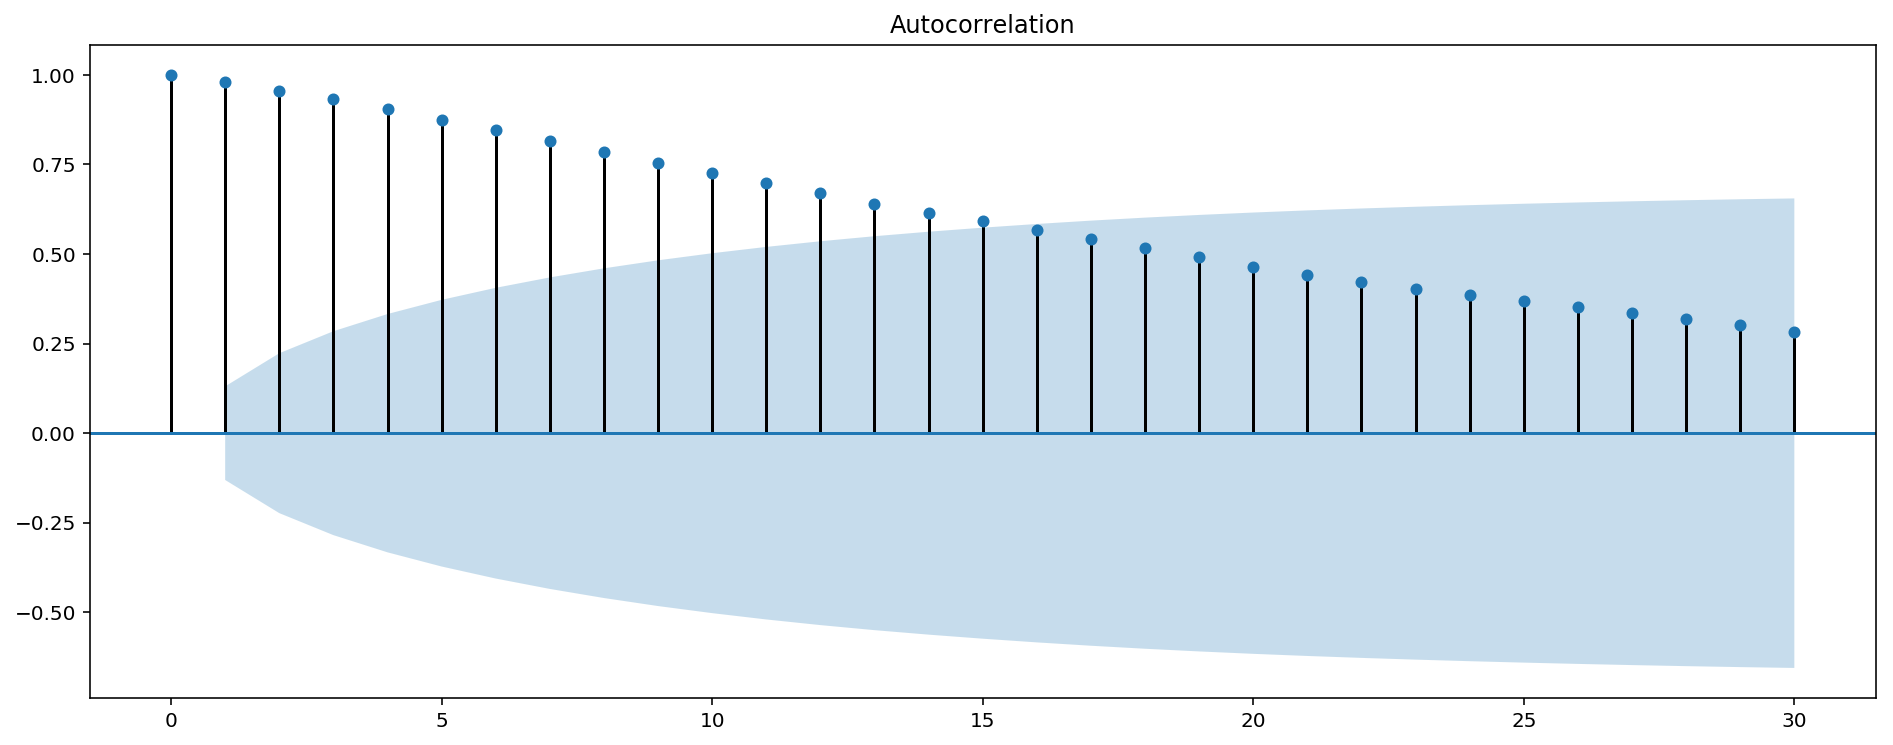

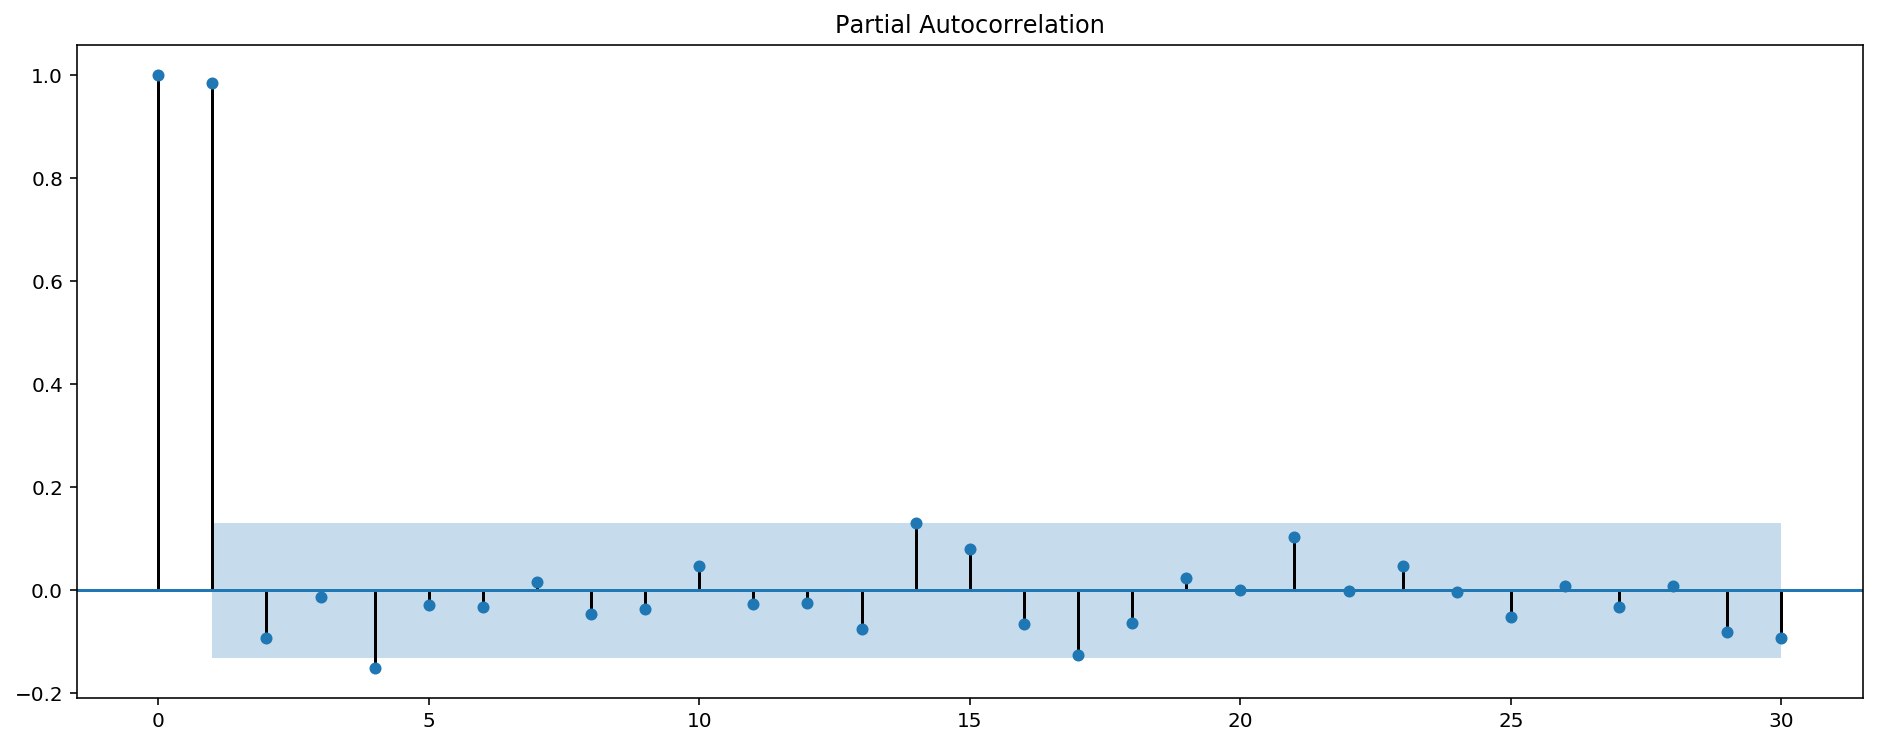

In [68]:
smt.graphics.tsa.plot_acf(train_close_monthly_log, lags=30, alpha = 0.05)
smt.graphics.tsa.plot_pacf(train_close_monthly_log, lags=30, alpha = 0.05)
plt.show()

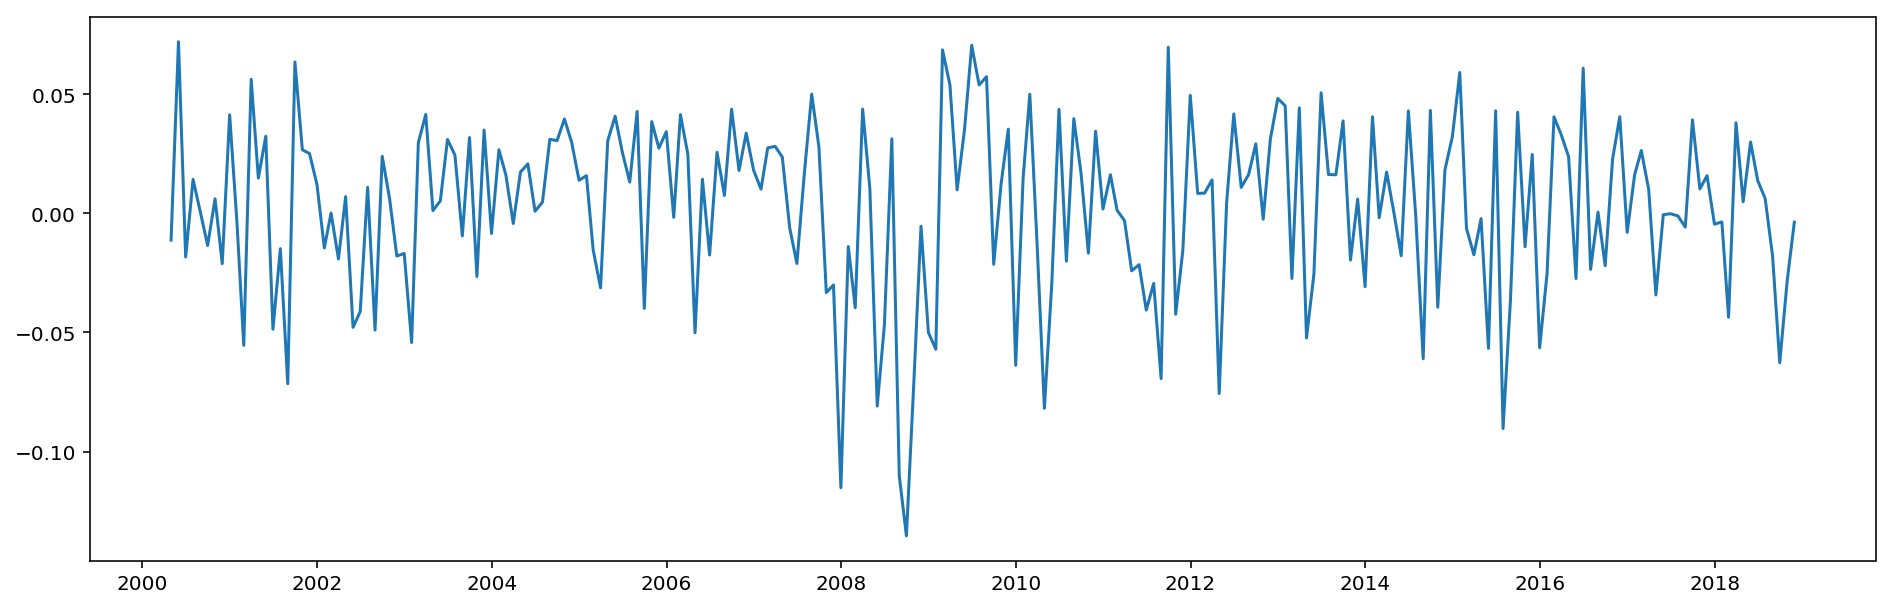

In [69]:
train_close_monthly_log_diff = train_close_monthly_log.diff()
train_close_monthly_log_diff.dropna(inplace = True)
plt.figure(figsize = (16,5))
plt.plot(train_close_monthly_log_diff);

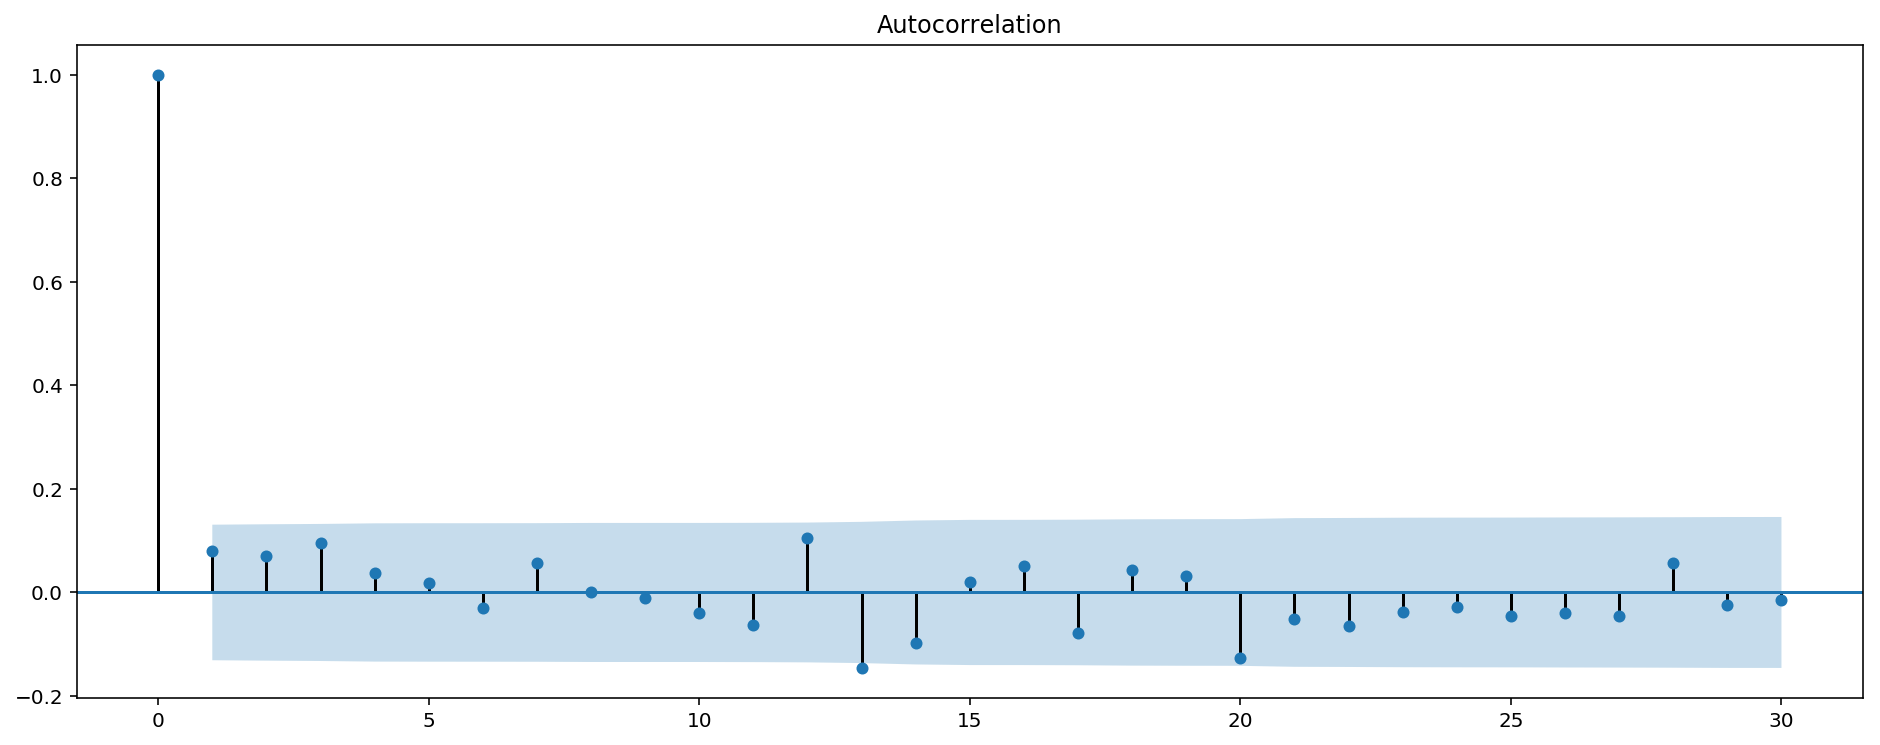

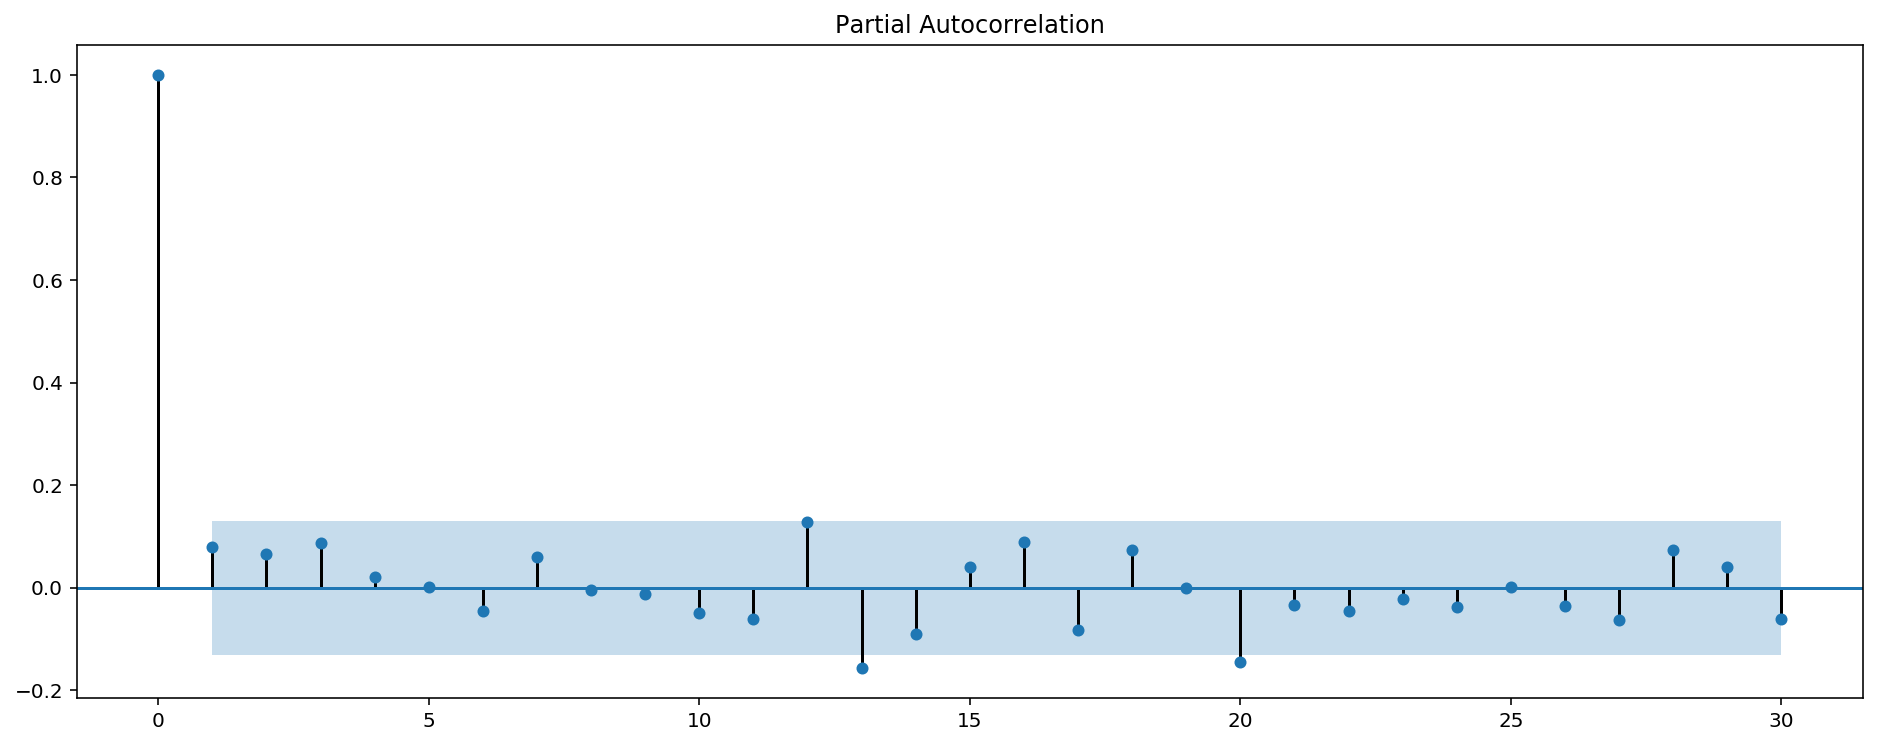

In [70]:
smt.graphics.tsa.plot_acf(train_close_monthly_log_diff, lags=30, alpha = 0.05)
smt.graphics.tsa.plot_pacf(train_close_monthly_log_diff, lags=30, alpha = 0.05)
plt.show()

In [71]:
test_stationarity(train_close_monthly_log_diff)

Results of Dickey-Fuller Test:
Test Statistic                -1.373460e+01
p-value                        1.123511e-25
#Lags Used                     0.000000e+00
Number of Observations Used    2.230000e+02
Critical Value (1%)           -3.460019e+00
Critical Value (5%)           -2.874590e+00
Critical Value (10%)          -2.573725e+00
dtype: float64


In [72]:
import statsmodels.tsa.stattools as st

order = st.arma_order_select_ic(train_close_monthly_log_diff, max_ar = 5, max_ma = 5, ic=['aic'])
print(order.aic_min_order)

(2, 2)


In [73]:
from statsmodels.tsa.arima_model import ARIMA

p,q = order.aic_min_order[0], order.aic_min_order[1]
model_AIC = ARIMA(train_close_monthly_log, order = (p, 2, q))  
results_AIC_ARIMA = model_AIC.fit(transparams = True)



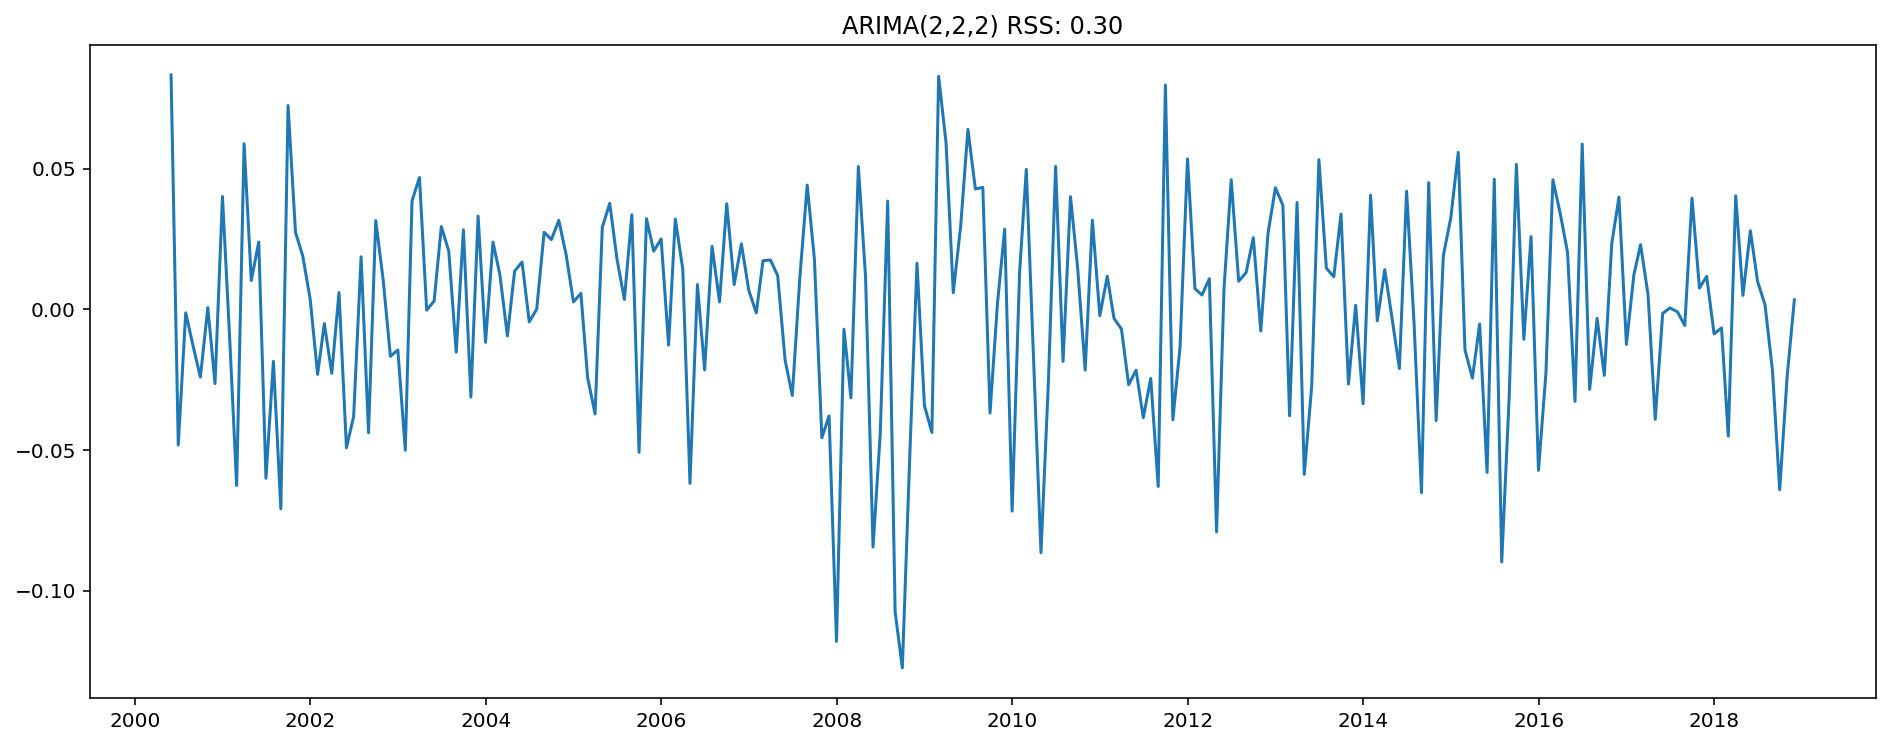

In [74]:
residuals = pd.DataFrame(results_AIC_ARIMA.resid) 

# check the residual
plt.figure() 
plt.plot(residuals)
plt.title('ARIMA(2,2,2) RSS: %.2f'% sum((results_AIC_ARIMA.resid.values)**2)); # residual sum of square

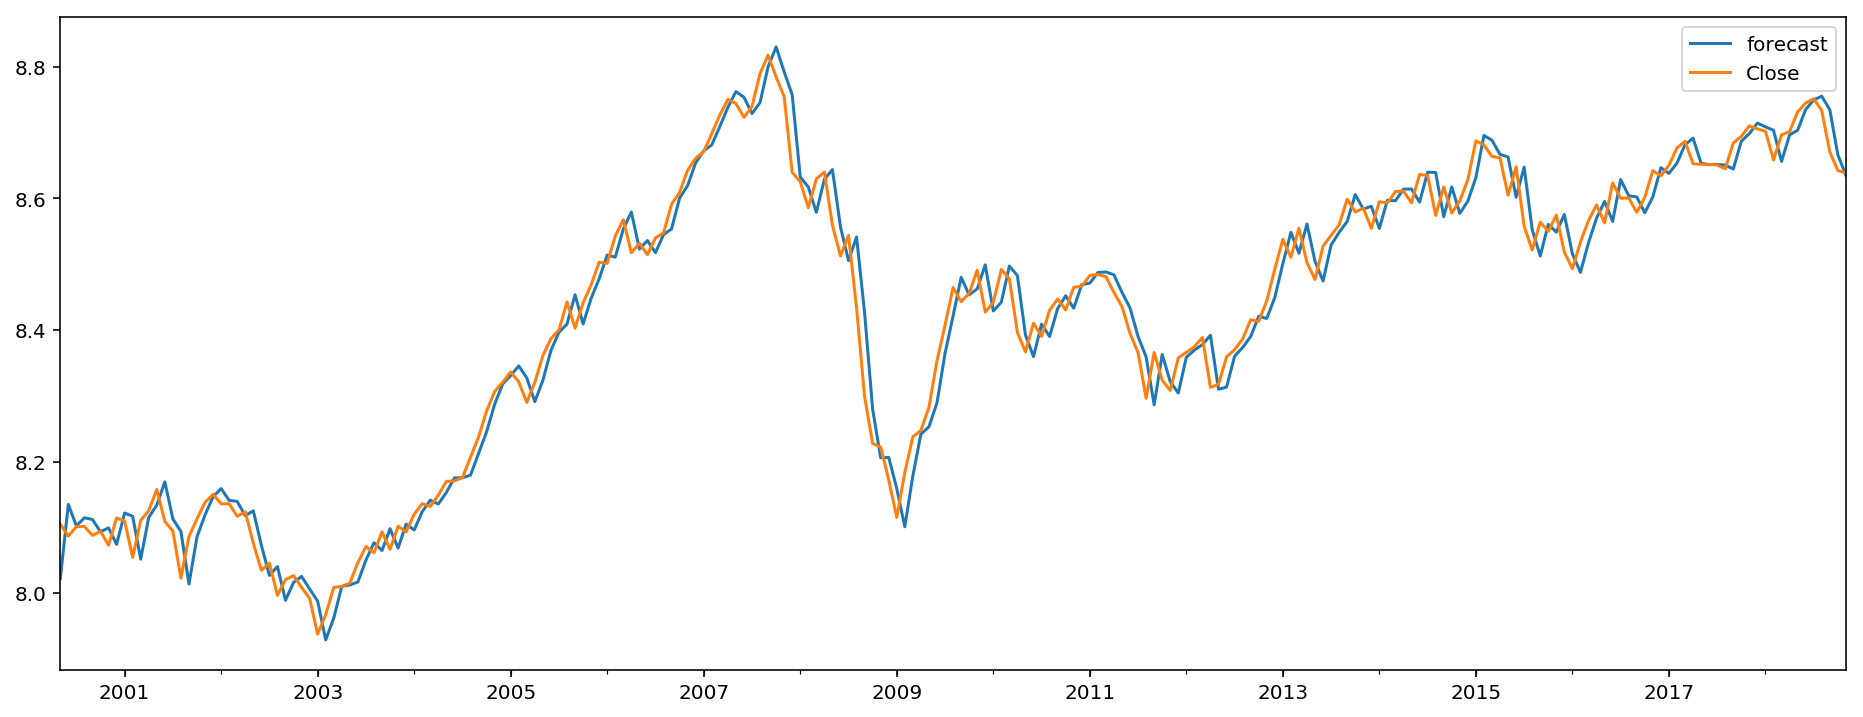

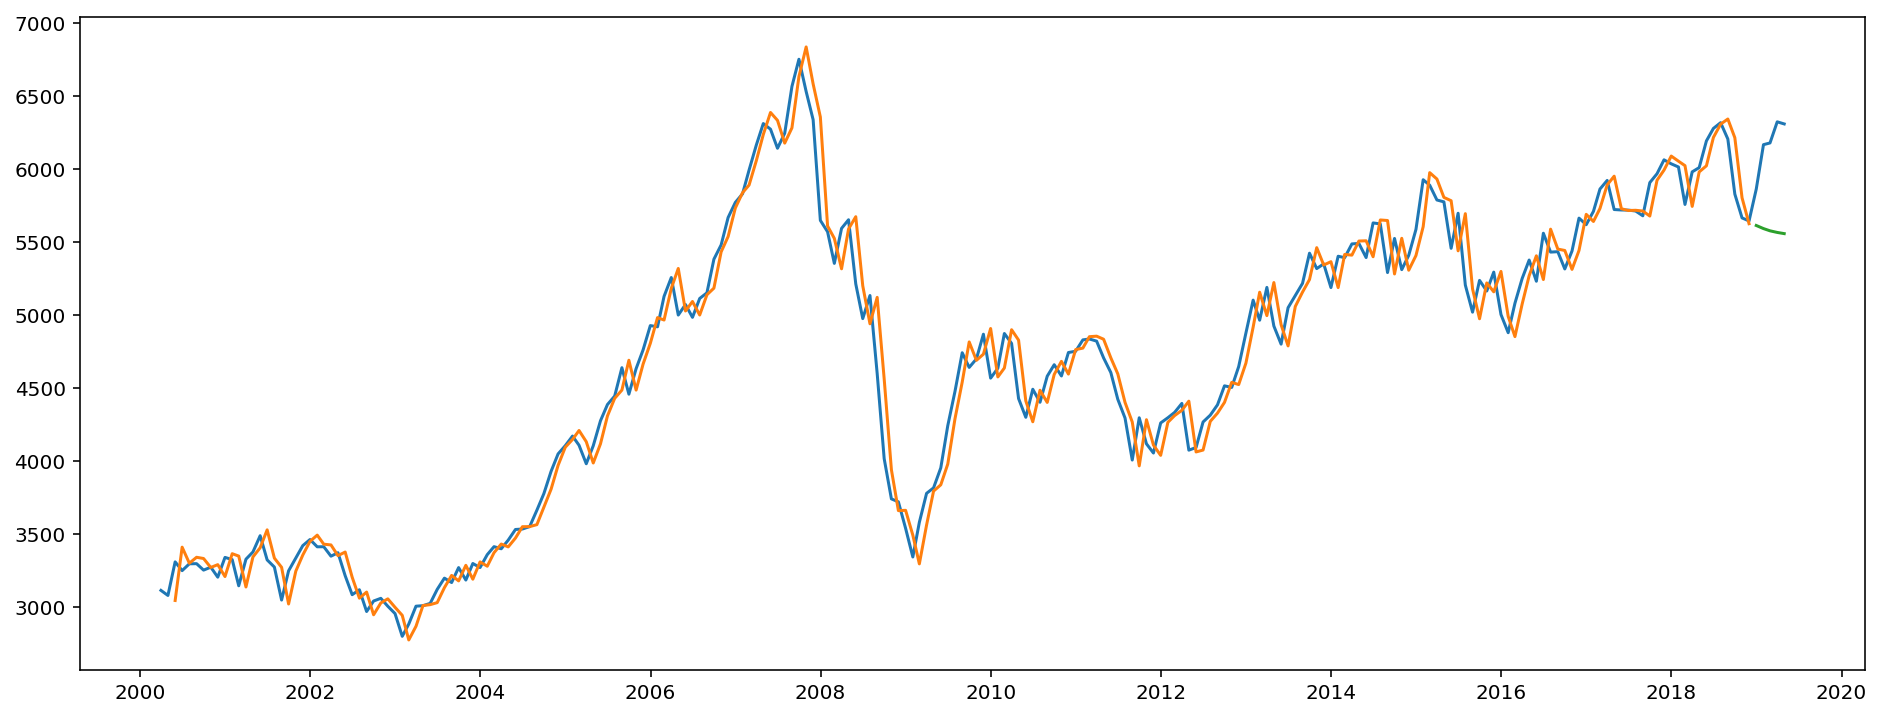

In [75]:
fitted_log = results_AIC_ARIMA.predict(typ = 'levels', dynamic = False)

# Actual vs Fitted 
results_AIC_ARIMA.plot_predict(dynamic = False) 
plt.show()

fitted = np.exp(fitted_log)
forecast, stderr, conf_int = results_AIC_ARIMA.forecast(steps = validation_size)
forecast_set = pd.Series(np.exp(forecast), index = validation_close_monthly.index)
plt.figure()
plt.plot(close_monthly)
plt.plot(fitted)
plt.plot(forecast_set)
plt.show()

In [76]:
fitted_log.tshift(-2)

2000-03-31    8.021756
2000-04-30    8.134991
2000-05-31    8.102253
2000-06-30    8.114473
2000-07-31    8.111968
2000-08-31    8.093356
2000-09-30    8.099268
2000-10-31    8.074147
2000-11-30    8.121792
2000-12-31    8.116921
2001-01-31    8.051677
2001-02-28    8.115139
2001-03-31    8.133833
2001-04-30    8.169172
2001-05-31    8.112779
2001-06-30    8.093681
2001-07-31    8.013845
2001-08-31    8.085654
2001-09-30    8.119059
2001-10-31    8.146601
2001-11-30    8.158872
2001-12-31    8.140965
2002-01-31    8.139466
2002-02-28    8.117798
2002-03-31    8.125166
2002-04-30    8.072788
2002-05-31    8.026958
2002-06-30    8.040505
2002-07-31    7.989070
2002-08-31    8.016191
                ...   
2016-04-30    8.565042
2016-05-31    8.628758
2016-06-30    8.604040
2016-07-31    8.602308
2016-08-31    8.578244
2016-09-30    8.602317
2016-10-31    8.646760
2016-11-30    8.638148
2016-12-31    8.653755
2017-01-31    8.681585
2017-02-28    8.691678
2017-03-31    8.653469
2017-04-30 

In [77]:
train_close_monthly

Date
2000-03-31    3115.800049
2000-04-30    3081.000000
2000-05-31    3311.199951
2000-06-30    3251.100098
2000-07-31    3297.800049
2000-08-31    3298.800049
2000-09-30    3254.600098
2000-10-31    3274.600098
2000-11-30    3206.199951
2000-12-31    3341.699951
2001-01-31    3326.500000
2001-02-28    3147.199951
2001-03-31    3329.399902
2001-04-30    3379.100098
2001-05-31    3490.300049
2001-06-30    3324.500000
2001-07-31    3275.600098
2001-08-31    3049.500000
2001-09-30    3249.600098
2001-10-31    3337.500000
2001-11-30    3422.300049
2001-12-31    3464.199951
2002-01-31    3414.300049
2002-02-28    3414.800049
2002-03-31    3350.000000
2002-04-30    3373.600098
2002-05-31    3216.000000
2002-06-30    3086.199951
2002-07-31    3120.100098
2002-08-31    2970.899902
                 ...     
2016-06-30    5562.299805
2016-07-31    5433.000000
2016-08-31    5435.899902
2016-09-30    5317.700195
2016-10-31    5440.500000
2016-11-30    5665.799805
2016-12-31    5620.899902
2017-01

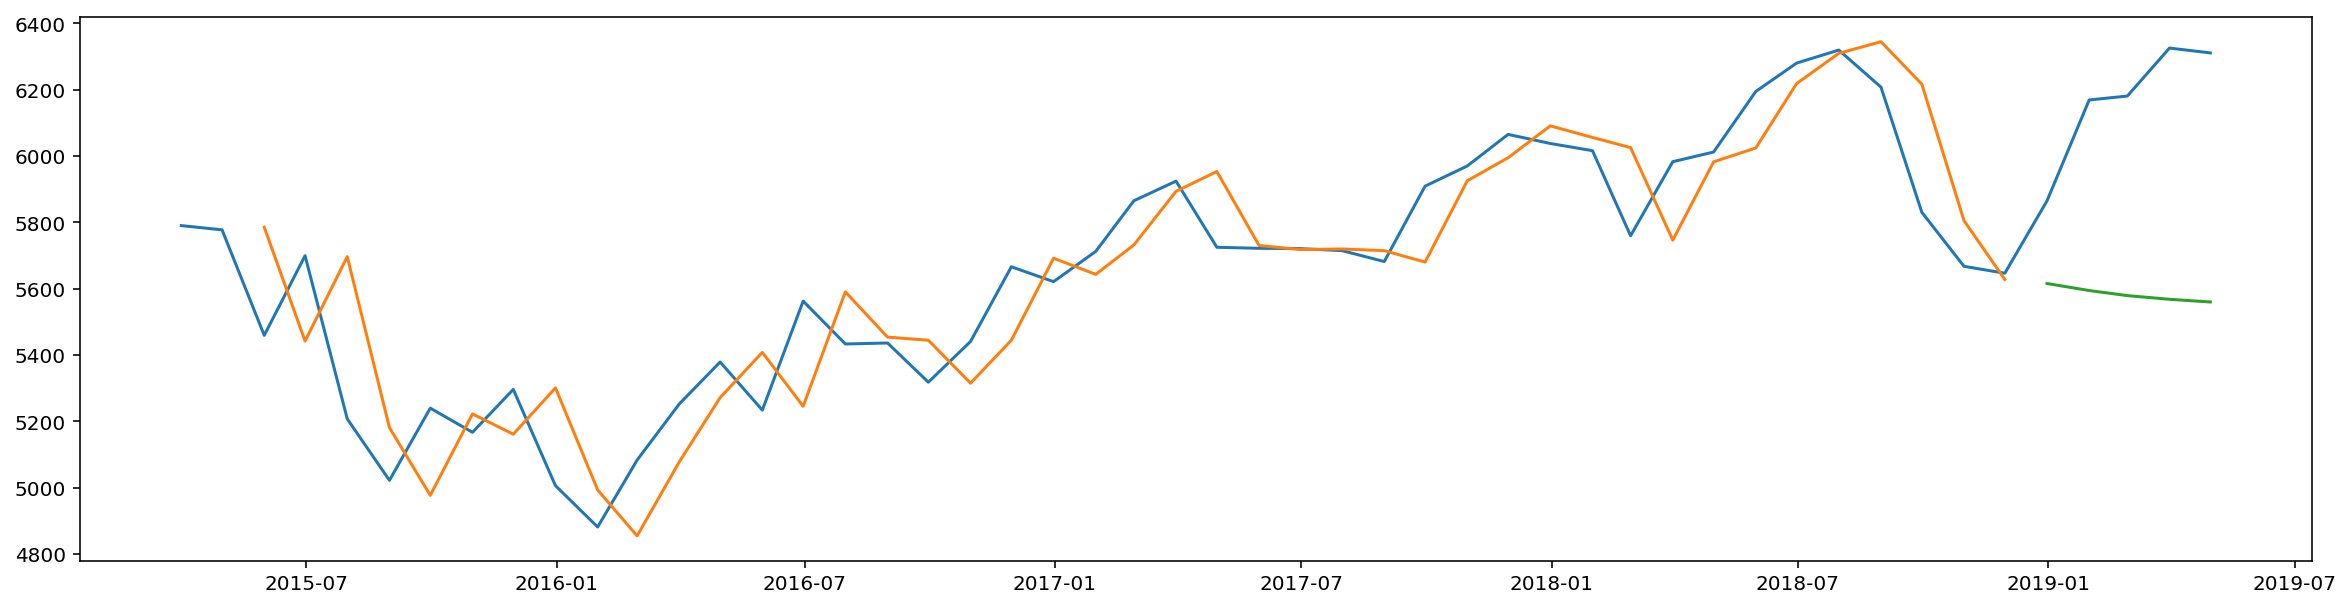

In [78]:
plt.figure(figsize = (20,5))
plt.plot(close_monthly[-50:])
plt.plot(fitted[-43:])
plt.plot(forecast_set);


In [79]:
print("MSE of train set for ARIMA\n{:.2f}".format(mse(fitted,train_close_monthly[:-2])))
print("MSE of test set for ARIMA\n{:.2f}".format(mse(forecast_set,validation_set)))

MSE of train set for ARIMA
36610.95
MSE of test set for ARIMA
378702.32


# Neural Network


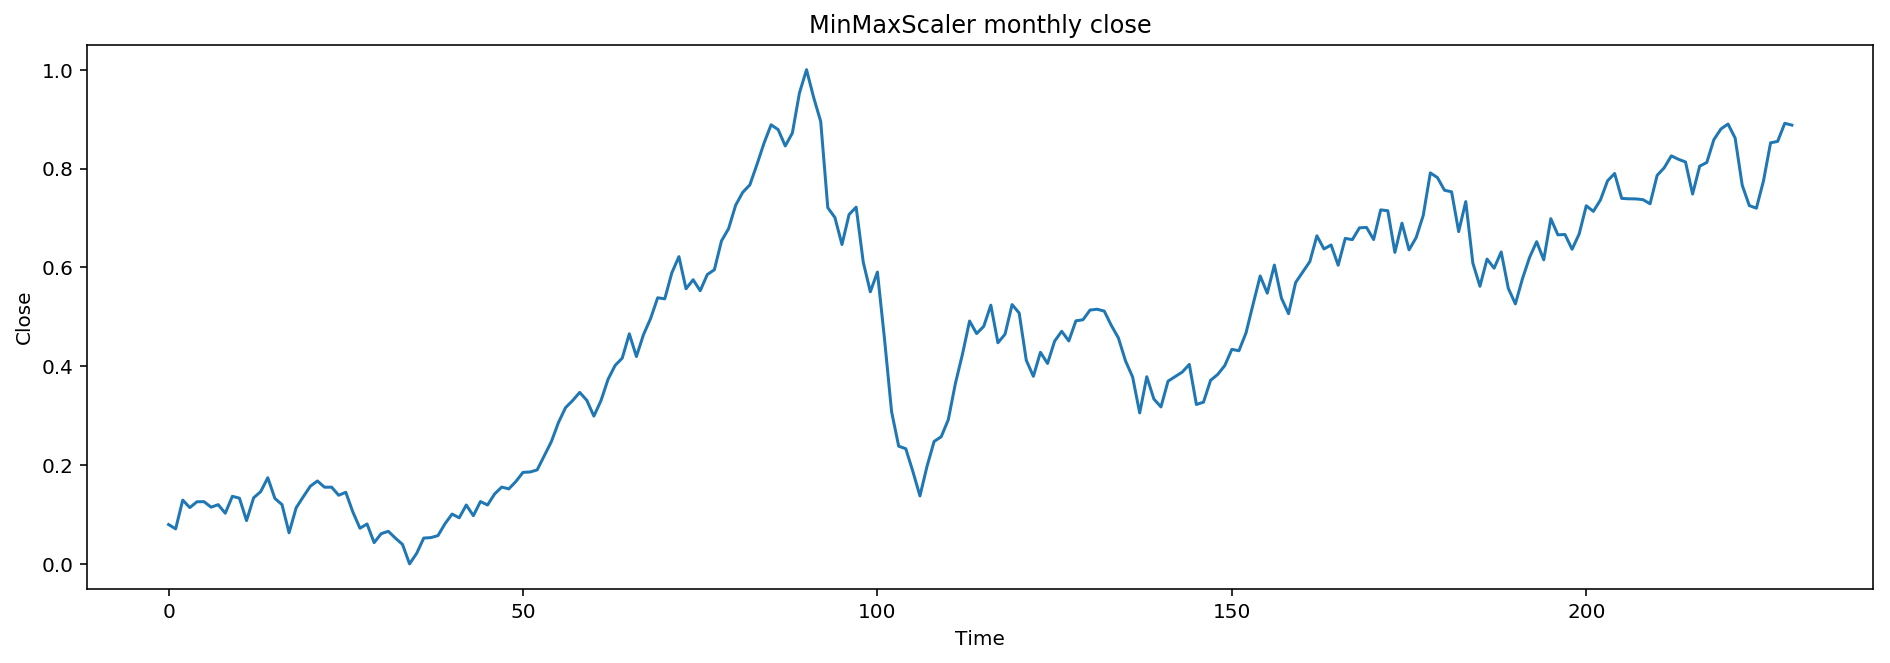

In [109]:
scaler = MinMaxScaler()
close_monthly_normalize = scaler.fit_transform(close_monthly.values.reshape(-1,1))
close_monthly_normalize = scaler.fit_transform(close_monthly.values.reshape(-1,1))

plt.figure(figsize = (16,5))
plt.plot(close_monthly_normalize)
plt.title("MinMaxScaler monthly close")
plt.xlabel("Time")
plt.ylabel("Close");



In [110]:
data = close_monthly_normalize
time_window = 2
Xall, Yall = [], []
for i in range(time_window, len(data)):
    Xall.append(data[i-time_window:i, 0])
    Yall.append(data[i, 0])
    
Xall = np.array(Xall) # Convert them from list to array
Yall = np.array(Yall)
test_size = 5
train_size =  len(Xall) - test_size

Xtrain = Xall[:train_size, :]
Ytrain = Yall[:train_size]
Xtest = Xall[-test_size:, :]
Ytest = Yall[-test_size:]

In [111]:
def create_model():
# create model
    model = Sequential()
    model.add(Dense(20, input_dim=time_window,activation='relu'))
    model.add(Dense(1))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam',metrics=["accuracy"])
    return model

In [112]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasRegressor

model = KerasRegressor(build_fn=create_model, verbose=2)

#batch_size = [1,2,5, 10, 20, 40, 60, 80, 100]
batch_size = [1,2,5,20, 50, 100]
epochs = [10, 50, 100]
param_grid = dict(batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1,cv = 5)

grid_result = grid.fit(Xtrain, Ytrain)

Epoch 1/100
 - 0s - loss: 0.0870 - acc: 0.0045
Epoch 2/100
 - 0s - loss: 0.0085 - acc: 0.0090
Epoch 3/100
 - 0s - loss: 0.0038 - acc: 0.0090
Epoch 4/100
 - 0s - loss: 0.0028 - acc: 0.0090
Epoch 5/100
 - 0s - loss: 0.0026 - acc: 0.0090
Epoch 6/100
 - 0s - loss: 0.0028 - acc: 0.0090
Epoch 7/100
 - 0s - loss: 0.0026 - acc: 0.0090
Epoch 8/100
 - 0s - loss: 0.0026 - acc: 0.0090
Epoch 9/100
 - 0s - loss: 0.0025 - acc: 0.0090
Epoch 10/100
 - 0s - loss: 0.0025 - acc: 0.0090
Epoch 11/100
 - 0s - loss: 0.0025 - acc: 0.0090
Epoch 12/100
 - 0s - loss: 0.0025 - acc: 0.0090
Epoch 13/100
 - 0s - loss: 0.0024 - acc: 0.0090
Epoch 14/100
 - 0s - loss: 0.0025 - acc: 0.0090
Epoch 15/100
 - 0s - loss: 0.0023 - acc: 0.0090
Epoch 16/100
 - 0s - loss: 0.0024 - acc: 0.0090
Epoch 17/100
 - 0s - loss: 0.0023 - acc: 0.0090
Epoch 18/100
 - 0s - loss: 0.0023 - acc: 0.0090
Epoch 19/100
 - 0s - loss: 0.0023 - acc: 0.0090
Epoch 20/100
 - 0s - loss: 0.0022 - acc: 0.0090
Epoch 21/100
 - 0s - loss: 0.0024 - acc: 0.0090
E

In [113]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.002059 using {'batch_size': 2, 'epochs': 100}
-0.004101 (0.002446) with: {'batch_size': 1, 'epochs': 10}
-0.002868 (0.001289) with: {'batch_size': 1, 'epochs': 50}
-0.002293 (0.001365) with: {'batch_size': 1, 'epochs': 100}
-0.002232 (0.001103) with: {'batch_size': 2, 'epochs': 10}
-0.002533 (0.001024) with: {'batch_size': 2, 'epochs': 50}
-0.002059 (0.001219) with: {'batch_size': 2, 'epochs': 100}
-0.003212 (0.001381) with: {'batch_size': 5, 'epochs': 10}
-0.002242 (0.001027) with: {'batch_size': 5, 'epochs': 50}
-0.002313 (0.001210) with: {'batch_size': 5, 'epochs': 100}
-0.044334 (0.048672) with: {'batch_size': 20, 'epochs': 10}
-0.002844 (0.001318) with: {'batch_size': 20, 'epochs': 50}
-0.002644 (0.001170) with: {'batch_size': 20, 'epochs': 100}
-0.103706 (0.104110) with: {'batch_size': 50, 'epochs': 10}
-0.008831 (0.007549) with: {'batch_size': 50, 'epochs': 50}
-0.007824 (0.010145) with: {'batch_size': 50, 'epochs': 100}
-0.289225 (0.327177) with: {'batch_size': 100, 'e

In [130]:
batch_size_monthly = grid_result.best_params_['batch_size']
epochs_monthly = grid_result.best_params_["epochs"]

In [115]:
model = Sequential()
model.add(Dense(20, input_dim=time_window,activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')
model.fit(Xtrain, Ytrain, epochs=epochs_monthly, batch_size=batch_size_monthly,verbose=2, validation_split=0.05)

Train on 211 samples, validate on 12 samples
Epoch 1/100
 - 0s - loss: 0.1602 - val_loss: 0.0792
Epoch 2/100
 - 0s - loss: 0.0148 - val_loss: 0.0140
Epoch 3/100
 - 0s - loss: 0.0049 - val_loss: 0.0044
Epoch 4/100
 - 0s - loss: 0.0029 - val_loss: 0.0023
Epoch 5/100
 - 0s - loss: 0.0025 - val_loss: 0.0026
Epoch 6/100
 - 0s - loss: 0.0024 - val_loss: 0.0019
Epoch 7/100
 - 0s - loss: 0.0023 - val_loss: 0.0018
Epoch 8/100
 - 0s - loss: 0.0024 - val_loss: 0.0018
Epoch 9/100
 - 0s - loss: 0.0022 - val_loss: 0.0019
Epoch 10/100
 - 0s - loss: 0.0023 - val_loss: 0.0018
Epoch 11/100
 - 0s - loss: 0.0023 - val_loss: 0.0018
Epoch 12/100
 - 0s - loss: 0.0022 - val_loss: 0.0017
Epoch 13/100
 - 0s - loss: 0.0022 - val_loss: 0.0018
Epoch 14/100
 - 0s - loss: 0.0023 - val_loss: 0.0020
Epoch 15/100
 - 0s - loss: 0.0022 - val_loss: 0.0017
Epoch 16/100
 - 0s - loss: 0.0023 - val_loss: 0.0019
Epoch 17/100
 - 0s - loss: 0.0022 - val_loss: 0.0018
Epoch 18/100
 - 0s - loss: 0.0022 - val_loss: 0.0017
Epoch 19/1

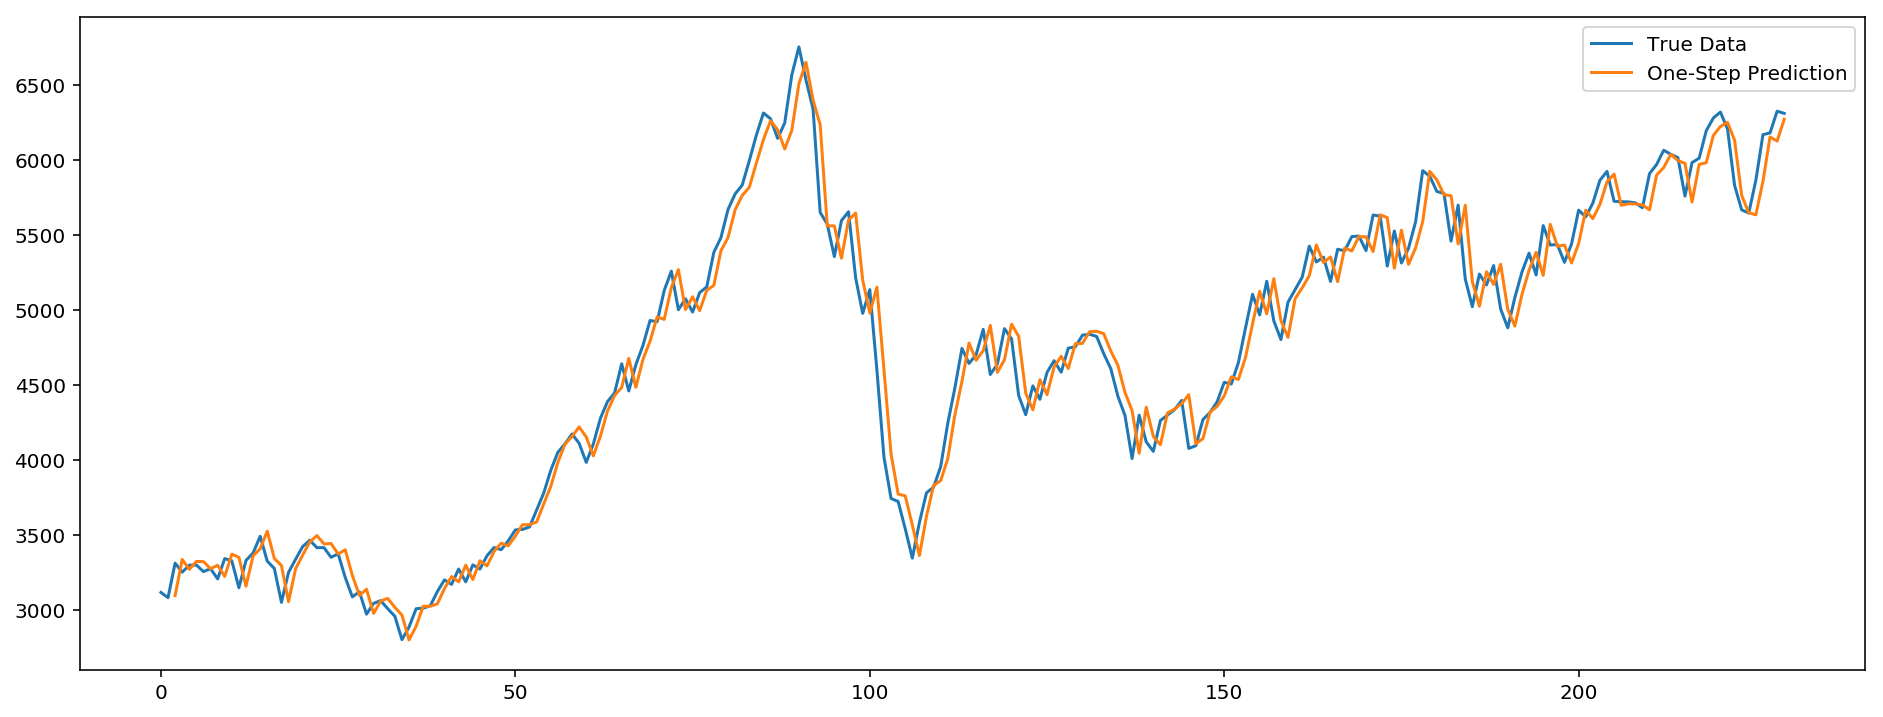

In [116]:
allPredict = model.predict(Xall)
allPredictPlot = scaler.inverse_transform(allPredict)
plt.figure()
plt.plot(scaler.inverse_transform(data), label='True Data')
plt.plot(np.arange(time_window, len(data)),allPredictPlot, label='One-Step Prediction')
plt.legend(); 

228

In [84]:
Ytrain.shape

(223,)

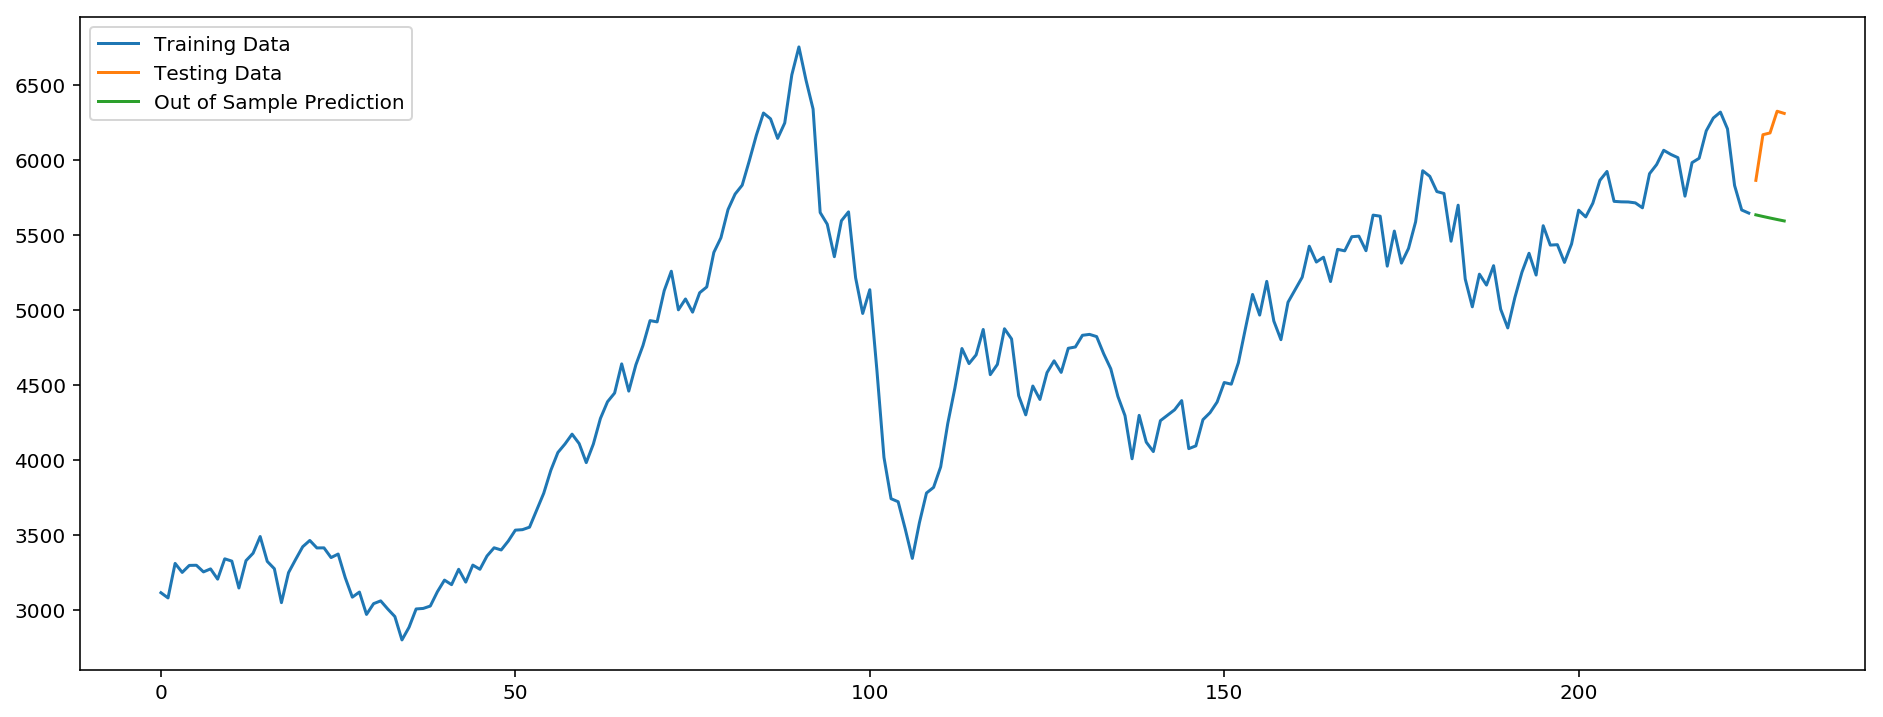

In [117]:
dynamic_prediction = np.copy(data[:len(data) - test_size])
for i in range(len(data) - test_size, len(data)):
    last_feature = np.reshape(dynamic_prediction[i-time_window:i], (1,time_window))
    next_pred = model.predict(last_feature)
    dynamic_prediction = np.append(dynamic_prediction, next_pred)
    
dynamic_prediction = dynamic_prediction.reshape(-1,1)
dynamic_prediction = scaler.inverse_transform(dynamic_prediction)

plt.figure()
plt.plot(scaler.inverse_transform(data[:len(data) - test_size]), label='Training Data')
plt.plot(np.arange(len(data) - test_size, len(data), 1),scaler.inverse_transform(data[-test_size:]), label='Testing Data')
plt.plot(np.arange(len(data) - test_size, len(data), 1), dynamic_prediction[-test_size:], label='Out of Sample Prediction')
plt.legend(loc = "upper left")

In [118]:
Ytrain_ = scaler.inverse_transform(Ytrain.reshape(-1, 1))
allPredict_ = scaler.inverse_transform(allPredict[:train_size,0].reshape(-1, 1))
print("MSE of train set for NN\n{:.2f}".format(mse(Ytrain_,allPredict_)))

MSE of train set for NN
28496.63


In [119]:
Ytest
dynamic_prediction[-test_size:]

array([[5634.7532793 ],
       [5623.98102403],
       [5613.646332  ],
       [5603.71197379],
       [5594.16121975]])

In [120]:
testScore = mse(scaler.inverse_transform(Ytest.reshape(-1, 1)),dynamic_prediction[-test_size:])
print('Dynamic Forecast MSE: {0:.2f}'.format(testScore))

Dynamic Forecast MSE: 341232.73


# Forecast 

# Daily

In [128]:
data = close_daily_normalize
time_window = 2
Xall, Yall = [], []
for i in range(time_window, len(data)):
    Xall.append(data[i-time_window:i, 0])
    Yall.append(data[i, 0])
    
Xall = np.array(Xall) # Convert them from list to array
Yall = np.array(Yall)
test_size = 5
# train_size =  len(Xall) - test_size

Xtrain = Xall
Ytrain = Yall



In [ ]:
model = Sequential()
model.add(Dense(20, input_dim=time_window,activation='relu'))
model.add(Dense(1)
model.compile(loss='mean_squared_error',optimizer='adam')
model.fit(Xtrain, Ytrain, epochs=epochs_daily, batch_size=batch_size_daily,verbose=2, validation_split=0.05)

In [ ]:
allPredict = model.predict(Xall)
allPredictPlot = scaler.inverse_transform(allPredict)
plt.figure()
plt.plot(scaler.inverse_transform(data), label='True Data')
plt.plot(np.arange(time_window, len(data)),allPredictPlot, label='One-Step Prediction')
plt.legend(); 

In [ ]:
dynamic_prediction = np.copy(data)
for i in range(len(data) - test_size, len(data)):
    last_feature = np.reshape(dynamic_prediction[i-time_window:i], (1,time_window))
    next_pred = model.predict(last_feature)
    dynamic_prediction = np.append(dynamic_prediction, next_pred)
    
dynamic_prediction = dynamic_prediction.reshape(-1,1)
dynamic_prediction = scaler.inverse_transform(dynamic_prediction)

In [ ]:
dynamic_prediction[-test_size:]

In [ ]:
plt.figure()
plt.plot(scaler.inverse_transform(data), label='Training Data')
plt.plot(np.arange(len(data) , len(data)+ test_size, 1), dynamic_prediction[-test_size:], label='Out of Sample Prediction')
plt.legend(loc = "upper left")

# Monthly

In [132]:
data = close_monthly_normalize
time_window = 2
Xall, Yall = [], []
for i in range(time_window, len(data)):
    Xall.append(data[i-time_window:i, 0])
    Yall.append(data[i, 0])
    
Xall = np.array(Xall) # Convert them from list to array
Yall = np.array(Yall)
test_size = 5
# train_size =  len(Xall) - test_size

Xtrain = Xall
Ytrain = Yall
# Xtest = Xall[-test_size:, :]
# Ytest = Yall[-test_size:]

In [131]:
model = Sequential()
model.add(Dense(20, input_dim=time_window,activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')
model.fit(Xtrain, Ytrain, epochs=epochs_monthly, batch_size=batch_size_monthly,verbose=2, validation_split=0.05)

Train on 4622 samples, validate on 244 samples
Epoch 1/100
 - 2s - loss: 4.1467e-04 - val_loss: 1.9062e-04
Epoch 2/100
 - 2s - loss: 1.6187e-04 - val_loss: 4.8961e-04
Epoch 3/100
 - 2s - loss: 1.6210e-04 - val_loss: 2.8622e-04
Epoch 4/100
 - 2s - loss: 1.5607e-04 - val_loss: 1.0654e-04
Epoch 5/100
 - 2s - loss: 1.5621e-04 - val_loss: 2.3869e-04
Epoch 6/100
 - 2s - loss: 1.5057e-04 - val_loss: 1.6830e-04
Epoch 7/100
 - 2s - loss: 1.5409e-04 - val_loss: 1.2649e-04
Epoch 8/100
 - 2s - loss: 1.5025e-04 - val_loss: 2.3567e-04
Epoch 9/100
 - 2s - loss: 1.5619e-04 - val_loss: 2.1394e-04
Epoch 10/100
 - 2s - loss: 1.5784e-04 - val_loss: 1.3443e-04
Epoch 11/100
 - 2s - loss: 1.5075e-04 - val_loss: 1.2286e-04
Epoch 12/100
 - 2s - loss: 1.5194e-04 - val_loss: 1.3988e-04
Epoch 13/100
 - 2s - loss: 1.4970e-04 - val_loss: 2.1814e-04
Epoch 14/100
 - 2s - loss: 1.5226e-04 - val_loss: 1.1070e-04
Epoch 15/100
 - 2s - loss: 1.5265e-04 - val_loss: 1.0322e-04
Epoch 16/100
 - 2s - loss: 1.4654e-04 - val_los

KeyboardInterrupt: 

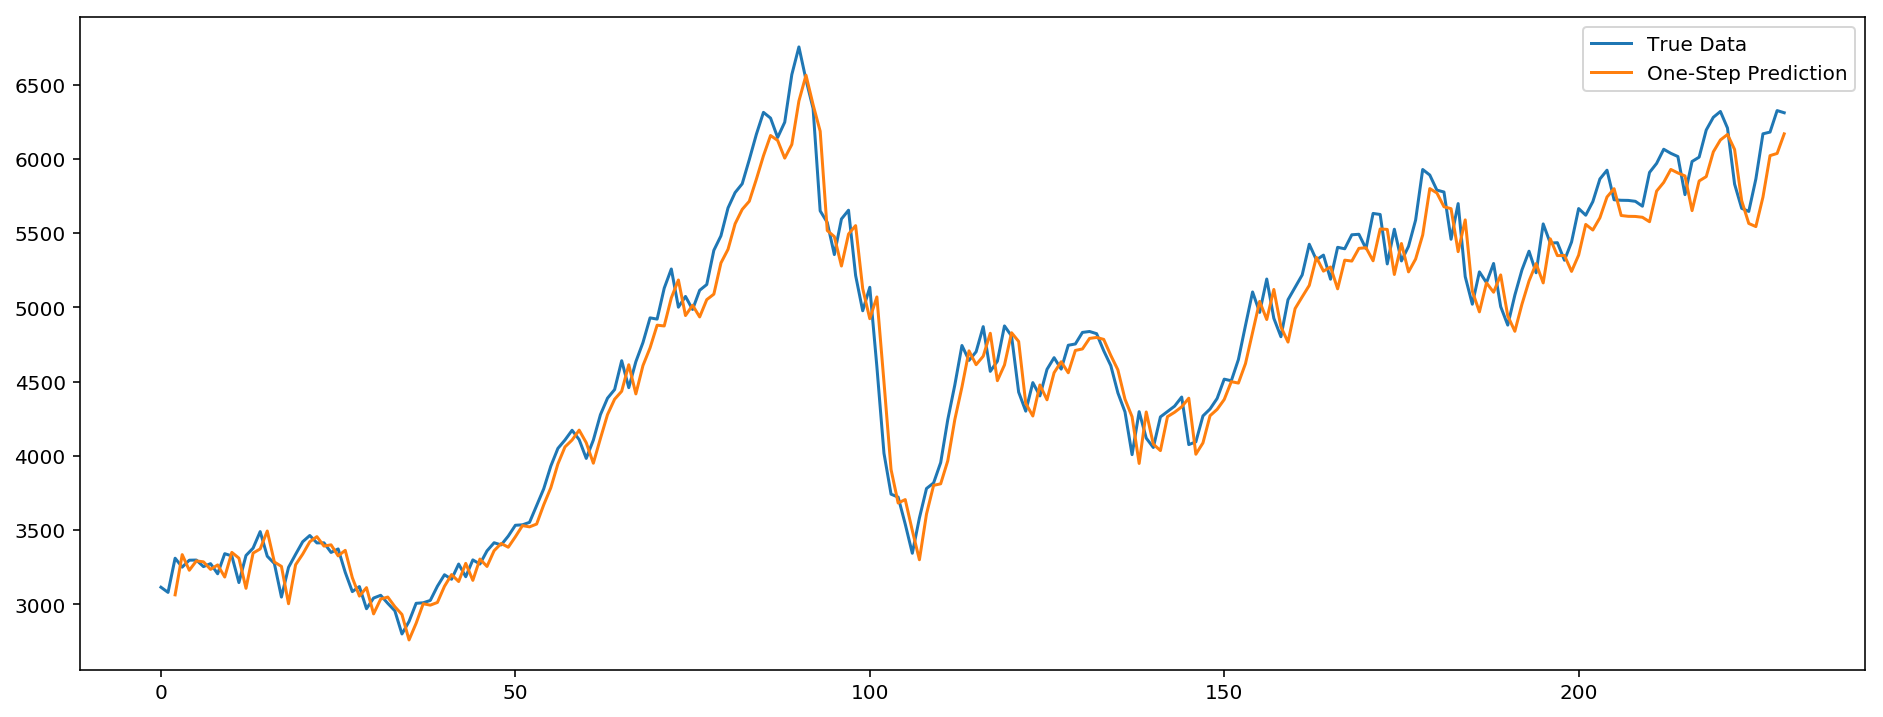

In [123]:
allPredict = model.predict(Xall)
allPredictPlot = scaler.inverse_transform(allPredict)
plt.figure()
plt.plot(scaler.inverse_transform(data), label='True Data')
plt.plot(np.arange(time_window, len(data)),allPredictPlot, label='One-Step Prediction')
plt.legend(); 

In [126]:
dynamic_prediction = np.copy(data)
for i in range(len(data) - test_size, len(data)):
    last_feature = np.reshape(dynamic_prediction[i-time_window:i], (1,time_window))
    next_pred = model.predict(last_feature)
    dynamic_prediction = np.append(dynamic_prediction, next_pred)
    
dynamic_prediction = dynamic_prediction.reshape(-1,1)
dynamic_prediction = scaler.inverse_transform(dynamic_prediction)

In [133]:
dynamic_prediction[-test_size:]

array([[5544.34333867],
       [5742.5184808 ],
       [6022.13504899],
       [6036.91936083],
       [6168.71755171]])

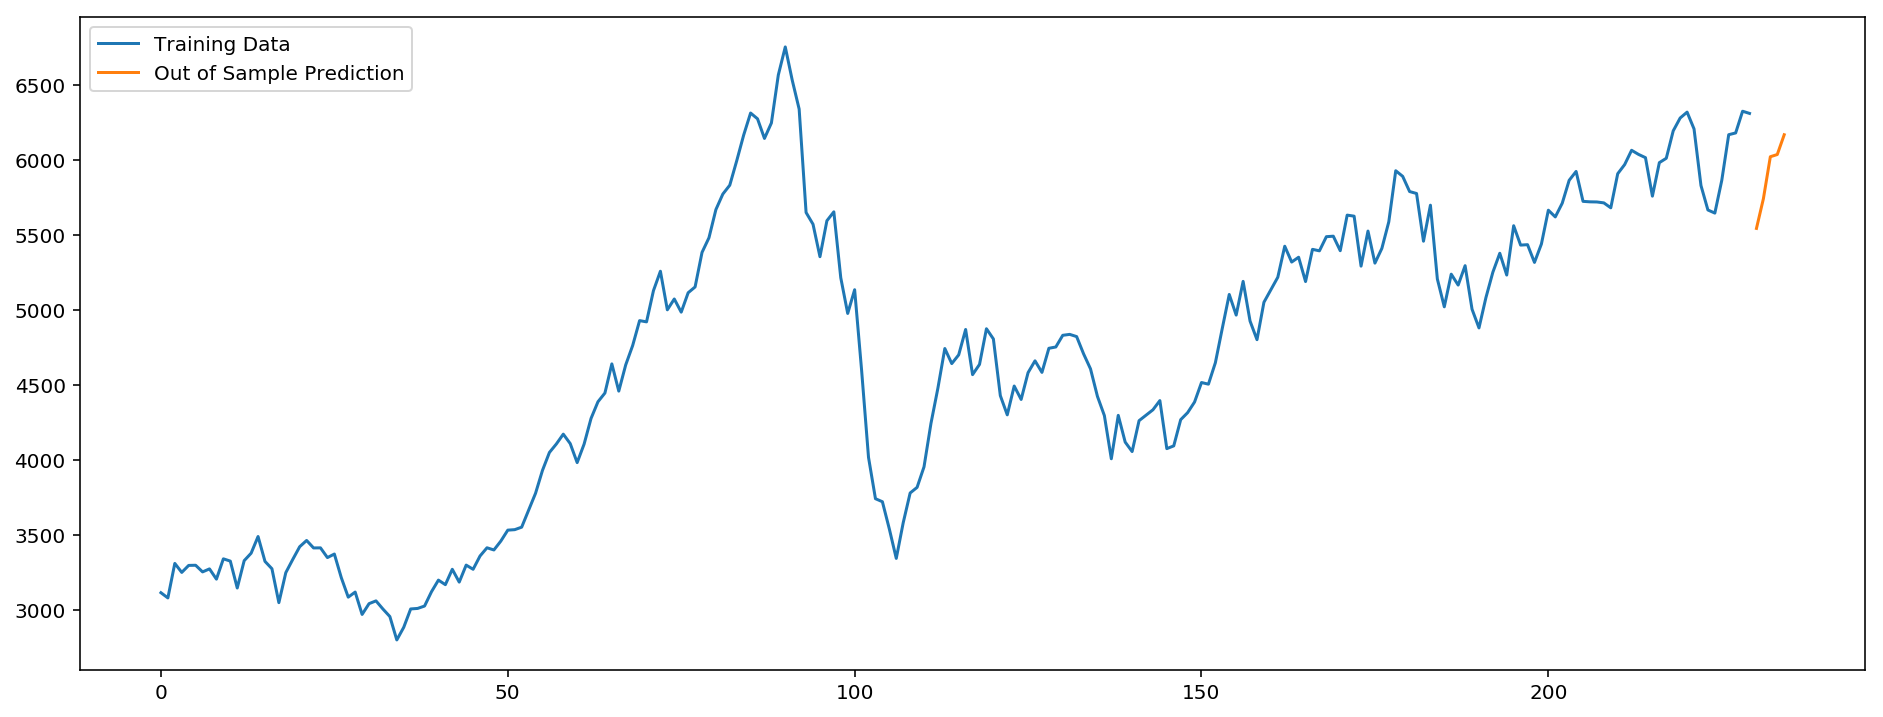

In [138]:
plt.figure()
plt.plot(scaler.inverse_transform(data), label='Training Data')
plt.plot(np.arange(len(data) , len(data)+ test_size, 1), dynamic_prediction[-test_size:], label='Out of Sample Prediction')
plt.legend(loc = "upper left")